In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import random
from imdbDataSet import *
import sklearn.metrics
import sklearn.ensemble
import sklearn.model_selection

In [18]:
class Node:
    def __init__(self, checking_feature=None, is_leaf=False, feature_value=None, category=None):
        self.checking_feature = checking_feature
        self.feature_value = feature_value
        self.is_leaf = is_leaf
        self.category = category
        self.left_child = None
        self.right_child = None
        # keep track of how many of the checking factor have a result of yes / no
        self.pos = 0
        self.neg = 0
        self.total = 0
        
    def addPos(self):
        self.pos += 1
        self.total += 1
        
    def addNeg(self):
        self.neg += 1
        self.total += 1
    
class Stump:
    def __init__(self, root=None, left_child=None, right_child=None):
        self.root = root
        self.left_child = left_child
        self.right_child = right_child
        self.checking_feature = root.checking_feature
        

In [31]:
def createDF(x, y, sample_w, features):
    # make dataframe
    df = pd.DataFrame(x, columns=features)
    # add y column
    features.append("Positive")
    df["Positive"] = y
    # add first sample weights to dataframe
    features.append("Sample Weight")
    df["Sample weights"] = sample_w
    
    return df, x, y

# initialize list of lists
imdb = IMDB()
imdb.getTrainingData(1, 2, 3, 250, 1000, 2000)

# get feature vector
features = imdb.getFeatureVector(250, 1000)

# get values of each feature for n movie reviews
n = 10
x_train = np.zeros((n, len(features)))
y_train = list()
# for the first n reviews
for i in range(n):
    x_i = imdb.getXtrain(i)
    y_train.append(imdb.getYtrain(i))
    # for word index in x_train
    for wi in x_i:
        if wi == 2:
            continue
        elif (wi in features):
            j = features.index(wi)
            x_train[i][j] = 1

# Create the pandas DataFrame
sample_w = [1/n for i in range(n)]
df = createDF(x_train, y_train, sample_w, features)[0]

stumps=[]
igs=[]

display(df)

251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
6  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
7  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  ...   0.0   0.0   0.0   
8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
9  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   

   1246  1247  1248  1249  1250  Positive  Sample weights  
0   0.0   0.0   0.0   0.0   0.0         1             0.1  
1   0.0   0.0   0.0   0.0   0.0         0             0.1  
2   0.0   0.0   0.0   0.0   0.0         0             0.1  
3   0.0   0.0   0.0   0.0   0.0         1             0.1  
4   0.0   0.0   0.0   0.0   0.0         0             0.1  
5   0.0   0.0   0.0   0.0   0.0         0             0.1  
6   0.0   0.0   0.0   0.0   0.0         1             0.1  
7   0.0   0.0   0.0   0.0   0.0         0             0.1  
8   0.0   0.0   0.0   0.0   0.0         1             0.1  
9   0.0   0.0   0.0   0.0   0.0         0             0.1  

[10 rows x 1002 columns]

In [5]:
'''
# create stumps
def makeStumps(x, y, features):
    stumps = []

    for j in range(len(features) - 2):
        root, left, right = Node(features[j]), Node(features[j], True), Node(features[j], True)
        root.left_child = left
        root.right_child = right

        for i in range(len(x)):
            if (x[i][j] == 0 and y[i] == 0):
                left.addNeg()
            elif (x[i][j] == 0 and y[i] == 1):
                left.addPos()
            elif (x[i][j] == 1 and y[i] == 0):
                right.addNeg()
            else:
                right.addPos()

        # make sure we don't have a total of 0 (so in case we have totals of 0 we can compute the fitting category below with no problem, as well as the total error later on)
        if (left.total == 0):
            left.total += sys.float_info.epsilon
        if (right.total == 0):
            right.total += sys.float_info.epsilon

        # calculate the left's / right's category
        if (left.pos / left.total > right.pos / right.total):
            left.category = 1
            right.category = 0
        else:
            left.category = 0
            right.category = 1
        s = Stump(root, left, right)
        stumps.append(s)

    return stumps

# check stumps made
stumps = makeStumps(x_train, y_train, features)
for stump in stumps:
    print("(" + str(stump.root.checking_feature) + ", " + imdb.getInvertedWordIndex(stump.root.checking_feature) + ")\n---------------------")
    print("Not in review", "\n P:", stump.left_child.pos, "\tN:", stump.left_child.neg, "\tT:", int(stump.left_child.total), "\tC:", stump.left_child.category)
    print("In review", "\n P:", stump.right_child.pos, "\tN:", stump.right_child.neg, "\tT:", int(stump.right_child.total), "\tC:", stump.right_child.category)
    print()
'''

'\n# create stumps\ndef makeStumps(x, y, features):\n    stumps = []\n\n    for j in range(len(features) - 2):\n        root, left, right = Node(features[j]), Node(features[j], True), Node(features[j], True)\n        root.left_child = left\n        root.right_child = right\n\n        for i in range(len(x)):\n            if (x[i][j] == 0 and y[i] == 0):\n                left.addNeg()\n            elif (x[i][j] == 0 and y[i] == 1):\n                left.addPos()\n            elif (x[i][j] == 1 and y[i] == 0):\n                right.addNeg()\n            else:\n                right.addPos()\n\n        # make sure we don\'t have a total of 0 (so in case we have totals of 0 we can compute the fitting category below with no problem, as well as the total error later on)\n        if (left.total == 0):\n            left.total += sys.float_info.epsilon\n        if (right.total == 0):\n            right.total += sys.float_info.epsilon\n\n        # calculate the left\'s / right\'s category\n     

In [35]:
def informationGain(category_vector, feature_values):
    category_set = set(category_vector)
    
    # calculate entropy
    HC = 0
    for c in category_set:
        PC = category_vector.count(c) / len(category_vector) # P(C=c)
        HC += - PC * np.log2(PC)
    #print("Entropy:", HC)
    
    # calculate IG(C, X)
    feature_set = set(feature_values)
    HC_feature = 0
    for value in feature_set:
        # p_feature --> P(X=x)
        P_feature = feature_values.count(value) / len(feature_values) # count occurences of value
        indices = [i for i in range(len(feature_values)) if feature_values[i] == value] # rows that have X=x
        category_of_feature = [category_vector[i] for i in indices] # category of rows listed in indices above
        for c in category_set:
            # PC_feature --> P(C=c|X=x)
            PC_feature = category_of_feature.count(c) / len(category_of_feature) # given X=x, count C
            if PC_feature != 0:
                # - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
                temp_H = - P_feature * PC_feature * np.log2(PC_feature)
                # sum for all values of C (class) and X (values of specific feature)
                HC_feature += temp_H
    IG = HC - HC_feature
    return IG

def makeStump(x, y, features, index):
    root, left, right = Node(features[index]), Node(features[index], True), Node(features[index], True)
    root.left_child = left
    root.right_child = right

    for i in range(len(x)):
        if (x[i][index] == 0 and y[i] == 0):
            left.addNeg()
        elif (x[i][index] == 0 and y[i] == 1):
            left.addPos()
        elif (x[i][index] == 1 and y[i] == 0):
            right.addNeg()
        else:
            right.addPos()

    # make sure we don't have a total of 0 (so in case we have totals of 0 we can compute the fitting category below with no problem, as well as the total error later on)
    if (left.total == 0):
        left.total += sys.float_info.epsilon
    if (right.total == 0):
        right.total += sys.float_info.epsilon

    # calculate the left's / right's category
    if (left.pos / left.total > right.pos / right.total):
        left.category = 1
        right.category = 0
    else:
        left.category = 0
        right.category = 1
    s = Stump(root, left, right)

    return s

# check information gain
for j in range(len(features) - 2):
    feature_values = [x_train[i][j] for i in range(len(x_train))]
    category_vector = list(y_train)
    ig = informationGain(category_vector, feature_values)
    igs.append(ig)
    print("IG:", ig, "\n")

# find max IG
max_ig_i = np.where(igs == max(igs))[0][0]

# make stump
fstump = makeStump(x_train, y_train, features, max_ig_i)
print("Choosing stump hosting feature: (" + str(fstump.checking_feature) + ", " + imdb.getInvertedWordIndex(fstump.checking_feature) + ")")


IG: 0.17095059445466854 

IG: 0.0 

IG: 0.07898214060026865 

IG: 0.0 

IG: 0.0 

IG: 0.14448434380562802 

IG: 0.09127744624168 

IG: 0.17095059445466854 

IG: 0.07898214060026865 

IG: 0.0 

IG: 0.0 

IG: 0.0 

IG: 0.007403392114696539 

IG: 0.14448434380562802 

IG: 0.14448434380562802 

IG: 0.0 

IG: 0.17095059445466854 

IG: 0.0 

IG: 0.14448434380562802 

IG: 0.14448434380562802 

IG: 0.14448434380562802 

IG: 0.07898214060026865 

IG: 0.0 

IG: 0.0 

IG: 0.0 

IG: 0.0 

IG: 0.07898214060026865 

IG: 0.17095059445466854 

IG: 0.14448434380562802 

IG: 0.14448434380562802 

IG: 0.0 

IG: 0.0 

IG: 0.3219280948873622 

IG: 0.14448434380562802 

IG: 0.007403392114696539 

IG: 0.0 

IG: 0.0 

IG: 0.0 

IG: 0.07898214060026865 

IG: 0.0 

IG: 0.0 

IG: 0.007403392114696539 

IG: 0.0 

IG: 0.07898214060026865 

IG: 0.0 

IG: 0.17095059445466854 

IG: 0.14448434380562802 

IG: 0.07898214060026865 

IG: 0.07898214060026865 

IG: 0.0 

IG: 0.07898214060026865 

IG: 0.0 

IG: 0.0 

IG: 0.0

Total Error of 283 stump: 0.2
Stump's Importance: 0.6931471805599453


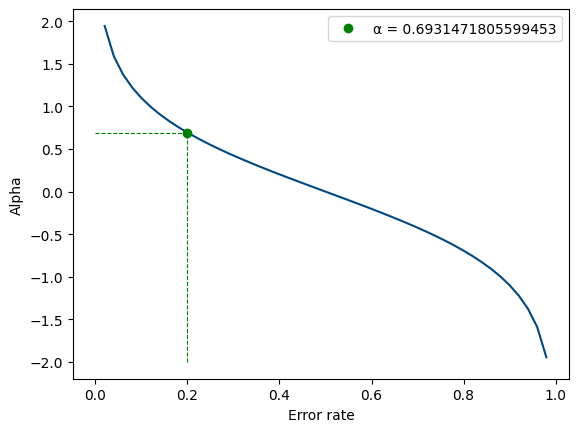

In [36]:
def amountOfSay(totalError):
    a = 0.5 * np.log((1 - totalError) / totalError)
    return a

def plotAmountOfSay(totalError, a):
    # plot the performance curve
    plt.xlabel("Error rate")
    plt.ylabel("Alpha")
    # evenly sampled error rate at 0.02 intervals
    err_rate = np.arange(0.02, 1., 0.02)
    plt.plot(err_rate, 0.5*np.log((1 - err_rate)/err_rate), '#004883')
    # plot our α
    plt.plot([totalError], [a], 'go', label="α = " + str(a))
    x_0_dotted = np.arange(-2, a+0.05, 0.05)
    y_0_dotted = np.arange(0., totalError+0.05, 0.05) if a < 2 else np.arange(0., totalError, 0.05)
    plt.plot(np.zeros(len(x_0_dotted)) + totalError, x_0_dotted, 'g--', linewidth=0.8)
    plt.plot(y_0_dotted, np.zeros(len(y_0_dotted)) + a, 'g--', linewidth=0.8)
    
    plt.legend()
    plt.show()

# calculate totalError
left_error = 0
right_error = 0
# get the error of the left and right child of the stump
if (fstump.left_child.category == 0):
    left_error = fstump.left_child.pos
    right_error = fstump.right_child.neg
else:
    left_error = fstump.left_child.neg
    right_error = fstump.right_child.pos

terror = (left_error + right_error) / (fstump.left_child.total + fstump.right_child.total)
# check if total error is either 0 or 1, if it is add / subtract sys.epsilon so the amount of say equation doesn't freak out
if (terror == 0):
    terror += sys.float_info.epsilon
elif (terror == 1):
    terror -= sys.float_info.epsilon
print("Total Error of " + str(fstump.checking_feature) + " stump:", terror)
# find performance of stump (amount of say: α)
a = amountOfSay(terror)
print("Stump's Importance:", a)
# plot the amount of say
plotAmountOfSay(terror, a)

In [8]:
def newSampleWeights(x, y, sample_w, features, stump, a):
    new_sample_weights = []
    # get index of checking feature and category
    feature_j = features.index(stump.checking_feature)
    category_j = features.index(features[len(features) - 2])

    # get each row and check if it is wrongly classified based on the feature
    for i in range(len(x)):
        n_sample = 0
        # correctly classified
        if ((x[i][feature_j] == 0 and y[i] == stump.left_child.category) or (x[i][feature_j] == 1 and y[i] == stump.right_child.category)):
            n_sample = sample_w[i] * np.exp(-a)
        # wrongly classified
        else:
            n_sample = sample_w[i] * np.exp(a)
        new_sample_weights.append(n_sample)
        
    return new_sample_weights

def normalizeSampleWeights(sample_weights):
    sample_sum = sum(sample_weights)
    for i in range(len(sample_weights)):
        sample_weights[i] = sample_weights[i] / sample_sum

def makeBuckets(sample_weight):
    buckets = []
    buckets.append(sample_weight[0])
    for i in range(1, len(sample_weight), 1):
        buckets.append(buckets[i-1] + sample_weight[i])
    return buckets
        
# make new sample weights based on the right/wrong classifications
new_sample_weights = newSampleWeights(x_train, y_train, sample_w, features, fstump, a)
print("New Sample Weights:", new_sample_weights)
# normalize new sample weights
normalizeSampleWeights(new_sample_weights)
print("New Normalized Sample Weights:", new_sample_weights)
# make buckets
buckets = makeBuckets(new_sample_weights)
print("Buckets:", buckets)

# make deep copy of the dataframe
temp_df = df.copy(True)

temp_df["New sample weights"] = new_sample_weights
temp_df["Buckets"] = buckets
display(temp_df)

New Sample Weights: [0.028867513459481287, 0.028867513459481287, 0.028867513459481287, 0.028867513459481287, 0.08660254037844388, 0.028867513459481287, 0.028867513459481287, 0.028867513459481287, 0.028867513459481287, 0.028867513459481287, 0.08660254037844388, 0.028867513459481287, 0.028867513459481287, 0.028867513459481287, 0.028867513459481287, 0.08660254037844388, 0.028867513459481287, 0.08660254037844388, 0.028867513459481287, 0.08660254037844388]
New Normalized Sample Weights: [0.03333333333333334, 0.03333333333333334, 0.03333333333333334, 0.03333333333333334, 0.10000000000000003, 0.03333333333333334, 0.03333333333333334, 0.03333333333333334, 0.03333333333333334, 0.03333333333333334, 0.10000000000000003, 0.03333333333333334, 0.03333333333333334, 0.03333333333333334, 0.03333333333333334, 0.10000000000000003, 0.03333333333333334, 0.10000000000000003, 0.03333333333333334, 0.10000000000000003]
Buckets: [0.03333333333333334, 0.06666666666666668, 0.10000000000000002, 0.13333333333333336

101  102  103  104  105  106  107  108  109  110  ...  295  296  297  298  \
0   0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
5   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
6   0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  0.0   
10  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
11  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  ...  0.0  0.0  0.0  0.0   
12  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  0.0   
14  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0   
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
16  1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
17  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
18  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
19  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0   

    299  300  Positive  Sample weights  New sample weights   Buckets  
0   0.0  0.0         0            0.05            0.033333  0.033333  
1   0.0  0.0         0            0.05            0.033333  0.066667  
2   0.0  0.0         0            0.05            0.033333  0.100000  
3   0.0  0.0         0            0.05            0.033333  0.133333  
4   0.0  0.0         1            0.05            0.100000  0.233333  
5   0.0  0.0         0            0.05            0.033333  0.266667  
6   0.0  0.0         0            0.05            0.033333  0.300000  
7   0.0  0.0         0            0.05            0.033333  0.333333  
8   0.0  0.0         0            0.05            0.033333  0.366667  
9   0.0  0.0         0            0.05            0.033333  0.400000  
10  0.0  0.0         1            0.05            0.100000  0.500000  
11  0.0  0.0         1            0.05            0.033333  0.533333  
12  0.0  0.0         0            0.05            0.033333  0.566667  
13  0.0  0.0         0            0.05            0.033333  0.600000  
14  0.0  0.0         1            0.05            0.033333  0.633333  
15  0.0  0.0         1            0.05            0.100000  0.733333  
16  0.0  0.0         0            0.05            0.033333  0.766667  
17  0.0  0.0         1            0.05            0.100000  0.866667  
18  0.0  0.0         0            0.05            0.033333  0.900000  
19  0.0  0.0         1            0.05            0.100000  1.000000  

[20 rows x 204 columns]

In [9]:
rigged_rand = [0.38, 0.26, 0.98, 0.40, 0.55, 0.1, 0.22, 0.35, 0.68, 0.15] # Rigged random numbers (debugging)

def makeNewDF(template, x, y, features, rows):
    new_x = []
    new_y = []
    new_sample_w = [1/rows for i in range(rows)]
    features = features[:len(features)-2:1]
    # for each row in the new data set
    for i in range(rows):
        rand_num = random.uniform(0, 1)
        #print(rand_num)
        # choose a row from the old data set
        for j in range(rows):
            if (rand_num < template["Buckets"][j]):
                new_x.append(x[j])
                new_y.append(y[j])
                break
                
    return createDF(new_x, new_y, new_sample_w, features)
            
# make new data frame with the size of the original
# we each row we will generate a random number and having the "Buckets" columns as a distribution, wherever the
# radnom number falls in the "Buckets" column we will take that row and add it to the new data frame
result = makeNewDF(temp_df, x_train, y_train, features, len(y_train))
new_df = result[0]
new_x_train, new_y_train = result[1], result[2]
display(new_df)
    

101  102  103  104  105  106  107  108  109  110  ...  293  294  295  296  \
0   0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1   1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4   0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
5   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
8   1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
9   1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
10  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  0.0   
12  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  0.0   
14  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
15  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
16  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0   
17  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
18  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
19  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0   

    297  298  299  300  Positive  Sample weights  
0   0.0  0.0  0.0  0.0         0            0.05  
1   0.0  0.0  0.0  0.0         1            0.05  
2   0.0  0.0  0.0  0.0         0            0.05  
3   0.0  0.0  0.0  0.0         0            0.05  
4   0.0  0.0  0.0  0.0         1            0.05  
5   0.0  0.0  0.0  0.0         0            0.05  
6   0.0  0.0  0.0  0.0         1            0.05  
7   0.0  0.0  0.0  0.0         1            0.05  
8   0.0  0.0  0.0  0.0         1            0.05  
9   0.0  0.0  0.0  0.0         1            0.05  
10  0.0  0.0  0.0  0.0         1            0.05  
11  0.0  0.0  0.0  0.0         0            0.05  
12  0.0  0.0  0.0  0.0         0            0.05  
13  0.0  0.0  0.0  0.0         0            0.05  
14  0.0  0.0  0.0  0.0         0            0.05  
15  0.0  0.0  0.0  0.0         0            0.05  
16  0.0  0.0  0.0  0.0         1            0.05  
17  0.0  0.0  0.0  0.0         1            0.05  
18  0.0  0.0  0.0  0.0         0            0.05  
19  0.0  0.0  0.0  0.0         1            0.05  

[20 rows x 202 columns]

In [10]:
class Adaboost:
    def __init__(self, n_estimators=5, _print=True):
        self.n_estimators = n_estimators
        self._print = _print # print process (yes / no)
        self.x_train = None
        self.y_train = None
        self.sample_w = None
        self.features = None
        self.df = None
        self.dfs = []
        self.chosen_stump = None
        self.chosen_stumps = []
        self.chosen_stump_a = None
        self.chosen_stumps_a = []
        self.terrors = []

    def fit(self, x, y, features):
        self.x_train = x
        self.y_train = y
        n = len(self.y_train)
        self.sample_w = [1/n for i in range(n)]
        self.features = features
        self.df = createDF(self.x_train, self.y_train, self.sample_w, self.features)[0]
        for i in range(self.n_estimators):
            if (self._print):
                display(self.df)
            self.train()
            if (self._print):
                print(10*"----------")
        
    def train(self):
        _igs = []
        for s in range(len(self.features) - 2):
            feature_values = [self.x_train[i][s] for i in range(len(self.x_train))]
            category_vector = list(self.y_train)
            ig = informationGain(category_vector, feature_values)
            _igs.append(ig)
            if (self._print):
                print("IG:", ig, "\n")

        # find max IG
        _max_ig_i = np.where(_igs == max(_igs))[0][0]

        # make stump
        self.chosen_stump = makeStump(self.x_train, self.y_train, self.features, _max_ig_i)
        if (self._print):
            print("Choosing stump hosting feature: (" + str(self.chosen_stump.checking_feature) + ", " + imdb.getInvertedWordIndex(self.chosen_stump.checking_feature) + ")")

        if (self._print):
            print("Choosing stump hosting feature: (" + str(self.chosen_stump.checking_feature) + ", " + imdb.getInvertedWordIndex(self.chosen_stump.checking_feature) + ")")
            print("Not in review", "\n P:", self.chosen_stump.left_child.pos, "\tΝ:", self.chosen_stump.left_child.neg, "\tT:", int(self.chosen_stump.left_child.total), "\tC:", self.chosen_stump.left_child.category)
            print("In review", "\n P:", self.chosen_stump.right_child.pos, "\tN:", self.chosen_stump.right_child.neg, "\tT:", int(self.chosen_stump.right_child.total), "\tC:", self.chosen_stump.right_child.category)
            print()
        self.chosen_stumps.append(self.chosen_stump)
        
        # calculate totalError
        left_error = 0
        right_error = 0
        # get the error of the left and right child of the stump
        if (self.chosen_stump.left_child.category == 0):
            left_error = self.chosen_stump.left_child.pos
            right_error = self.chosen_stump.right_child.neg
        else:
            left_error = self.chosen_stump.left_child.neg
            right_error = self.chosen_stump.right_child.pos

        _terror = (left_error + right_error) / (self.chosen_stump.left_child.total + self.chosen_stump.right_child.total)
        # check if total error is either 0 or 1, if it is add / subtract sys.epsilon so the amount of say equation doesn't freak out
        if (_terror == 0):
            _terror += sys.float_info.epsilon
        elif (_terror == 1):
            _terror -= sys.float_info.epsilon

        self.terrors.append(_terror)

        # find performance of stump (amount of say: α)
        self.chosen_stump_a = amountOfSay(_terror)
        self.chosen_stumps_a.append(self.chosen_stump_a)

        if (self._print):
            print("Total Error of " + str(self.chosen_stump.checking_feature) + " stump:", _terror)
            print("Stump's Importance:", self.chosen_stump_a)
            # plot the amount of say
            plotAmountOfSay(_terror, self.chosen_stump_a)
        
        # make new sample weights based on the right/wrong classifications
        _new_sample_weights = newSampleWeights(self.x_train, self.y_train, self.sample_w, self.features, self.chosen_stump, self.chosen_stump_a)
        if (self._print):
            print("New Sample Weights:", _new_sample_weights)
        # normalize new sample weights
        normalizeSampleWeights(_new_sample_weights)
        # make buckets
        _buckets = makeBuckets(_new_sample_weights)
        if (self._print):
            print("New Normalized Sample Weights:", _new_sample_weights)
            print("Buckets:", buckets)
        
        self.df["New sample weights"] = _new_sample_weights
        self.df["Buckets"] = _buckets
        if (self._print):
            display(self.df)
        
        # make new data frame with the size of the original
        # we each row we will generate a random number and having the "Buckets" columns as a distribution, wherever the
        # radnom number falls in the "Buckets" column we will take that row and add it to the new data frame
        self.dfs.append(self.df)
        n = len(self.df)
        new_data_frame = makeNewDF(self.df, self.x_train, self.y_train, self.features, n)
        self.df, self.x_train, self.y_train = new_data_frame[0], new_data_frame[1], new_data_frame[2]
        self.sample_w = [1/n for i in range(n)]

    def predict(self, X, cap, features):
        if (features != self.features):
            print("Features of given don't match")
            return
        
        predictions = list()
        probas = list()
        tempX = X[:cap]
        
        # for every x in X
        for x in tempX:
            positive_votes = list()
            positive_proba = list()
            negative_votes = list()
            negative_proba = list()
            # for every stump in the stump forest
            for i in range(len(self.chosen_stumps)):
                # stump
                stump = self.chosen_stumps[i]
                # what are we checking in this stump
                checking_word = stump.checking_feature
                # check if the word exists in the given x
                if (checking_word in x):
                    # then go to right_child
                    # if the category is negative
                    if (stump.right_child.category == 0):
                        negative_votes.append(self.chosen_stumps_a[i])
                        negative_proba.append(1 - self.terrors[i])
                    # if the category is positive
                    else:
                        positive_votes.append(self.chosen_stumps_a[i])
                        positive_proba.append(1 - self.terrors[i])
                # if it doesn't exist in x
                else:
                    # then go to left child
                    # if the category is negative
                    if (stump.left_child.category == 0):
                        negative_votes.append(self.chosen_stumps_a[i])
                        negative_proba.append(1 - self.terrors[i])
                    # if the category is positive
                    else:
                        positive_votes.append(self.chosen_stumps_a[i])
                        positive_proba.append(1 - self.terrors[i])
            # check which has the biggest sum
            #print("\nP:", positive_votes, "\nN:", negative_votes)
            #print("Sum(P):", sum(positive_votes), "\tSum(N):", sum(negative_votes))
            #print(sum(positive_votes), "\n", sum(negative_votes))
            # positive
            if (sum(positive_votes) >= sum(negative_votes)):
                predictions.append(1)
                probas.append(sum(positive_proba) / len(positive_proba))
            # negative
            else:
                predictions.append(0)
                probas.append(sum(negative_proba) / len(negative_proba))

        return predictions, probas


    

In [27]:
'''
# print the reviews of 1000 movies
for i in range(1000):
    print("["+str(i)+"]:", imdb.getDecodedSequence(real[1][0], i))
'''

def runTest(N=250, M=10000, REVIEWS=1000, TESTS=1000, ESTIMATORS=12):
    res = imdb.getTrainingData(1, 2, 3, N, M, 2000)
    train, test = res[0], res[1]
    actual = test[1][:TESTS]
    #print("Actual reviews:", actual)

    # get feature vector
    features = imdb.getFeatureVector(N, M)

    # get values of each feature for n movie reviews
    n = REVIEWS
    x_train = np.zeros((n, len(features)))
    y_train = list()
    # for the first n reviews
    for i in range(n):
        x_i = imdb.getXtrain(i)
        y_train.append(imdb.getYtrain(i))
        # for word index in x_train
        for wi in x_i:
            if wi == 2:
                continue
            elif (wi in features):
                j = features.index(wi)
                x_train[i][j] = 1

    adaboost = Adaboost(n_estimators=ESTIMATORS, _print=True)
    adaboost.fit(x_train, y_train, features)

    # test
    predictions_train, _ = adaboost.predict(x_train, TESTS, features)
    predictions, probas = adaboost.predict(test[0], TESTS, features)
    #print(predictions)
    '''
    error = []
    for i in range(TESTS):
        error.append(abs(actual[i] - predictions[i]))
    print(1 - sum(error) / len(error))
    '''

    accuracy_score_test = sklearn.metrics.accuracy_score(y_pred=predictions, y_true=actual)
    accuracy_score_train = sklearn.metrics.accuracy_score(y_pred=predictions_train, y_true=y_train[:TESTS])
    precision_score, recall_score, threshold = sklearn.metrics.precision_recall_curve(y_true=actual, probas_pred=probas)
    #print(precision_score, recall_score, threshold)
    #precision_score = sklearn.metrics.precision_score(y_pred=predictions, y_true=actual)
    #recall_score = sklearn.metrics.recall_score(y_pred=predictions, y_true=actual)
    fscore = sklearn.metrics.f1_score(y_pred=predictions, y_true=actual)

    #sklearn.metrics.PrecisionRecallDisplay.from_predictions(y_true=actual, y_pred=predictions) # call show later

    return accuracy_score_test, accuracy_score_train, precision_score, recall_score, fscore



251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
397  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.0010880056957387474 

IG: 0.002476294975099713 

IG: 0.03263517188716758 

IG: 0.0011471803867976194 

IG: 0.001321280254525381 

IG: 0.0017734346120067412 

IG: 0.0015360625173995723 

IG: 0.0029443529200692264 

IG: 5.781264357052063e-05 

IG: 2.4277392925209362e-05 

IG: 0.0012717037967050482 

IG: 0.0036865777751979856 

IG: 0.0003936349332903655 

IG: 0.005858750172594962 

IG: 0.0016506363096491228 

IG: 0.003308396458296392 

IG: 0.001446993829180121 

IG: 0.008068354956475843 

IG: 0.0004395256821523308 

IG: 0.000773654296177706 

IG: 5.781264357052063e-05 

IG: 0.006384787589007401 

IG: 0.00010111379512445229 

IG: 0.002683366360802464 

IG: 0.0007517958963767502 

IG: 0.0012717037967050482 

IG: 0.00045412034543368396 

IG: 0.019952003803641483 

IG: 0.007478758463635882 

IG: 0.003891424645865671 

IG: 0.0017304157829541866 

IG: 0.008754819600334529 

IG: 0.002095514236949758 

IG: 0.0024945379444932803 

IG: 2.6810046135916643e-05 

IG: 0.005858750172594962 

IG: 2

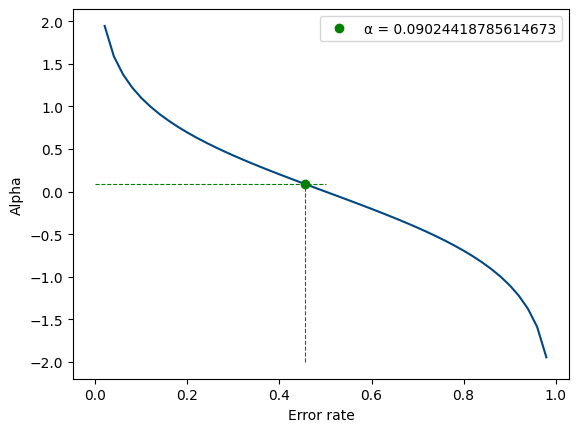

New Sample Weights: [0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002284270104050062, 0.002284270104050062, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002736103751005019, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002284270104050062, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002284270104050062, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002284270104050062, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002284270

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
397  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.002294  0.002294  
1     0.0   0.0   0.0         0          0.0025            0.002747  0.005041  
2     0.0   0.0   0.0         0          0.0025            0.002747  0.007788  
3     0.0   0.0   0.0         1          0.0025            0.002294  0.010082  
4     0.0   0.0   0.0         0          0.0025            0.002747  0.012829  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.002747  0.989918  
396   0.0   0.0   0.0         1          0.0025            0.002294  0.992212  
397   0.0   0.0   0.0         1          0.0025            0.002294  0.994505  
398   0.0   0.0   0.0         0          0.0025            0.002747  0.997253  
399   0.0   0.0   0.0         0          0.0025            0.002747  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.00011494014719415357 

IG: 2.6012159298538506e-05 

IG: 0.028158394497899475 

IG: 8.518850884531304e-05 

IG: 0.0008769236390642199 

IG: 0.0014194138857542837 

IG: 0.0029454762899179254 

IG: 0.015220203412775524 

IG: 0.005601599747362074 

IG: 0.00024448825749434633 

IG: 0.018623399587376244 

IG: 0.01840219498294582 

IG: 0.0011387478243886084 

IG: 3.498200651375072e-08 

IG: 0.0001514277161955846 

IG: 0.0029455655580166162 

IG: 0.0024403604965240744 

IG: 0.0027098753881357185 

IG: 0.0014402365191182875 

IG: 0.002225543587030532 

IG: 0.0001064085355448885 

IG: 0.015398718469992745 

IG: 0.0011387478243886084 

IG: 0.003499496111982414 

IG: 0.006997122427746527 

IG: 0.00026241501727941596 

IG: 0.005055586754356467 

IG: 0.03348576629918254 

IG: 0.00619134083810069 

IG: 0.009960180455605205 

IG: 0.001204297152776368 

IG: 0.010572096606261794 

IG: 0.0037980210653864033 

IG: 0.0015765890415033734 

IG: 0.007247003342827907 

IG: 0.019707103644995394 

IG: 3.58

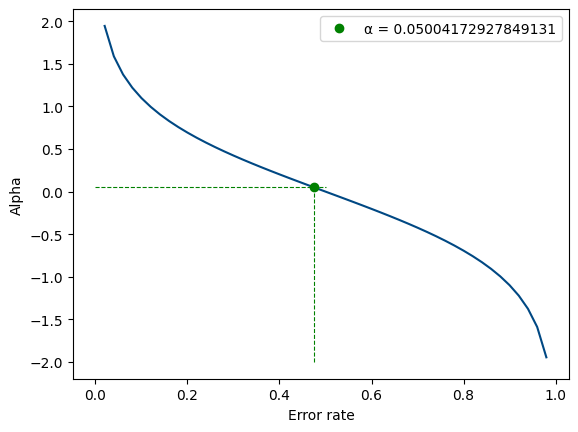

New Sample Weights: [0.0026282874151892345, 0.0023779743280283546, 0.0026282874151892345, 0.0026282874151892345, 0.0023779743280283546, 0.0026282874151892345, 0.0023779743280283546, 0.0023779743280283546, 0.0023779743280283546, 0.0026282874151892345, 0.0026282874151892345, 0.0023779743280283546, 0.0023779743280283546, 0.0026282874151892345, 0.0026282874151892345, 0.0023779743280283546, 0.0026282874151892345, 0.0023779743280283546, 0.0023779743280283546, 0.0023779743280283546, 0.0026282874151892345, 0.0026282874151892345, 0.0023779743280283546, 0.0023779743280283546, 0.0026282874151892345, 0.0026282874151892345, 0.0023779743280283546, 0.0026282874151892345, 0.0026282874151892345, 0.0023779743280283546, 0.0026282874151892345, 0.0023779743280283546, 0.0023779743280283546, 0.0026282874151892345, 0.0023779743280283546, 0.0026282874151892345, 0.0026282874151892345, 0.0026282874151892345, 0.0026282874151892345, 0.0023779743280283546, 0.0023779743280283546, 0.0023779743280283546, 0.00237797432

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.002632  0.002632  
1     0.0   0.0   0.0         1          0.0025            0.002381  0.005013  
2     0.0   0.0   0.0         0          0.0025            0.002632  0.007644  
3     0.0   0.0   0.0         0          0.0025            0.002632  0.010276  
4     0.0   0.0   0.0         0          0.0025            0.002381  0.012657  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.002632  0.989724  
396   0.0   0.0   0.0         0          0.0025            0.002632  0.992356  
397   0.0   0.0   0.0         0          0.0025            0.002632  0.994987  
398   0.0   0.0   0.0         0          0.0025            0.002632  0.997619  
399   0.0   0.0   0.0         0          0.0025            0.002381  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         1          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 0.0007879095797773683 

IG: 0.0032366067484418393 

IG: 0.015986648847067464 

IG: 0.00022248332481300537 

IG: 0.002518710177043304 

IG: 0.0002893450697462052 

IG: 8.756621764571815e-05 

IG: 0.04893261016734418 

IG: 0.001936990382450765 

IG: 0.00021783178929524194 

IG: 0.020665113445572647 

IG: 0.016266303417565964 

IG: 0.00475319319558043 

IG: 0.0016085180785638808 

IG: 0.002121232450017718 

IG: 0.010381729172532328 

IG: 0.028585356620541624 

IG: 0.012356061962309095 

IG: 0.0007194922133646475 

IG: 0.00045868039341190325 

IG: 0.0005190387552668208 

IG: 0.043229963057604404 

IG: 0.0006770266946923842 

IG: 0.004110015816282786 

IG: 0.004176402291944492 

IG: 0.000520000958723621 

IG: 0.0009260398589180374 

IG: 0.0330440136234873 

IG: 0.007997585377796157 

IG: 0.01749333320164348 

IG: 3.0596106659119826e-05 

IG: 0.03069365871480978 

IG: 0.006339447882185989 

IG: 0.001980835255954494 

IG: 0.033292443522817905 

IG: 0.011595534949856101 

IG: 0.00064472867

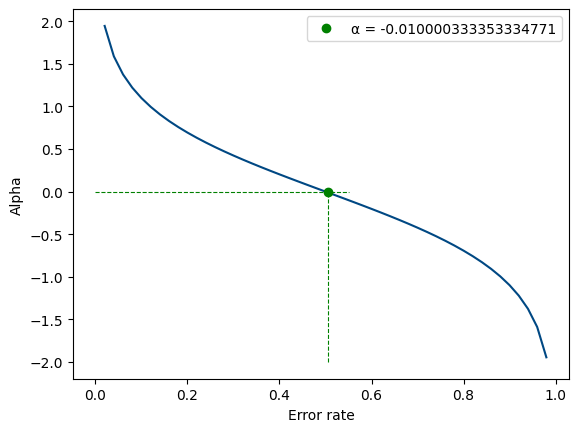

New Sample Weights: [0.0024751237592820236, 0.002525126259469539, 0.002525126259469539, 0.002525126259469539, 0.002525126259469539, 0.002525126259469539, 0.0024751237592820236, 0.0024751237592820236, 0.002525126259469539, 0.0024751237592820236, 0.002525126259469539, 0.002525126259469539, 0.002525126259469539, 0.002525126259469539, 0.002525126259469539, 0.002525126259469539, 0.002525126259469539, 0.002525126259469539, 0.002525126259469539, 0.002525126259469539, 0.0024751237592820236, 0.002525126259469539, 0.0024751237592820236, 0.0024751237592820236, 0.002525126259469539, 0.002525126259469539, 0.0024751237592820236, 0.002525126259469539, 0.0024751237592820236, 0.0024751237592820236, 0.002525126259469539, 0.0024751237592820236, 0.0024751237592820236, 0.0024751237592820236, 0.002525126259469539, 0.0024751237592820236, 0.002525126259469539, 0.0024751237592820236, 0.002525126259469539, 0.0024751237592820236, 0.002525126259469539, 0.0024751237592820236, 0.0024751237592820236, 0.0024751237592

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.002475  0.002475  
1     0.0   0.0   0.0         1          0.0025            0.002525  0.005001  
2     0.0   0.0   0.0         1          0.0025            0.002525  0.007526  
3     0.0   0.0   0.0         1          0.0025            0.002525  0.010051  
4     0.0   0.0   0.0         1          0.0025            0.002525  0.012576  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.002525  0.989999  
396   0.0   0.0   0.0         0          0.0025            0.002475  0.992474  
397   0.0   0.0   0.0         1          0.0025            0.002525  0.994999  
398   0.0   0.0   0.0         0          0.0025            0.002475  0.997475  
399   0.0   0.0   0.0         1          0.0025            0.002525  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
3    1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  ...   0.0   0.0   0.0   
396  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         1          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 0.000544223284915768 

IG: 0.009275360495269003 

IG: 0.028158394497899475 

IG: 0.0006329978113394086 

IG: 0.0018681510679480207 

IG: 0.0016763429256122508 

IG: 0.0003851030343203776 

IG: 0.08711752633296621 

IG: 0.0028237674568859505 

IG: 0.0028151203444979345 

IG: 0.029267949835203422 

IG: 0.010617037550858743 

IG: 0.010747113801983565 

IG: 0.003842208129639868 

IG: 0.0010347659282888833 

IG: 0.010918062512902393 

IG: 0.027463355922047517 

IG: 0.01771119877300753 

IG: 0.0008769236390642199 

IG: 0.0006161152402216485 

IG: 0.016786869320615905 

IG: 0.06320188695033391 

IG: 4.405998854983828e-06 

IG: 0.008774814189212776 

IG: 0.0071380279178601125 

IG: 0.003842208129639868 

IG: 0.002120850142212305 

IG: 0.04417439391436084 

IG: 0.018127301389192274 

IG: 0.023089865719958302 

IG: 0.002159179412263623 

IG: 0.04225195594126463 

IG: 0.0014194138857542837 

IG: 0.004564146211484266 

IG: 0.06688736639996173 

IG: 0.040788728690464904 

IG: 0.0037403848557462

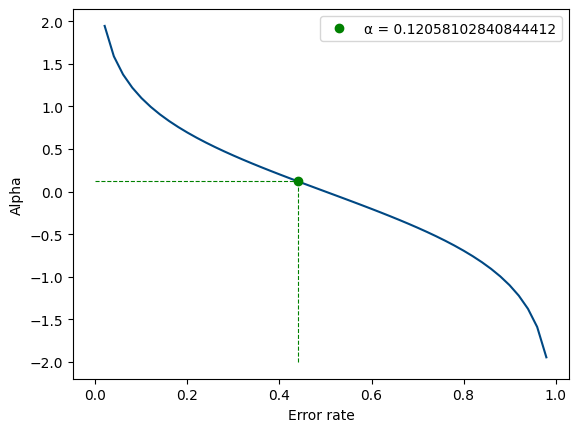

New Sample Weights: [0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.002820380374088831, 0.002820380374088831, 0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.0022160131510697957, 0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.002820380

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
3    1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  ...   0.0   0.0   0.0   
396  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.002841  0.002841  
1     0.0   0.0   0.0         0          0.0025            0.002841  0.005682  
2     0.0   0.0   0.0         1          0.0025            0.002232  0.007914  
3     0.0   0.0   0.0         0          0.0025            0.002841  0.010755  
4     0.0   0.0   0.0         1          0.0025            0.002232  0.012987  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.002232  0.990463  
396   0.0   0.0   0.0         1          0.0025            0.002232  0.992695  
397   0.0   0.0   0.0         0          0.0025            0.002841  0.995536  
398   0.0   0.0   0.0         1          0.0025            0.002232  0.997768  
399   0.0   0.0   0.0         1          0.0025            0.002232  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 8.488033742581891e-05 

IG: 0.011317196893129267 

IG: 0.027175032336704374 

IG: 0.0015670807064038783 

IG: 0.004410228252727966 

IG: 0.0005189553776830946 

IG: 0.00027580333292398507 

IG: 0.06432355897720299 

IG: 0.008830539195325393 

IG: 0.0014826250851196487 

IG: 0.042530672106972034 

IG: 0.006567034956623585 

IG: 0.004525363520859638 

IG: 0.006465860542780311 

IG: 5.994399877251588e-05 

IG: 0.01115060679968205 

IG: 0.026013028394467952 

IG: 0.02741318518368785 

IG: 0.0005607368703353099 

IG: 0.0003131121231371159 

IG: 0.007671156961810532 

IG: 0.06834951683638524 

IG: 0.00010057096280025046 

IG: 0.015428077678520835 

IG: 0.01507125913140972 

IG: 0.005960362304115008 

IG: 0.0003092970167720699 

IG: 0.085146477673818 

IG: 0.013060411790814852 

IG: 0.011468895202294216 

IG: 0.007964741216503701 

IG: 0.05016093755139284 

IG: 0.002335007308180259 

IG: 0.005655201747206018 

IG: 0.06585451317217461 

IG: 0.03026247174302743 

IG: 0.00011283329795275243 

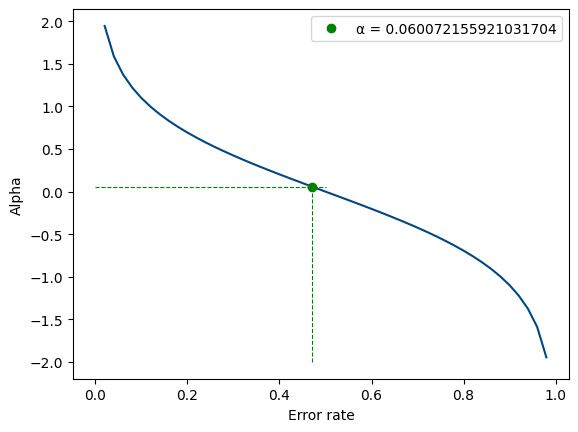

New Sample Weights: [0.0026547829177591027, 0.0026547829177591027, 0.0026547829177591027, 0.002354241455371279, 0.002354241455371279, 0.002354241455371279, 0.002354241455371279, 0.002354241455371279, 0.002354241455371279, 0.002354241455371279, 0.0026547829177591027, 0.002354241455371279, 0.0026547829177591027, 0.002354241455371279, 0.0026547829177591027, 0.0026547829177591027, 0.002354241455371279, 0.0026547829177591027, 0.002354241455371279, 0.0026547829177591027, 0.002354241455371279, 0.002354241455371279, 0.0026547829177591027, 0.002354241455371279, 0.0026547829177591027, 0.002354241455371279, 0.0026547829177591027, 0.002354241455371279, 0.0026547829177591027, 0.0026547829177591027, 0.0026547829177591027, 0.0026547829177591027, 0.0026547829177591027, 0.0026547829177591027, 0.002354241455371279, 0.002354241455371279, 0.0026547829177591027, 0.0026547829177591027, 0.0026547829177591027, 0.002354241455371279, 0.0026547829177591027, 0.002354241455371279, 0.0026547829177591027, 0.00265478

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.002660  0.002660  
1     0.0   0.0   0.0         0          0.0025            0.002660  0.005319  
2     0.0   0.0   0.0         0          0.0025            0.002660  0.007979  
3     0.0   0.0   0.0         1          0.0025            0.002358  0.010337  
4     0.0   0.0   0.0         1          0.0025            0.002358  0.012696  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.002660  0.989964  
396   0.0   0.0   0.0         1          0.0025            0.002358  0.992322  
397   0.0   0.0   0.0         1          0.0025            0.002358  0.994681  
398   0.0   0.0   0.0         0          0.0025            0.002660  0.997340  
399   0.0   0.0   0.0         0          0.0025            0.002660  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         1          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 0.002701717735546616 

IG: 0.02096004928328976 

IG: 0.030251677816591216 

IG: 2.7462286821045012e-05 

IG: 0.006918665264331936 

IG: 0.006843793890052519 

IG: 0.0011620133327437943 

IG: 0.09108298082565525 

IG: 0.008744533333072013 

IG: 0.0021125117367015722 

IG: 0.043019590707780386 

IG: 7.829007380866226e-05 

IG: 0.006438293865750233 

IG: 2.134604141856844e-05 

IG: 8.535861760672336e-05 

IG: 0.013060411790814852 

IG: 0.02096214165397481 

IG: 0.03397691182626694 

IG: 0.0061036764093617135 

IG: 0.00043087857301016275 

IG: 0.0028126578233984567 

IG: 0.06585451317217461 

IG: 0.004586018390039692 

IG: 0.004760093279525979 

IG: 0.004944557184725973 

IG: 0.004579299675391502 

IG: 0.0018048236574552678 

IG: 0.08475633338519406 

IG: 0.019027494589273886 

IG: 0.015400787707068209 

IG: 0.0051324951694610155 

IG: 0.034989592842799455 

IG: 0.0011511317844272728 

IG: 0.00010892224901937198 

IG: 0.08254599276512853 

IG: 0.017704921314455446 

IG: 0.0002767960879

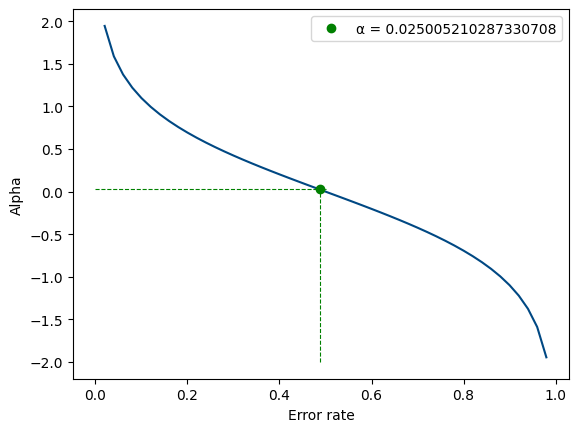

New Sample Weights: [0.0024382620759917325, 0.0025633011568118214, 0.0024382620759917325, 0.0025633011568118214, 0.0025633011568118214, 0.0025633011568118214, 0.0024382620759917325, 0.0025633011568118214, 0.0025633011568118214, 0.0024382620759917325, 0.0025633011568118214, 0.0024382620759917325, 0.0025633011568118214, 0.0024382620759917325, 0.0024382620759917325, 0.0024382620759917325, 0.0025633011568118214, 0.0025633011568118214, 0.0024382620759917325, 0.0024382620759917325, 0.0025633011568118214, 0.0024382620759917325, 0.0025633011568118214, 0.0024382620759917325, 0.0025633011568118214, 0.0024382620759917325, 0.0025633011568118214, 0.0025633011568118214, 0.0024382620759917325, 0.0024382620759917325, 0.0025633011568118214, 0.0025633011568118214, 0.0024382620759917325, 0.0024382620759917325, 0.0025633011568118214, 0.0025633011568118214, 0.0025633011568118214, 0.0025633011568118214, 0.0025633011568118214, 0.0025633011568118214, 0.0024382620759917325, 0.0024382620759917325, 0.00256330115

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.002439  0.002439  
1     0.0   0.0   0.0         0          0.0025            0.002564  0.005003  
2     0.0   0.0   0.0         1          0.0025            0.002439  0.007442  
3     0.0   0.0   0.0         0          0.0025            0.002564  0.010006  
4     0.0   0.0   0.0         0          0.0025            0.002564  0.012570  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.002439  0.989994  
396   0.0   0.0   0.0         0          0.0025            0.002564  0.992558  
397   0.0   0.0   0.0         1          0.0025            0.002439  0.994997  
398   0.0   0.0   0.0         0          0.0025            0.002564  0.997561  
399   0.0   0.0   0.0         1          0.0025            0.002439  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.007555635926172366 

IG: 0.030099481316924415 

IG: 0.07207866774629168 

IG: 0.005930999659871428 

IG: 0.002480503135190437 

IG: 0.011189555352957625 

IG: 0.00022335392345840255 

IG: 0.07005846470230592 

IG: 0.0232079292514199 

IG: 0.0032163009054385627 

IG: 0.031249421414895284 

IG: 4.957342622069483e-05 

IG: 0.012199540197235459 

IG: 0.003443082962545585 

IG: 0.0001473445795944217 

IG: 0.027587978116941247 

IG: 0.016921743930846223 

IG: 0.04659999698052686 

IG: 0.00706329651297366 

IG: 0.0010599085180709178 

IG: 0.004503265738792228 

IG: 0.04982542191818773 

IG: 0.008070045624392286 

IG: 0.0037481988613154993 

IG: 0.004285775990657603 

IG: 0.0005113026692492584 

IG: 0.0009032097181621568 

IG: 0.11776504452334435 

IG: 0.023430110221042355 

IG: 0.028410916615766446 

IG: 0.0009644175082865747 

IG: 0.034853092710508404 

IG: 0.014972915931256492 

IG: 0.00025613813292491017 

IG: 0.08143915528431456 

IG: 0.008416371525471367 

IG: 0.0002246586343194190

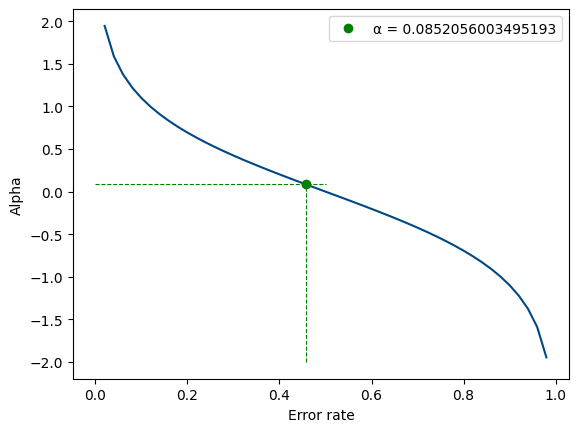

New Sample Weights: [0.0022958086434171597, 0.0022958086434171597, 0.002722352325800676, 0.0022958086434171597, 0.0022958086434171597, 0.0022958086434171597, 0.0022958086434171597, 0.0022958086434171597, 0.0022958086434171597, 0.002722352325800676, 0.0022958086434171597, 0.0022958086434171597, 0.002722352325800676, 0.0022958086434171597, 0.0022958086434171597, 0.0022958086434171597, 0.0022958086434171597, 0.0022958086434171597, 0.0022958086434171597, 0.002722352325800676, 0.002722352325800676, 0.0022958086434171597, 0.0022958086434171597, 0.0022958086434171597, 0.002722352325800676, 0.002722352325800676, 0.002722352325800676, 0.0022958086434171597, 0.002722352325800676, 0.0022958086434171597, 0.0022958086434171597, 0.0022958086434171597, 0.002722352325800676, 0.002722352325800676, 0.0022958086434171597, 0.002722352325800676, 0.002722352325800676, 0.0022958086434171597, 0.0022958086434171597, 0.0022958086434171597, 0.0022958086434171597, 0.0022958086434171597, 0.0022958086434171597, 0.0

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.002304  0.002304  
1     0.0   0.0   0.0         1          0.0025            0.002304  0.004608  
2     0.0   0.0   0.0         0          0.0025            0.002732  0.007341  
3     0.0   0.0   0.0         1          0.0025            0.002304  0.009645  
4     0.0   0.0   0.0         1          0.0025            0.002304  0.011949  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.002732  0.989927  
396   0.0   0.0   0.0         0          0.0025            0.002732  0.992659  
397   0.0   0.0   0.0         1          0.0025            0.002304  0.994964  
398   0.0   0.0   0.0         1          0.0025            0.002304  0.997268  
399   0.0   0.0   0.0         0          0.0025            0.002732  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
398  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.014237525306526222 

IG: 0.03952129172439578 

IG: 0.08523898632325888 

IG: 0.0005734453869297162 

IG: 0.0009357353347063668 

IG: 0.011547252567916 

IG: 2.2712745731956474e-06 

IG: 0.06882765424629034 

IG: 0.027153626919236284 

IG: 0.004186172717139169 

IG: 0.025536968756783907 

IG: 0.00012467456670173238 

IG: 0.01628356812206677 

IG: 0.0290655532182994 

IG: 0.0004917776355922721 

IG: 0.042695200737831285 

IG: 0.029040096073496113 

IG: 0.05430333718353275 

IG: 0.02759445553831541 

IG: 0.0008405528851477273 

IG: 0.0020499736049833794 

IG: 0.03843309678012663 

IG: 0.009717172399411278 

IG: 0.003067258374827242 

IG: 0.009116910231774633 

IG: 0.00127172672511644 

IG: 0.00036578401501130564 

IG: 0.06222746465072393 

IG: 0.008906925754512685 

IG: 0.01617066110280474 

IG: 0.0034466899524450145 

IG: 0.022307145074009993 

IG: 0.017873631075106422 

IG: 0.0006059114415973843 

IG: 0.07067341607287092 

IG: 0.005398125461619219 

IG: 0.010665671473563787 

IG: 

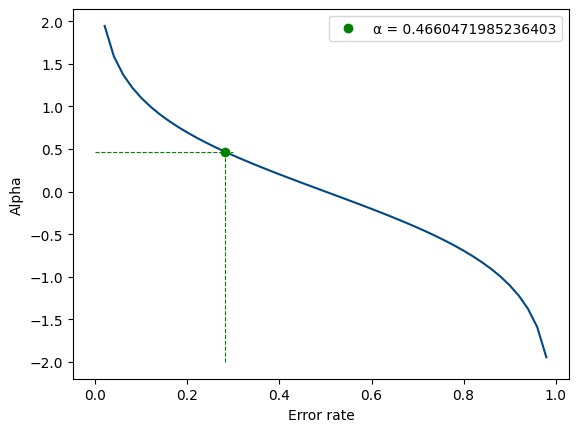

New Sample Weights: [0.0015686941683222461, 0.003984205542552961, 0.003984205542552961, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.003984205542552961, 0.0015686941683222461, 0.003984205542552961, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.003984205542552961, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.003984205542552961, 0.003984205542552961, 0.0015686941683222461, 0.003984205542552961, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.003984205542552961, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.003984205542552961, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
398  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.001742  0.001742  
1     0.0   0.0   0.0         1          0.0025            0.004425  0.006167  
2     0.0   0.0   0.0         0          0.0025            0.004425  0.010592  
3     0.0   0.0   0.0         1          0.0025            0.001742  0.012334  
4     0.0   0.0   0.0         0          0.0025            0.001742  0.014076  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.001742  0.984984  
396   0.0   0.0   0.0         1          0.0025            0.004425  0.989408  
397   0.0   0.0   0.0         1          0.0025            0.004425  0.993833  
398   0.0   0.0   0.0         1          0.0025            0.004425  0.998258  
399   0.0   0.0   0.0         0          0.0025            0.001742  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         1          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.010100332071117712 

IG: 0.03646412985850167 

IG: 0.06152756270844917 

IG: 0.0012952663478640325 

IG: 0.01320333891998482 

IG: 0.01975871310188293 

IG: 0.0010720848274835548 

IG: 0.08778632852655599 

IG: 0.019377478460573694 

IG: 0.003912736646609183 

IG: 0.006033443121442161 

IG: 0.0005240079221888738 

IG: 0.020647368956794643 

IG: 0.03566911498245562 

IG: 0.0008115807767045125 

IG: 0.04626903040901864 

IG: 0.025868792614183622 

IG: 0.10445523820584213 

IG: 0.01562511893898988 

IG: 0.00010361677308390327 

IG: 0.016231346615066422 

IG: 0.048913514836948946 

IG: 0.0008205839999682052 

IG: 0.00121041775229902 

IG: 0.009501639031239573 

IG: 0.0033141113111022635 

IG: 0.012210778513989107 

IG: 0.08112096498294807 

IG: 0.013989649403082005 

IG: 0.03276458974359986 

IG: 0.005405191981744162 

IG: 0.051954960693812446 

IG: 0.012065886972220219 

IG: 0.006216897599686799 

IG: 0.08778632852655599 

IG: 0.004893922675741846 

IG: 0.017421720333089197 

IG: 0.

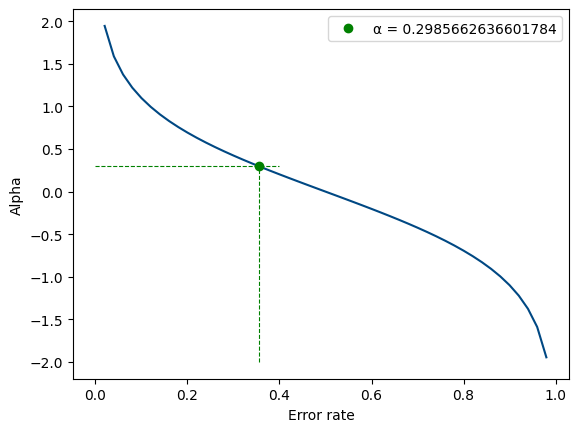

New Sample Weights: [0.0033698121316798808, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0033698121316798808, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0033698121316798808, 0.0033698121316798808, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0033698121316798808, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0033698121316798808, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0033698121316798808, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0033698121316798808, 0.0018547028011571434, 0.0033698121316798808, 0.0018547028011571434, 0.0018547028011571434, 0.0033698121316798808, 0.0033698121316798808, 0.0033698121316798808, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0033698121316798808, 0.00336981213

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.003521  0.003521  
1     0.0   0.0   0.0         1          0.0025            0.001938  0.005459  
2     0.0   0.0   0.0         1          0.0025            0.001938  0.007397  
3     0.0   0.0   0.0         1          0.0025            0.001938  0.009335  
4     0.0   0.0   0.0         0          0.0025            0.003521  0.012856  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.003521  0.987499  
396   0.0   0.0   0.0         0          0.0025            0.003521  0.991020  
397   0.0   0.0   0.0         0          0.0025            0.003521  0.994541  
398   0.0   0.0   0.0         1          0.0025            0.001938  0.996479  
399   0.0   0.0   0.0         0          0.0025            0.003521  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  ...   0.0   0.0   0.0   
399  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.0012595776347315013 

IG: 0.04753317308523586 

IG: 0.06984397254953068 

IG: 6.884100358706124e-05 

IG: 0.016339733645997723 

IG: 0.02910176067749659 

IG: 2.306905020876826e-05 

IG: 0.06062058178370655 

IG: 0.037352744903099144 

IG: 0.007483093750720871 

IG: 0.0046026197555725235 

IG: 0.00014237988112586475 

IG: 0.020403141173809036 

IG: 0.02399296092882941 

IG: 0.004934479143699599 

IG: 0.028302209522940713 

IG: 0.0056935009217844446 

IG: 0.13294412890379537 

IG: 0.027695788682514766 

IG: 5.162271352832093e-06 

IG: 0.005466350559420352 

IG: 0.03975347290829567 

IG: 0.004630424440306147 

IG: 0.006297006801300631 

IG: 0.018843292806956624 

IG: 0.0013868943432823189 

IG: 0.038676404388226726 

IG: 0.1250470580560713 

IG: 0.012034609336656454 

IG: 0.046170033284772205 

IG: 0.007815776347820158 

IG: 0.034670771834533265 

IG: 0.03051187098916508 

IG: 0.005466350559420352 

IG: 0.06535411424131876 

IG: 0.0002604437108136848 

IG: 0.015199033413764607 

IG

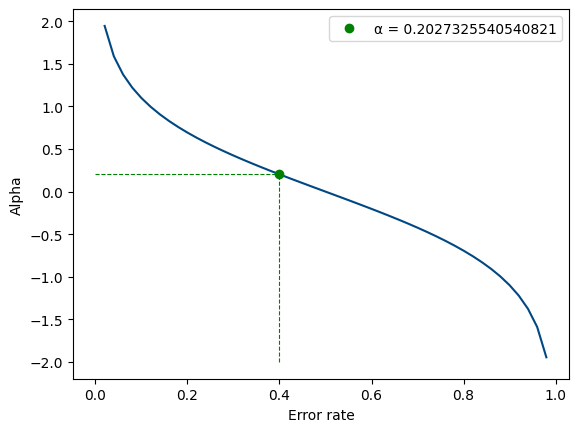

New Sample Weights: [0.0030618621784789723, 0.0020412414523193153, 0.0020412414523193153, 0.0020412414523193153, 0.0020412414523193153, 0.0020412414523193153, 0.0020412414523193153, 0.0030618621784789723, 0.0030618621784789723, 0.0020412414523193153, 0.0020412414523193153, 0.0030618621784789723, 0.0020412414523193153, 0.0030618621784789723, 0.0020412414523193153, 0.0030618621784789723, 0.0020412414523193153, 0.0030618621784789723, 0.0020412414523193153, 0.0030618621784789723, 0.0020412414523193153, 0.0020412414523193153, 0.0020412414523193153, 0.0020412414523193153, 0.0020412414523193153, 0.0020412414523193153, 0.0030618621784789723, 0.0030618621784789723, 0.0030618621784789723, 0.0020412414523193153, 0.0020412414523193153, 0.0020412414523193153, 0.0030618621784789723, 0.0020412414523193153, 0.0020412414523193153, 0.0020412414523193153, 0.0020412414523193153, 0.0030618621784789723, 0.0030618621784789723, 0.0030618621784789723, 0.0020412414523193153, 0.0030618621784789723, 0.00306186217

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  ...   0.0   0.0   0.0   
399  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.003125  0.003125  
1     0.0   0.0   0.0         0          0.0025            0.002083  0.005208  
2     0.0   0.0   0.0         0          0.0025            0.002083  0.007292  
3     0.0   0.0   0.0         0          0.0025            0.002083  0.009375  
4     0.0   0.0   0.0         1          0.0025            0.002083  0.011458  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.003125  0.989583  
396   0.0   0.0   0.0         1          0.0025            0.002083  0.991667  
397   0.0   0.0   0.0         1          0.0025            0.002083  0.993750  
398   0.0   0.0   0.0         0          0.0025            0.003125  0.996875  
399   0.0   0.0   0.0         0          0.0025            0.003125  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
396  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 1.5314630835927545e-05 

IG: 0.007461033957209429 

IG: 0.07142041882121264 

IG: 2.490344323147209e-05 

IG: 0.009550977209694445 

IG: 0.02119687017373495 

IG: 0.0004650807257270406 

IG: 0.038448007320799116 

IG: 0.04777338753010707 

IG: 0.010602088370803453 

IG: 0.015659066067789773 

IG: 0.0005891807639606395 

IG: 0.042254735704242874 

IG: 0.03172983741875712 

IG: 0.026151377638083617 

IG: 0.026774870437262233 

IG: 0.0024382952463911645 

IG: 0.06938100139976422 

IG: 0.020253386247418126 

IG: 0.0002537567109840433 

IG: 0.007159863471939865 

IG: 0.023480840239925027 

IG: 0.0009098701589593805 

IG: 0.012568164341570931 

IG: 0.00185210612059572 

IG: 0.004111581576547452 

IG: 0.06029936312627959 

IG: 0.12860276013163408 

IG: 0.025329482589725894 

IG: 0.08700077698709519 

IG: 0.0452834799476749 

IG: 0.02587555495531846 

IG: 0.02322486055151074 

IG: 2.584383023940262e-05 

IG: 0.055791257812396244 

IG: 0.003043657739768335 

IG: 0.00767397579884066 

IG: 0.

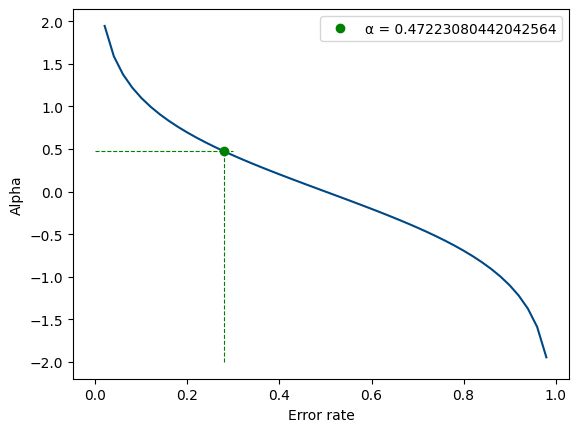

New Sample Weights: [0.001559023911155809, 0.004008918628686365, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.004008918628686365, 0.004008918628686365, 0.001559023911155809, 0.001559023911155809, 0.004008918628686365, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.004008918628686365, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.004008918628686365, 0.004008918628686365, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.004008918628686365, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
396  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.001736  0.001736  
1     0.0   0.0   0.0         1          0.0025            0.004464  0.006200  
2     0.0   0.0   0.0         0          0.0025            0.001736  0.007937  
3     0.0   0.0   0.0         0          0.0025            0.001736  0.009673  
4     0.0   0.0   0.0         0          0.0025            0.001736  0.011409  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.001736  0.987599  
396   0.0   0.0   0.0         1          0.0025            0.004464  0.992063  
397   0.0   0.0   0.0         0          0.0025            0.001736  0.993800  
398   0.0   0.0   0.0         0          0.0025            0.001736  0.995536  
399   0.0   0.0   0.0         1          0.0025            0.004464  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         1          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 0.0077175855154481 

IG: 0.009582299623778434 

IG: 0.0956078697542565 

IG: 0.0005878826122867054 

IG: 0.0022465607062177595 

IG: 0.0033737683344650105 

IG: 0.009193885247443023 

IG: 0.0315836773696645 

IG: 0.05510333855611527 

IG: 0.01089048962945205 

IG: 0.048043494734647973 

IG: 0.00892717919789765 

IG: 0.04967138657422843 

IG: 0.02805663521382762 

IG: 0.01878333278796096 

IG: 0.014051347702236372 

IG: 0.00026004883885977215 

IG: 0.04399338457651136 

IG: 0.010654972699898901 

IG: 0.007111668239997315 

IG: 0.01514616992083384 

IG: 0.01739616295318336 

IG: 0.0033604121209890314 

IG: 6.999081548775266e-07 

IG: 0.0029311292402819378 

IG: 0.0037951718655285793 

IG: 0.04761129143471465 

IG: 0.18042553105767778 

IG: 0.028013688365490008 

IG: 0.13657536466951792 

IG: 0.029688693497250118 

IG: 0.01741818258753436 

IG: 0.03363007490406944 

IG: 0.007399759901731473 

IG: 0.0681696895244539 

IG: 1.7496357384572114e-05 

IG: 0.0014286495198294613 

IG: 0.01847

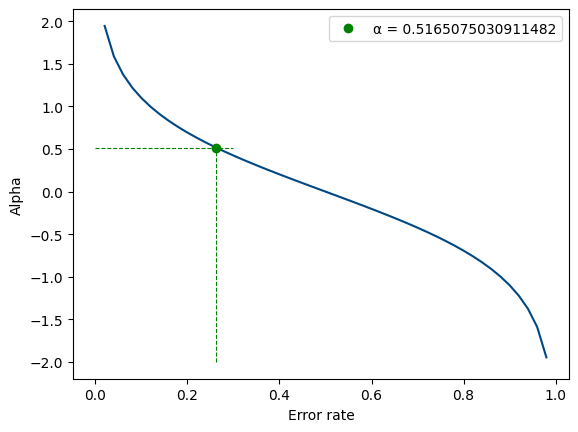

New Sample Weights: [0.004190408549237629, 0.0014915013480337322, 0.0014915013480337322, 0.004190408549237629, 0.0014915013480337322, 0.0014915013480337322, 0.0014915013480337322, 0.004190408549237629, 0.0014915013480337322, 0.0014915013480337322, 0.004190408549237629, 0.004190408549237629, 0.004190408549237629, 0.0014915013480337322, 0.0014915013480337322, 0.0014915013480337322, 0.0014915013480337322, 0.0014915013480337322, 0.0014915013480337322, 0.0014915013480337322, 0.0014915013480337322, 0.0014915013480337322, 0.0014915013480337322, 0.004190408549237629, 0.004190408549237629, 0.0014915013480337322, 0.004190408549237629, 0.004190408549237629, 0.0014915013480337322, 0.0014915013480337322, 0.0014915013480337322, 0.004190408549237629, 0.0014915013480337322, 0.0014915013480337322, 0.0014915013480337322, 0.0014915013480337322, 0.0014915013480337322, 0.004190408549237629, 0.0014915013480337322, 0.0014915013480337322, 0.0014915013480337322, 0.0014915013480337322, 0.0014915013480337322, 0.

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.004762  0.004762  
1     0.0   0.0   0.0         1          0.0025            0.001695  0.006457  
2     0.0   0.0   0.0         1          0.0025            0.001695  0.008152  
3     0.0   0.0   0.0         0          0.0025            0.004762  0.012914  
4     0.0   0.0   0.0         0          0.0025            0.001695  0.014609  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.001695  0.987086  
396   0.0   0.0   0.0         0          0.0025            0.004762  0.991848  
397   0.0   0.0   0.0         0          0.0025            0.004762  0.996610  
398   0.0   0.0   0.0         1          0.0025            0.001695  0.998305  
399   0.0   0.0   0.0         1          0.0025            0.001695  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
397  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.0010880056957387474 

IG: 0.002476294975099713 

IG: 0.03263517188716758 

IG: 0.0011471803867976194 

IG: 0.001321280254525381 

IG: 0.0017734346120067412 

IG: 0.0015360625173995723 

IG: 0.0029443529200692264 

IG: 5.781264357052063e-05 

IG: 2.4277392925209362e-05 

IG: 0.0012717037967050482 

IG: 0.0036865777751979856 

IG: 0.0003936349332903655 

IG: 0.005858750172594962 

IG: 0.0016506363096491228 

IG: 0.003308396458296392 

IG: 0.001446993829180121 

IG: 0.008068354956475843 

IG: 0.0004395256821523308 

IG: 0.000773654296177706 

IG: 5.781264357052063e-05 

IG: 0.006384787589007401 

IG: 0.00010111379512445229 

IG: 0.002683366360802464 

IG: 0.0007517958963767502 

IG: 0.0012717037967050482 

IG: 0.00045412034543368396 

IG: 0.019952003803641483 

IG: 0.007478758463635882 

IG: 0.003891424645865671 

IG: 0.0017304157829541866 

IG: 0.008754819600334529 

IG: 0.002095514236949758 

IG: 0.0024945379444932803 

IG: 2.6810046135916643e-05 

IG: 0.005858750172594962 

IG: 2

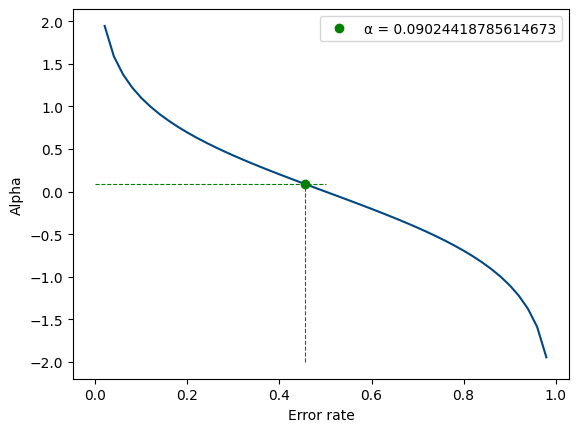

New Sample Weights: [0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002284270104050062, 0.002284270104050062, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002736103751005019, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002284270104050062, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002284270104050062, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002284270104050062, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002284270

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
397  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.002294  0.002294  
1     0.0   0.0   0.0         0          0.0025            0.002747  0.005041  
2     0.0   0.0   0.0         0          0.0025            0.002747  0.007788  
3     0.0   0.0   0.0         1          0.0025            0.002294  0.010082  
4     0.0   0.0   0.0         0          0.0025            0.002747  0.012829  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.002747  0.989918  
396   0.0   0.0   0.0         1          0.0025            0.002294  0.992212  
397   0.0   0.0   0.0         1          0.0025            0.002294  0.994505  
398   0.0   0.0   0.0         0          0.0025            0.002747  0.997253  
399   0.0   0.0   0.0         0          0.0025            0.002747  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.00037145939807881057 

IG: 0.001620918627942003 

IG: 0.007136297959752347 

IG: 7.735668436170684e-05 

IG: 0.002925927341825174 

IG: 0.0119120664898138 

IG: 0.002553696165174535 

IG: 0.0013373964465720478 

IG: 1.9014846139420172e-05 

IG: 0.000882219106863591 

IG: 0.009915790989363904 

IG: 0.011213689333504528 

IG: 0.0008668284461650355 

IG: 0.005629330065019644 

IG: 0.010035883465903006 

IG: 0.00013231724024032054 

IG: 8.145701762884983e-06 

IG: 0.005665690550706426 

IG: 0.011806781037339675 

IG: 0.0020363412476825937 

IG: 0.003829055491744171 

IG: 0.015286890317581237 

IG: 0.00016308574991763525 

IG: 0.006563510858622834 

IG: 0.0005074679908031454 

IG: 0.00568292879300647 

IG: 0.0037596082573477796 

IG: 0.023855905440176572 

IG: 0.016325255175193454 

IG: 0.0020010544499150518 

IG: 0.004120485751449077 

IG: 0.030328609295759756 

IG: 0.015606110519136185 

IG: 0.002773693557882595 

IG: 0.0011132367734666415 

IG: 0.01309099666066571 

IG: 0.002479898

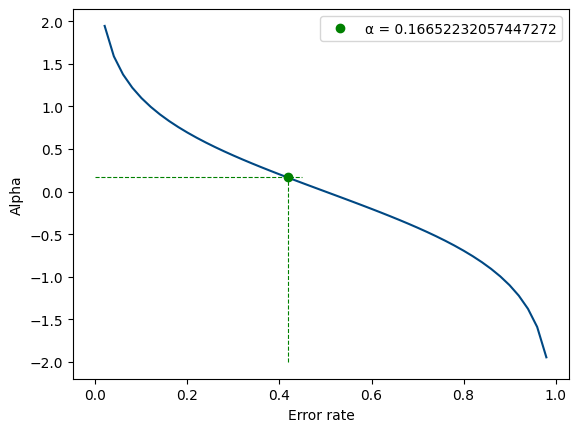

New Sample Weights: [0.0029529747510331885, 0.0021165098000967488, 0.0021165098000967488, 0.0021165098000967488, 0.0021165098000967488, 0.0029529747510331885, 0.0021165098000967488, 0.0029529747510331885, 0.0029529747510331885, 0.0021165098000967488, 0.0021165098000967488, 0.0029529747510331885, 0.0021165098000967488, 0.0029529747510331885, 0.0021165098000967488, 0.0029529747510331885, 0.0021165098000967488, 0.0021165098000967488, 0.0021165098000967488, 0.0029529747510331885, 0.0029529747510331885, 0.0029529747510331885, 0.0029529747510331885, 0.0021165098000967488, 0.0021165098000967488, 0.0029529747510331885, 0.0029529747510331885, 0.0021165098000967488, 0.0021165098000967488, 0.0021165098000967488, 0.0029529747510331885, 0.0021165098000967488, 0.0029529747510331885, 0.0021165098000967488, 0.0021165098000967488, 0.0021165098000967488, 0.0021165098000967488, 0.0021165098000967488, 0.0021165098000967488, 0.0021165098000967488, 0.0021165098000967488, 0.0021165098000967488, 0.00211650980

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.002994  0.002994  
1     0.0   0.0   0.0         0          0.0025            0.002146  0.005140  
2     0.0   0.0   0.0         0          0.0025            0.002146  0.007286  
3     0.0   0.0   0.0         0          0.0025            0.002146  0.009432  
4     0.0   0.0   0.0         0          0.0025            0.002146  0.011578  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.002994  0.990568  
396   0.0   0.0   0.0         0          0.0025            0.002146  0.992714  
397   0.0   0.0   0.0         1          0.0025            0.002994  0.995708  
398   0.0   0.0   0.0         0          0.0025            0.002146  0.997854  
399   0.0   0.0   0.0         0          0.0025            0.002146  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 9.077120542100303e-06 

IG: 0.0023454278670030915 

IG: 0.005890739294264313 

IG: 0.001184396311109892 

IG: 0.01363566213958034 

IG: 0.006232677624756544 

IG: 0.009531451857763051 

IG: 0.0039454511553072 

IG: 0.0016828167419242757 

IG: 0.0024766929917138247 

IG: 0.0033391703364327174 

IG: 0.011604983928480417 

IG: 0.0033391703364327174 

IG: 0.010173077415107867 

IG: 0.021070278023324285 

IG: 0.0016319682803568325 

IG: 1.0360025694655661e-05 

IG: 0.03642428304760181 

IG: 0.008851351616951053 

IG: 0.012970669579296601 

IG: 0.00528583066862387 

IG: 0.02622877225638698 

IG: 0.008705433153693987 

IG: 0.03305575831209806 

IG: 0.005503261038318441 

IG: 0.0037819214293277614 

IG: 0.006234289104280255 

IG: 0.036245863996631544 

IG: 0.01637640649608363 

IG: 0.0010016036338362788 

IG: 0.006234289104280255 

IG: 0.03873063413234301 

IG: 0.02535569130125126 

IG: 1.7177039486671042e-05 

IG: 0.0023454278670030915 

IG: 0.018667091903002864 

IG: 0.000147652471970793

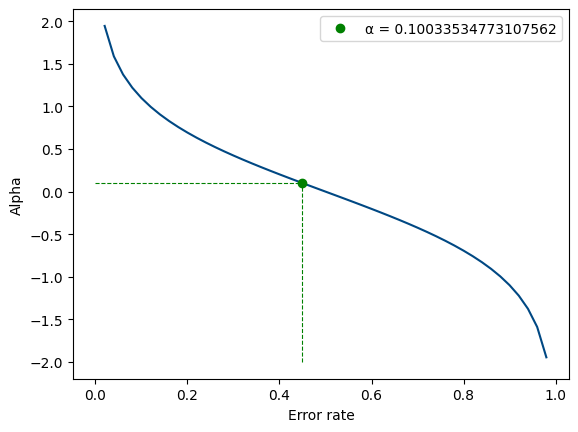

New Sample Weights: [0.0027638539919628336, 0.002261335084333227, 0.002261335084333227, 0.0027638539919628336, 0.0027638539919628336, 0.0027638539919628336, 0.002261335084333227, 0.002261335084333227, 0.0027638539919628336, 0.002261335084333227, 0.0027638539919628336, 0.0027638539919628336, 0.0027638539919628336, 0.0027638539919628336, 0.0027638539919628336, 0.0027638539919628336, 0.0027638539919628336, 0.002261335084333227, 0.0027638539919628336, 0.002261335084333227, 0.002261335084333227, 0.002261335084333227, 0.0027638539919628336, 0.0027638539919628336, 0.002261335084333227, 0.0027638539919628336, 0.0027638539919628336, 0.0027638539919628336, 0.002261335084333227, 0.002261335084333227, 0.0027638539919628336, 0.0027638539919628336, 0.002261335084333227, 0.002261335084333227, 0.0027638539919628336, 0.002261335084333227, 0.0027638539919628336, 0.0027638539919628336, 0.002261335084333227, 0.002261335084333227, 0.0027638539919628336, 0.002261335084333227, 0.0027638539919628336, 0.002261

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.002778  0.002778  
1     0.0   0.0   0.0         1          0.0025            0.002273  0.005051  
2     0.0   0.0   0.0         0          0.0025            0.002273  0.007323  
3     0.0   0.0   0.0         1          0.0025            0.002778  0.010101  
4     0.0   0.0   0.0         1          0.0025            0.002778  0.012879  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.002273  0.989899  
396   0.0   0.0   0.0         0          0.0025            0.002273  0.992172  
397   0.0   0.0   0.0         1          0.0025            0.002778  0.994949  
398   0.0   0.0   0.0         1          0.0025            0.002778  0.997727  
399   0.0   0.0   0.0         0          0.0025            0.002273  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         1          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.0005240079221888738 

IG: 0.012547152362874958 

IG: 0.009057304289734502 

IG: 0.006952287639180654 

IG: 0.02198488713667668 

IG: 0.00041634970101989133 

IG: 0.001829145447353242 

IG: 0.004207951232695573 

IG: 0.0002994018752158212 

IG: 0.0003145082930833265 

IG: 0.006688663580662446 

IG: 0.008252413866944197 

IG: 0.010775670474714616 

IG: 0.017998295455732727 

IG: 0.027071434054384613 

IG: 0.0003423373164260779 

IG: 0.007016222634854685 

IG: 0.04005461212268491 

IG: 0.017421720333089197 

IG: 0.0033721903571145573 

IG: 0.0024694975379963013 

IG: 0.024859977969708624 

IG: 0.008265783621811962 

IG: 0.04397077997681198 

IG: 0.006216897599686799 

IG: 0.016057514213812518 

IG: 0.0049568789375951106 

IG: 0.06802378377477925 

IG: 0.007301685845021555 

IG: 0.0036803336792851082 

IG: 0.0027853137874184197 

IG: 0.0281202289653274 

IG: 0.03439762371359478 

IG: 0.0014755433033741827 

IG: 0.0039028787934618503 

IG: 0.016114716500266857 

IG: 0.0002683305615490

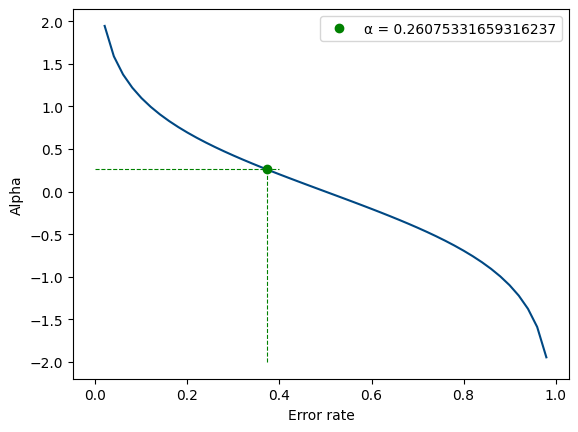

New Sample Weights: [0.001926177396438293, 0.003244768634268534, 0.001926177396438293, 0.001926177396438293, 0.001926177396438293, 0.001926177396438293, 0.001926177396438293, 0.001926177396438293, 0.001926177396438293, 0.001926177396438293, 0.001926177396438293, 0.003244768634268534, 0.001926177396438293, 0.001926177396438293, 0.001926177396438293, 0.001926177396438293, 0.003244768634268534, 0.001926177396438293, 0.001926177396438293, 0.003244768634268534, 0.001926177396438293, 0.001926177396438293, 0.003244768634268534, 0.001926177396438293, 0.003244768634268534, 0.001926177396438293, 0.001926177396438293, 0.001926177396438293, 0.003244768634268534, 0.003244768634268534, 0.001926177396438293, 0.003244768634268534, 0.003244768634268534, 0.001926177396438293, 0.001926177396438293, 0.001926177396438293, 0.001926177396438293, 0.003244768634268534, 0.001926177396438293, 0.001926177396438293, 0.003244768634268534, 0.001926177396438293, 0.003244768634268534, 0.001926177396438293, 0.001926177

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.001992  0.001992  
1     0.0   0.0   0.0         0          0.0025            0.003356  0.005348  
2     0.0   0.0   0.0         1          0.0025            0.001992  0.007340  
3     0.0   0.0   0.0         1          0.0025            0.001992  0.009332  
4     0.0   0.0   0.0         1          0.0025            0.001992  0.011324  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.001992  0.989305  
396   0.0   0.0   0.0         1          0.0025            0.001992  0.991297  
397   0.0   0.0   0.0         1          0.0025            0.001992  0.993289  
398   0.0   0.0   0.0         0          0.0025            0.003356  0.996644  
399   0.0   0.0   0.0         0          0.0025            0.003356  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         1          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 7.927302533539127e-05 

IG: 0.011604983928480417 

IG: 0.0013544742407072263 

IG: 0.008471381668355815 

IG: 0.04611885206472699 

IG: 0.0011732489651875566 

IG: 0.0025876278361929295 

IG: 0.006512920680754153 

IG: 0.0010945242545505884 

IG: 0.0002907886656129399 

IG: 0.0011033839505714127 

IG: 0.007503982184354885 

IG: 0.02671662245231432 

IG: 0.016505387513009118 

IG: 0.006034359256225641 

IG: 0.005374774146139405 

IG: 0.014794356742841908 

IG: 0.01780535409628925 

IG: 0.011087245492927278 

IG: 0.005503261038318441 

IG: 0.024453098448876 

IG: 0.01465488002353299 

IG: 0.0003145443693116645 

IG: 0.057624428879520684 

IG: 0.0008236423555451067 

IG: 0.019176583792342328 

IG: 0.006034359256225641 

IG: 0.0205446545827751 

IG: 0.004175450342617237 

IG: 0.010173077415107867 

IG: 0.0030081168834728 

IG: 0.023022781633268097 

IG: 0.04271413610158914 

IG: 0.0007011839794093255 

IG: 0.002720208947721514 

IG: 0.011604983928480417 

IG: 0.000545714850444301 

IG:

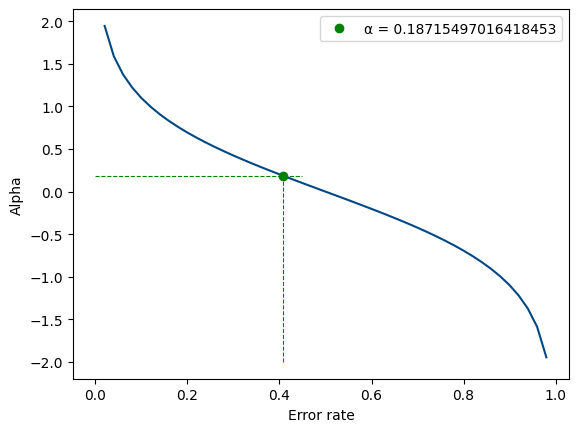

New Sample Weights: [0.0020732880182818434, 0.0030145353394650126, 0.0030145353394650126, 0.0030145353394650126, 0.0020732880182818434, 0.0020732880182818434, 0.0030145353394650126, 0.0020732880182818434, 0.0020732880182818434, 0.0020732880182818434, 0.0030145353394650126, 0.0020732880182818434, 0.0030145353394650126, 0.0020732880182818434, 0.0030145353394650126, 0.0020732880182818434, 0.0020732880182818434, 0.0030145353394650126, 0.0020732880182818434, 0.0020732880182818434, 0.0030145353394650126, 0.0020732880182818434, 0.0020732880182818434, 0.0020732880182818434, 0.0030145353394650126, 0.0030145353394650126, 0.0030145353394650126, 0.0020732880182818434, 0.0020732880182818434, 0.0030145353394650126, 0.0020732880182818434, 0.0020732880182818434, 0.0020732880182818434, 0.0030145353394650126, 0.0020732880182818434, 0.0020732880182818434, 0.0030145353394650126, 0.0020732880182818434, 0.0030145353394650126, 0.0030145353394650126, 0.0030145353394650126, 0.0020732880182818434, 0.00301453533

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.002110  0.002110  
1     0.0   0.0   0.0         1          0.0025            0.003067  0.005177  
2     0.0   0.0   0.0         1          0.0025            0.003067  0.008245  
3     0.0   0.0   0.0         1          0.0025            0.003067  0.011312  
4     0.0   0.0   0.0         0          0.0025            0.002110  0.013422  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.003067  0.989646  
396   0.0   0.0   0.0         0          0.0025            0.002110  0.991755  
397   0.0   0.0   0.0         0          0.0025            0.002110  0.993865  
398   0.0   0.0   0.0         1          0.0025            0.003067  0.996933  
399   0.0   0.0   0.0         1          0.0025            0.003067  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         1          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.001365532491025001 

IG: 0.0005737072432603352 

IG: 0.005593767154022933 

IG: 0.00711800652543626 

IG: 0.0579232838328414 

IG: 0.016596561655699116 

IG: 0.014088265796821653 

IG: 0.01691265933070496 

IG: 4.8889178649536014e-05 

IG: 0.0016261312025473984 

IG: 0.006302878737975526 

IG: 0.01176270771692356 

IG: 0.03520169452373101 

IG: 0.011337870942507933 

IG: 0.005195359947057665 

IG: 0.00384722327950926 

IG: 0.01964336430689051 

IG: 0.012549354830582948 

IG: 0.017020591926754536 

IG: 0.0036159228252050646 

IG: 0.029362294877626094 

IG: 0.011063250929868373 

IG: 0.000516670825547183 

IG: 0.058490746466053456 

IG: 0.003608238451912271 

IG: 0.0354037033579796 

IG: 0.007454960856387638 

IG: 0.012506666312186554 

IG: 0.01093056377868773 

IG: 0.008805766508780066 

IG: 4.145898879492904e-05 

IG: 0.05226752876147989 

IG: 0.06598061070534955 

IG: 3.0928718641742847e-07 

IG: 6.504141439878097e-07 

IG: 0.00783889559358375 

IG: 0.001739706824162801 

IG: 0.

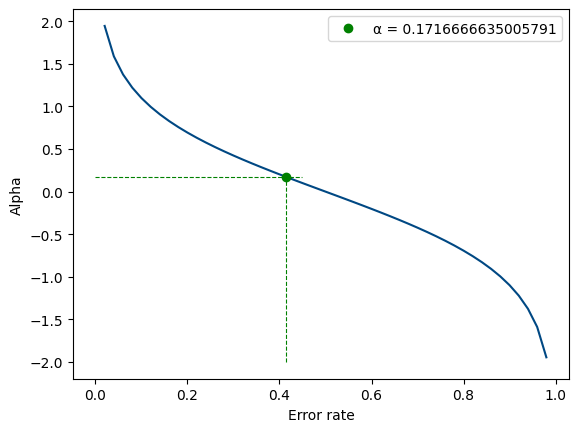

New Sample Weights: [0.0021056497058534415, 0.0021056497058534415, 0.0021056497058534415, 0.002968205007046417, 0.0021056497058534415, 0.0021056497058534415, 0.002968205007046417, 0.0021056497058534415, 0.0021056497058534415, 0.0021056497058534415, 0.002968205007046417, 0.0021056497058534415, 0.0021056497058534415, 0.0021056497058534415, 0.0021056497058534415, 0.0021056497058534415, 0.002968205007046417, 0.002968205007046417, 0.0021056497058534415, 0.002968205007046417, 0.0021056497058534415, 0.0021056497058534415, 0.0021056497058534415, 0.0021056497058534415, 0.002968205007046417, 0.002968205007046417, 0.002968205007046417, 0.0021056497058534415, 0.0021056497058534415, 0.002968205007046417, 0.002968205007046417, 0.002968205007046417, 0.0021056497058534415, 0.0021056497058534415, 0.0021056497058534415, 0.002968205007046417, 0.0021056497058534415, 0.0021056497058534415, 0.0021056497058534415, 0.0021056497058534415, 0.002968205007046417, 0.0021056497058534415, 0.002968205007046417, 0.002

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.002137  0.002137  
1     0.0   0.0   0.0         0          0.0025            0.002137  0.004274  
2     0.0   0.0   0.0         1          0.0025            0.002137  0.006410  
3     0.0   0.0   0.0         1          0.0025            0.003012  0.009422  
4     0.0   0.0   0.0         1          0.0025            0.002137  0.011559  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.003012  0.990578  
396   0.0   0.0   0.0         1          0.0025            0.003012  0.993590  
397   0.0   0.0   0.0         0          0.0025            0.002137  0.995726  
398   0.0   0.0   0.0         0          0.0025            0.002137  0.997863  
399   0.0   0.0   0.0         0          0.0025            0.002137  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
4    1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 0.00039456390120906626 

IG: 0.0005889979371993537 

IG: 0.0010721924406266181 

IG: 0.0025585107007568553 

IG: 0.02121070227598365 

IG: 0.004941777866109498 

IG: 0.05182978849777464 

IG: 0.004502401779940768 

IG: 0.0007953341709219242 

IG: 9.938125945829768e-05 

IG: 0.01381357755388235 

IG: 0.016921225515952654 

IG: 0.023975380342201924 

IG: 0.00038110932271839815 

IG: 0.0072520831737693525 

IG: 0.00777737494580466 

IG: 0.019092095870041015 

IG: 0.003492681504619899 

IG: 0.010200289639470839 

IG: 0.005908045435283449 

IG: 0.04001865117804937 

IG: 0.0023349046183063216 

IG: 0.0012188457226675053 

IG: 0.05461410205395245 

IG: 0.0008384582134025598 

IG: 0.0134280989565021 

IG: 0.022208652436416787 

IG: 0.00048769314602548075 

IG: 0.014917834380735462 

IG: 0.004136559170249354 

IG: 0.00040260304787909096 

IG: 0.05141881582586261 

IG: 0.06687616286307463 

IG: 0.001323380406475172 

IG: 0.0002767048432402719 

IG: 0.013685783283122976 

IG: 5.28774455875735

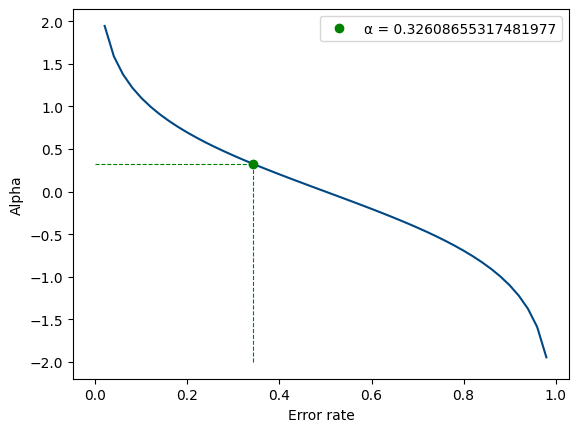

New Sample Weights: [0.0018043567890118717, 0.0018043567890118717, 0.0034638382154023525, 0.0018043567890118717, 0.0018043567890118717, 0.0018043567890118717, 0.0018043567890118717, 0.0018043567890118717, 0.0018043567890118717, 0.0034638382154023525, 0.0018043567890118717, 0.0018043567890118717, 0.0018043567890118717, 0.0034638382154023525, 0.0034638382154023525, 0.0018043567890118717, 0.0018043567890118717, 0.0018043567890118717, 0.0018043567890118717, 0.0018043567890118717, 0.0034638382154023525, 0.0034638382154023525, 0.0034638382154023525, 0.0018043567890118717, 0.0034638382154023525, 0.0018043567890118717, 0.0018043567890118717, 0.0034638382154023525, 0.0034638382154023525, 0.0018043567890118717, 0.0018043567890118717, 0.0034638382154023525, 0.0018043567890118717, 0.0034638382154023525, 0.0018043567890118717, 0.0034638382154023525, 0.0034638382154023525, 0.0034638382154023525, 0.0034638382154023525, 0.0034638382154023525, 0.0034638382154023525, 0.0018043567890118717, 0.00346383821

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
4    1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.001901  0.001901  
1     0.0   0.0   0.0         1          0.0025            0.001901  0.003802  
2     0.0   0.0   0.0         0          0.0025            0.003650  0.007452  
3     0.0   0.0   0.0         1          0.0025            0.001901  0.009353  
4     0.0   0.0   0.0         1          0.0025            0.001901  0.011254  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.003650  0.990647  
396   0.0   0.0   0.0         1          0.0025            0.001901  0.992548  
397   0.0   0.0   0.0         0          0.0025            0.003650  0.996198  
398   0.0   0.0   0.0         1          0.0025            0.001901  0.998099  
399   0.0   0.0   0.0         1          0.0025            0.001901  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 9.581974380612479e-08 

IG: 0.006081345593921372 

IG: 0.005101958248081906 

IG: 0.0013937249529668572 

IG: 0.04485170500131841 

IG: 0.000560397958179859 

IG: 0.040790932415334824 

IG: 0.001854414456391007 

IG: 9.580289913790896e-05 

IG: 1.0288976813876971e-05 

IG: 0.027860360888373514 

IG: 0.026009597569264575 

IG: 0.04991798466757058 

IG: 0.0005914705240648299 

IG: 0.021645615273252927 

IG: 0.01786641815196388 

IG: 0.03387989737320207 

IG: 0.015220203412775524 

IG: 0.0069166729698493246 

IG: 0.028158394497899475 

IG: 0.05943859284628661 

IG: 0.003191833634451746 

IG: 0.004944119311976025 

IG: 0.06731128964732291 

IG: 4.775692222847017e-05 

IG: 0.012168983277765055 

IG: 0.004013959200762529 

IG: 0.004529410453245064 

IG: 0.01833453013042352 

IG: 0.004771041590167169 

IG: 0.0028618573251735224 

IG: 0.05364795732902161 

IG: 0.08579381026507304 

IG: 0.0007272044147130785 

IG: 0.001975026245786382 

IG: 0.00663065073928748 

IG: 0.00021281398687955644 


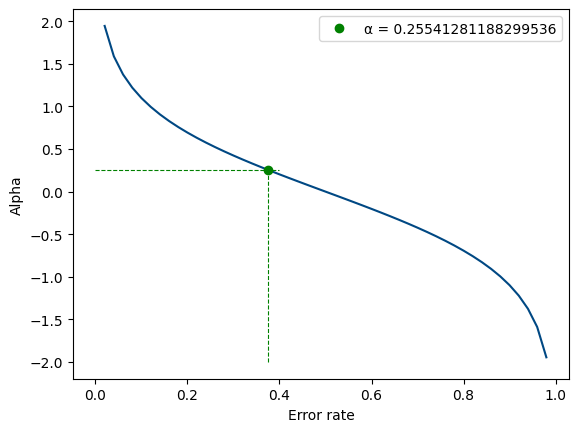

New Sample Weights: [0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.003227486121839514, 0.003227486121839514, 0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.003227486121839514, 0.0019364916731037087, 0.003227486121839514, 0.003227486121839514, 0.003227486121839514, 0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.003227486121839514, 0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.003227486121839514, 0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.003227486121839514, 0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.0019364916731037087, 0.003227486121839514, 0.003227486121839514, 0.0019364916731037087, 0.0019364916731037087, 0

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.002000  0.002000  
1     0.0   0.0   0.0         0          0.0025            0.002000  0.004000  
2     0.0   0.0   0.0         0          0.0025            0.002000  0.006000  
3     0.0   0.0   0.0         0          0.0025            0.002000  0.008000  
4     0.0   0.0   0.0         0          0.0025            0.002000  0.010000  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.003333  0.990667  
396   0.0   0.0   0.0         0          0.0025            0.002000  0.992667  
397   0.0   0.0   0.0         1          0.0025            0.003333  0.996000  
398   0.0   0.0   0.0         0          0.0025            0.002000  0.998000  
399   0.0   0.0   0.0         0          0.0025            0.002000  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
1    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         1          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 3.995789139510375e-05 

IG: 0.010318816412834053 

IG: 0.002321716498062343 

IG: 0.0036023739434939417 

IG: 0.017523901802352415 

IG: 0.001496336184450553 

IG: 0.03995210442162045 

IG: 0.004040428075545943 

IG: 0.00018384169493501634 

IG: 0.0003145082930833265 

IG: 0.030608265869431772 

IG: 0.02999528923348327 

IG: 0.03661737673522081 

IG: 0.001296228760927054 

IG: 0.02478520869190637 

IG: 0.01626711502708378 

IG: 0.04664989962236399 

IG: 0.03918881917376704 

IG: 0.00289138689046442 

IG: 0.011463836438884267 

IG: 0.0566474151460884 

IG: 0.0018172700676634124 

IG: 0.0030066539047494123 

IG: 0.03995210442162045 

IG: 0.002469693642642823 

IG: 0.004538867890202747 

IG: 0.0008488601978614563 

IG: 0.013507543866708605 

IG: 0.009972386821681667 

IG: 0.010636194620668782 

IG: 0.011937068217402591 

IG: 0.061333297421746535 

IG: 0.10213324097528187 

IG: 0.0046640809917781745 

IG: 0.005884090260570463 

IG: 0.018650110167436673 

IG: 0.0003236691624898258 

IG:

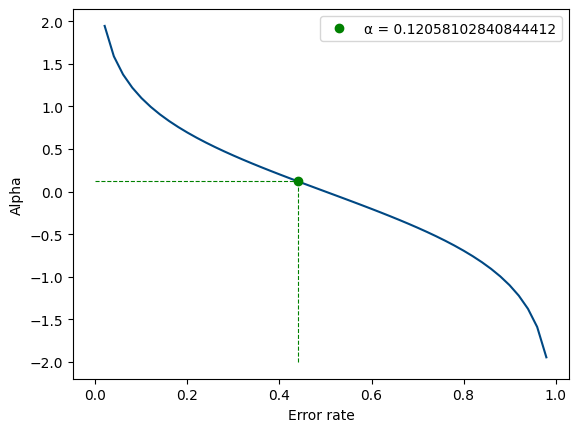

New Sample Weights: [0.0022160131510697957, 0.002820380374088831, 0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.002820380374088831, 0.002820380374088831, 0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.00282038

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
1    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.002232  0.002232  
1     0.0   0.0   0.0         1          0.0025            0.002841  0.005073  
2     0.0   0.0   0.0         1          0.0025            0.002841  0.007914  
3     0.0   0.0   0.0         1          0.0025            0.002841  0.010755  
4     0.0   0.0   0.0         0          0.0025            0.002232  0.012987  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.002841  0.989854  
396   0.0   0.0   0.0         1          0.0025            0.002841  0.992695  
397   0.0   0.0   0.0         0          0.0025            0.002232  0.994927  
398   0.0   0.0   0.0         1          0.0025            0.002841  0.997768  
399   0.0   0.0   0.0         1          0.0025            0.002232  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         1          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 0.001393540571430707 

IG: 0.010358515047055206 

IG: 5.207900500847629e-07 

IG: 0.012440854615123675 

IG: 0.019171148517952874 

IG: 0.0009504427986868347 

IG: 0.0237517244174541 

IG: 0.0036463493084637477 

IG: 0.00034839772052719375 

IG: 0.0008120927406748413 

IG: 0.02237747146565594 

IG: 0.025818860690680845 

IG: 0.03914351579155584 

IG: 0.0011622262973921549 

IG: 0.011727742494794469 

IG: 0.011312027058824059 

IG: 0.06239627826315641 

IG: 0.04090242249156106 

IG: 0.0016314213244726927 

IG: 0.008685866029023659 

IG: 0.06343504629392627 

IG: 0.014535616258146478 

IG: 0.002893521205146521 

IG: 0.05120565681711731 

IG: 0.004934051173740239 

IG: 0.006891577545148353 

IG: 0.00036870158475188486 

IG: 0.006183567797837908 

IG: 2.4651288239141422e-05 

IG: 0.007660644283366436 

IG: 0.011854388437068097 

IG: 0.05242890192029159 

IG: 0.0737696475427072 

IG: 0.00731433272316373 

IG: 0.011597780568159521 

IG: 0.01992359995024051 

IG: 0.0017791248983278773 

I

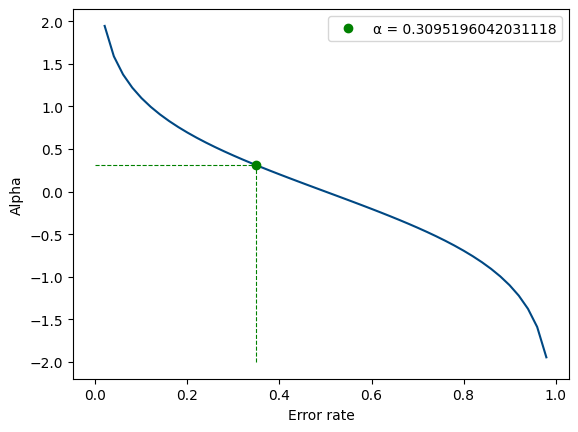

New Sample Weights: [0.0018344984642633569, 0.0018344984642633569, 0.0018344984642633569, 0.0018344984642633569, 0.003406925719346235, 0.0018344984642633569, 0.0018344984642633569, 0.0018344984642633569, 0.0018344984642633569, 0.003406925719346235, 0.0018344984642633569, 0.0018344984642633569, 0.0018344984642633569, 0.0018344984642633569, 0.003406925719346235, 0.003406925719346235, 0.003406925719346235, 0.0018344984642633569, 0.0018344984642633569, 0.003406925719346235, 0.003406925719346235, 0.0018344984642633569, 0.003406925719346235, 0.0018344984642633569, 0.003406925719346235, 0.003406925719346235, 0.003406925719346235, 0.0018344984642633569, 0.003406925719346235, 0.003406925719346235, 0.003406925719346235, 0.003406925719346235, 0.0018344984642633569, 0.003406925719346235, 0.0018344984642633569, 0.0018344984642633569, 0.0018344984642633569, 0.0018344984642633569, 0.0018344984642633569, 0.003406925719346235, 0.003406925719346235, 0.0018344984642633569, 0.0018344984642633569, 0.001834

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.001923  0.001923  
1     0.0   0.0   0.0         1          0.0025            0.001923  0.003846  
2     0.0   0.0   0.0         1          0.0025            0.001923  0.005769  
3     0.0   0.0   0.0         1          0.0025            0.001923  0.007692  
4     0.0   0.0   0.0         0          0.0025            0.003571  0.011264  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.003571  0.989011  
396   0.0   0.0   0.0         1          0.0025            0.001923  0.990934  
397   0.0   0.0   0.0         0          0.0025            0.003571  0.994505  
398   0.0   0.0   0.0         0          0.0025            0.003571  0.998077  
399   0.0   0.0   0.0         1          0.0025            0.001923  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.00037709415486752995 

IG: 0.011182983118945278 

IG: 6.501370077161006e-05 

IG: 0.009112950680067344 

IG: 0.009367633716676371 

IG: 0.004240602713430741 

IG: 0.009112950680067344 

IG: 0.014907065387585905 

IG: 0.007850747717674578 

IG: 0.0014488294278333091 

IG: 0.002228452490729671 

IG: 0.029160820077425154 

IG: 0.03513203077728333 

IG: 0.0019965293638843917 

IG: 0.01680134949424328 

IG: 0.008645226282039009 

IG: 0.0720010492325589 

IG: 0.05774387885730603 

IG: 6.501370077161006e-05 

IG: 0.002781809210874231 

IG: 0.05710432983778646 

IG: 0.031059323203449507 

IG: 0.00017594817565158571 

IG: 0.053338117944598196 

IG: 0.0014855662361776822 

IG: 0.004464575324642506 

IG: 6.015344845011761e-06 

IG: 0.013356030908208139 

IG: 9.267745682706163e-05 

IG: 0.002781809210874231 

IG: 0.00655179264696959 

IG: 0.033198191688124434 

IG: 0.056416230950458 

IG: 3.0378219826987518e-05 

IG: 0.02594927707986705 

IG: 0.04268942344305526 

IG: 0.013153399319381198 



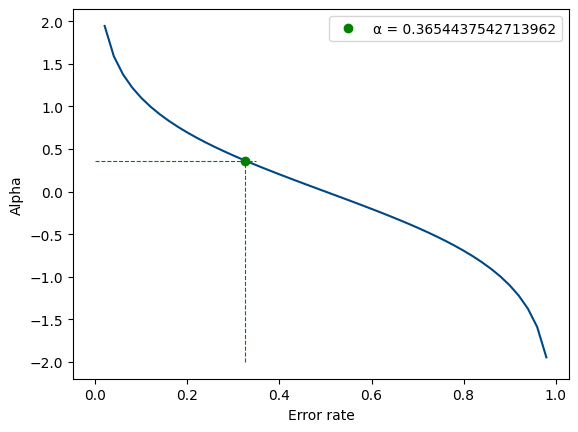

New Sample Weights: [0.0017347216662217774, 0.0036028834606144605, 0.0017347216662217774, 0.0017347216662217774, 0.0017347216662217774, 0.0036028834606144605, 0.0017347216662217774, 0.0017347216662217774, 0.0036028834606144605, 0.0017347216662217774, 0.0017347216662217774, 0.0036028834606144605, 0.0017347216662217774, 0.0036028834606144605, 0.0036028834606144605, 0.0017347216662217774, 0.0036028834606144605, 0.0017347216662217774, 0.0036028834606144605, 0.0017347216662217774, 0.0036028834606144605, 0.0017347216662217774, 0.0036028834606144605, 0.0017347216662217774, 0.0017347216662217774, 0.0036028834606144605, 0.0036028834606144605, 0.0036028834606144605, 0.0017347216662217774, 0.0017347216662217774, 0.0017347216662217774, 0.0017347216662217774, 0.0017347216662217774, 0.0017347216662217774, 0.0017347216662217774, 0.0017347216662217774, 0.0017347216662217774, 0.0017347216662217774, 0.0036028834606144605, 0.0017347216662217774, 0.0036028834606144605, 0.0017347216662217774, 0.00360288346

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.001852  0.001852  
1     0.0   0.0   0.0         1          0.0025            0.003846  0.005698  
2     0.0   0.0   0.0         0          0.0025            0.001852  0.007550  
3     0.0   0.0   0.0         0          0.0025            0.001852  0.009402  
4     0.0   0.0   0.0         0          0.0025            0.001852  0.011254  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.001852  0.988604  
396   0.0   0.0   0.0         0          0.0025            0.001852  0.990456  
397   0.0   0.0   0.0         1          0.0025            0.003846  0.994302  
398   0.0   0.0   0.0         1          0.0025            0.003846  0.998148  
399   0.0   0.0   0.0         0          0.0025            0.001852  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 0.00013900635428965025 

IG: 3.703400038856941e-07 

IG: 0.009044896013740145 

IG: 0.020490037000543748 

IG: 0.013713720130731466 

IG: 0.007251132452103848 

IG: 0.020694390845084842 

IG: 0.018047917914236655 

IG: 0.010878981410306188 

IG: 0.0006558400375800133 

IG: 0.0034606974579919347 

IG: 0.03117312320581178 

IG: 0.019968222623410692 

IG: 0.0008890547851369002 

IG: 0.004716620943838512 

IG: 0.007970476725312148 

IG: 0.06221997392075651 

IG: 0.031276145293826385 

IG: 8.507337516783231e-05 

IG: 0.0035771749715630685 

IG: 0.08671540980888992 

IG: 0.01201212378728278 

IG: 0.00041098338152545377 

IG: 0.04454073572294781 

IG: 0.0007111423437365927 

IG: 0.0008890547851369002 

IG: 0.010385266090189749 

IG: 0.01309671505425769 

IG: 0.014396732939063295 

IG: 0.01396865457049934 

IG: 0.006820645145054205 

IG: 0.04758118213111329 

IG: 0.07229365755042061 

IG: 0.0018796452047111778 

IG: 0.01222822657407785 

IG: 0.031152171777874882 

IG: 0.018635471661772263 

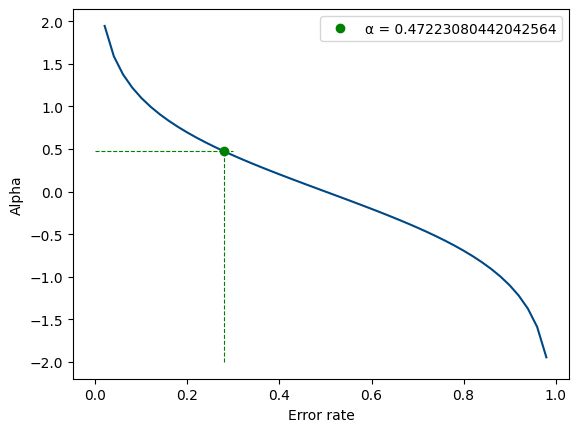

New Sample Weights: [0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.004008918628686365, 0.004008918628686365, 0.001559023911155809, 0.001559023911155809, 0.004008918628686365, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.004008918628686365, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.004008918628686365, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.001559023911155809, 0.004008918628686365, 0.001559023911155809, 0.001559023911155809, 0.004008918628686365, 0.004008918628686365, 0.001559023911155809, 0.001559023

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.001736  0.001736  
1     0.0   0.0   0.0         1          0.0025            0.001736  0.003472  
2     0.0   0.0   0.0         0          0.0025            0.001736  0.005208  
3     0.0   0.0   0.0         1          0.0025            0.001736  0.006944  
4     0.0   0.0   0.0         1          0.0025            0.001736  0.008681  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.001736  0.990327  
396   0.0   0.0   0.0         0          0.0025            0.004464  0.994792  
397   0.0   0.0   0.0         1          0.0025            0.001736  0.996528  
398   0.0   0.0   0.0         1          0.0025            0.001736  0.998264  
399   0.0   0.0   0.0         1          0.0025            0.001736  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
397  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.0010880056957387474 

IG: 0.002476294975099713 

IG: 0.03263517188716758 

IG: 0.0011471803867976194 

IG: 0.001321280254525381 

IG: 0.0017734346120067412 

IG: 0.0015360625173995723 

IG: 0.0029443529200692264 

IG: 5.781264357052063e-05 

IG: 2.4277392925209362e-05 

IG: 0.0012717037967050482 

IG: 0.0036865777751979856 

IG: 0.0003936349332903655 

IG: 0.005858750172594962 

IG: 0.0016506363096491228 

IG: 0.003308396458296392 

IG: 0.001446993829180121 

IG: 0.008068354956475843 

IG: 0.0004395256821523308 

IG: 0.000773654296177706 

IG: 5.781264357052063e-05 

IG: 0.006384787589007401 

IG: 0.00010111379512445229 

IG: 0.002683366360802464 

IG: 0.0007517958963767502 

IG: 0.0012717037967050482 

IG: 0.00045412034543368396 

IG: 0.019952003803641483 

IG: 0.007478758463635882 

IG: 0.003891424645865671 

IG: 0.0017304157829541866 

IG: 0.008754819600334529 

IG: 0.002095514236949758 

IG: 0.0024945379444932803 

IG: 2.6810046135916643e-05 

IG: 0.005858750172594962 

IG: 2

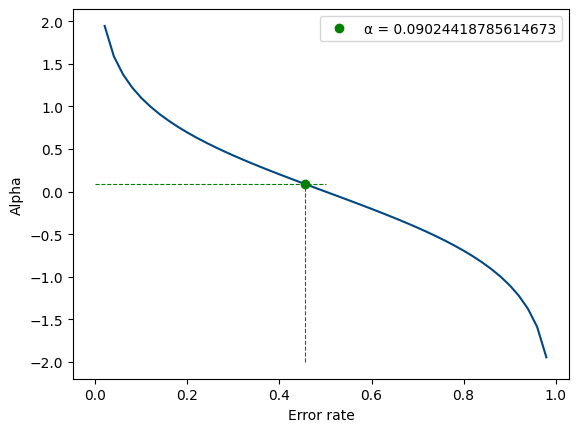

New Sample Weights: [0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002284270104050062, 0.002284270104050062, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002736103751005019, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002284270104050062, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002284270104050062, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002284270104050062, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002284270

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
397  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.002294  0.002294  
1     0.0   0.0   0.0         0          0.0025            0.002747  0.005041  
2     0.0   0.0   0.0         0          0.0025            0.002747  0.007788  
3     0.0   0.0   0.0         1          0.0025            0.002294  0.010082  
4     0.0   0.0   0.0         0          0.0025            0.002747  0.012829  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.002747  0.989918  
396   0.0   0.0   0.0         1          0.0025            0.002294  0.992212  
397   0.0   0.0   0.0         1          0.0025            0.002294  0.994505  
398   0.0   0.0   0.0         0          0.0025            0.002747  0.997253  
399   0.0   0.0   0.0         0          0.0025            0.002747  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         1          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.002008178041702169 

IG: 0.009689429589753384 

IG: 0.021327068257226856 

IG: 0.0022417817003385077 

IG: 0.0021425420032352704 

IG: 0.0002082551016994172 

IG: 6.851076704772474e-05 

IG: 0.011372148922789371 

IG: 3.097107865379645e-05 

IG: 0.0031070369198974435 

IG: 0.000253259175952647 

IG: 0.0017882961059834113 

IG: 0.0002767881766070346 

IG: 0.005894030393344241 

IG: 0.0008550389248319634 

IG: 0.010096551814180232 

IG: 0.0028391022356488715 

IG: 0.01042627452985423 

IG: 0.0003068095233940138 

IG: 0.0002082551016994172 

IG: 1.9021158011889305e-05 

IG: 0.0008870551087138967 

IG: 0.007059800394139559 

IG: 0.00018816975023705496 

IG: 0.00019987177930413935 

IG: 0.0002082551016994172 

IG: 0.0013437155753655006 

IG: 0.012654397319178057 

IG: 0.0038680868368341503 

IG: 0.006319390110753442 

IG: 0.0002657547709834507 

IG: 0.02181663524836297 

IG: 0.0008235932889560926 

IG: 0.0002767881766070346 

IG: 0.00022100411929304453 

IG: 0.013836569595091275 

IG:

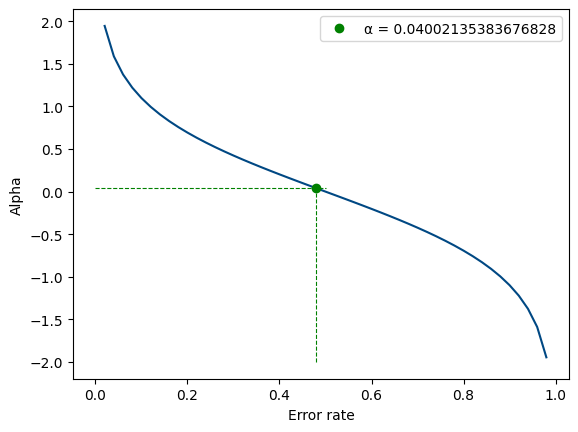

New Sample Weights: [0.0026020824993326663, 0.002401922307076307, 0.002401922307076307, 0.0026020824993326663, 0.0026020824993326663, 0.002401922307076307, 0.0026020824993326663, 0.002401922307076307, 0.0026020824993326663, 0.0026020824993326663, 0.002401922307076307, 0.0026020824993326663, 0.002401922307076307, 0.0026020824993326663, 0.002401922307076307, 0.0026020824993326663, 0.0026020824993326663, 0.0026020824993326663, 0.002401922307076307, 0.002401922307076307, 0.0026020824993326663, 0.002401922307076307, 0.002401922307076307, 0.0026020824993326663, 0.002401922307076307, 0.0026020824993326663, 0.002401922307076307, 0.0026020824993326663, 0.002401922307076307, 0.002401922307076307, 0.002401922307076307, 0.002401922307076307, 0.002401922307076307, 0.002401922307076307, 0.002401922307076307, 0.002401922307076307, 0.0026020824993326663, 0.002401922307076307, 0.002401922307076307, 0.002401922307076307, 0.002401922307076307, 0.0026020824993326663, 0.0026020824993326663, 0.0024019223070

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.002604  0.002604  
1     0.0   0.0   0.0         1          0.0025            0.002404  0.005008  
2     0.0   0.0   0.0         1          0.0025            0.002404  0.007412  
3     0.0   0.0   0.0         0          0.0025            0.002604  0.010016  
4     0.0   0.0   0.0         0          0.0025            0.002604  0.012620  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.002404  0.989784  
396   0.0   0.0   0.0         1          0.0025            0.002404  0.992187  
397   0.0   0.0   0.0         0          0.0025            0.002604  0.994792  
398   0.0   0.0   0.0         0          0.0025            0.002604  0.997396  
399   0.0   0.0   0.0         0          0.0025            0.002604  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         1          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.00011621143587681182 

IG: 0.006346126927238127 

IG: 0.0034048405457224318 

IG: 0.00278681909101397 

IG: 0.0007563876266385439 

IG: 0.0025663368004562592 

IG: 0.00012173643799073819 

IG: 0.004715747803618164 

IG: 0.00230205202398559 

IG: 0.023968654573727877 

IG: 0.0049296323514979035 

IG: 0.0003643643095140314 

IG: 0.004046833211674983 

IG: 0.01200604069885658 

IG: 0.00014727964622984757 

IG: 0.004465427955158696 

IG: 2.24213223906089e-05 

IG: 0.003903583386106191 

IG: 0.0017083959746775346 

IG: 0.00031124920409486556 

IG: 0.0005795752000546939 

IG: 0.003780507445147019 

IG: 0.003038568879431325 

IG: 3.249356246581847e-05 

IG: 0.0007563876266385439 

IG: 0.0026142681303017445 

IG: 0.01343859952049209 

IG: 0.0017083959746775346 

IG: 0.0020659441498861453 

IG: 0.00981815571819078 

IG: 0.00020877468183178038 

IG: 0.011070964269487282 

IG: 2.2125094922831323e-05 

IG: 7.3025967013418125e-06 

IG: 0.0038101687039083787 

IG: 0.020507578351412148 

IG: 8.

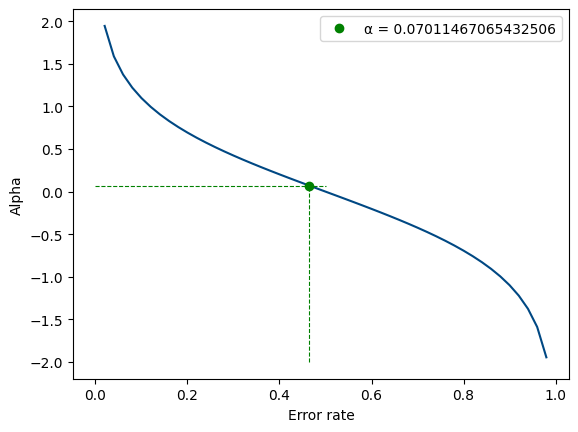

New Sample Weights: [0.0026815779338019924, 0.0026815779338019924, 0.002330717269566218, 0.0026815779338019924, 0.0026815779338019924, 0.002330717269566218, 0.0026815779338019924, 0.0026815779338019924, 0.0026815779338019924, 0.0026815779338019924, 0.002330717269566218, 0.0026815779338019924, 0.002330717269566218, 0.0026815779338019924, 0.002330717269566218, 0.0026815779338019924, 0.002330717269566218, 0.002330717269566218, 0.002330717269566218, 0.0026815779338019924, 0.002330717269566218, 0.002330717269566218, 0.002330717269566218, 0.002330717269566218, 0.0026815779338019924, 0.002330717269566218, 0.0026815779338019924, 0.002330717269566218, 0.0026815779338019924, 0.0026815779338019924, 0.0026815779338019924, 0.0026815779338019924, 0.0026815779338019924, 0.0026815779338019924, 0.002330717269566218, 0.0026815779338019924, 0.002330717269566218, 0.0026815779338019924, 0.002330717269566218, 0.002330717269566218, 0.0026815779338019924, 0.002330717269566218, 0.002330717269566218, 0.00268157

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.002688  0.002688  
1     0.0   0.0   0.0         0          0.0025            0.002688  0.005376  
2     0.0   0.0   0.0         1          0.0025            0.002336  0.007713  
3     0.0   0.0   0.0         0          0.0025            0.002688  0.010401  
4     0.0   0.0   0.0         0          0.0025            0.002688  0.013089  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.002336  0.989599  
396   0.0   0.0   0.0         0          0.0025            0.002688  0.992287  
397   0.0   0.0   0.0         0          0.0025            0.002688  0.994975  
398   0.0   0.0   0.0         1          0.0025            0.002336  0.997312  
399   0.0   0.0   0.0         0          0.0025            0.002688  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.00045690841737144883 

IG: 0.0010481906591774948 

IG: 0.009330812006057343 

IG: 0.0014816843079896724 

IG: 0.006442814182521683 

IG: 0.000720362592664503 

IG: 6.999081548775266e-07 

IG: 0.004282577202222693 

IG: 0.010236635381492443 

IG: 0.018373600553447056 

IG: 0.0017149790432078316 

IG: 0.003651755893137043 

IG: 0.0012250531587018054 

IG: 0.00908619455585602 

IG: 6.999081548775266e-07 

IG: 0.0023478944492091314 

IG: 0.001719243255024705 

IG: 0.012182717906831009 

IG: 0.0007674432384010554 

IG: 0.0004993604713879884 

IG: 0.001225308009325965 

IG: 0.004979813674987232 

IG: 0.003116732482836282 

IG: 0.002452195045126948 

IG: 0.003174367159701874 

IG: 0.0001932825407312544 

IG: 0.020258853373986918 

IG: 0.009856376678425871 

IG: 0.0011669356422167043 

IG: 0.0025817924461803976 

IG: 0.0017553175053184322 

IG: 0.003625764543843446 

IG: 0.010829787814715552 

IG: 0.00035535569947187096 

IG: 0.0014286495198294613 

IG: 0.029422458671461982 

IG: 0.00104

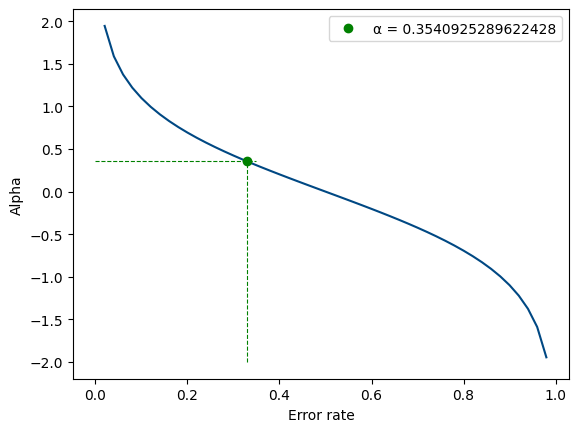

New Sample Weights: [0.0035622175592450746, 0.001754525066493843, 0.001754525066493843, 0.001754525066493843, 0.0035622175592450746, 0.001754525066493843, 0.001754525066493843, 0.001754525066493843, 0.001754525066493843, 0.001754525066493843, 0.0035622175592450746, 0.0035622175592450746, 0.001754525066493843, 0.001754525066493843, 0.001754525066493843, 0.0035622175592450746, 0.001754525066493843, 0.001754525066493843, 0.0035622175592450746, 0.0035622175592450746, 0.0035622175592450746, 0.001754525066493843, 0.001754525066493843, 0.001754525066493843, 0.001754525066493843, 0.0035622175592450746, 0.001754525066493843, 0.0035622175592450746, 0.0035622175592450746, 0.0035622175592450746, 0.0035622175592450746, 0.0035622175592450746, 0.001754525066493843, 0.0035622175592450746, 0.001754525066493843, 0.0035622175592450746, 0.001754525066493843, 0.0035622175592450746, 0.001754525066493843, 0.001754525066493843, 0.0035622175592450746, 0.001754525066493843, 0.001754525066493843, 0.0035622175592

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.003788  0.003788  
1     0.0   0.0   0.0         0          0.0025            0.001866  0.005654  
2     0.0   0.0   0.0         0          0.0025            0.001866  0.007519  
3     0.0   0.0   0.0         0          0.0025            0.001866  0.009385  
4     0.0   0.0   0.0         1          0.0025            0.003788  0.013173  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.001866  0.992537  
396   0.0   0.0   0.0         0          0.0025            0.001866  0.994403  
397   0.0   0.0   0.0         0          0.0025            0.001866  0.996269  
398   0.0   0.0   0.0         0          0.0025            0.001866  0.998134  
399   0.0   0.0   0.0         0          0.0025            0.001866  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 3.673060292086472e-05 

IG: 2.495952646786037e-06 

IG: 0.020466023766860797 

IG: 0.007008886803385517 

IG: 0.017627980052250414 

IG: 0.0015963980055351268 

IG: 0.00025346220508415396 

IG: 0.000759923160520426 

IG: 0.014858069603396085 

IG: 0.027803666395789683 

IG: 0.000487849062963841 

IG: 0.009425626447518765 

IG: 0.001646839878852946 

IG: 0.014858069603396085 

IG: 0.0007237449097570181 

IG: 0.004850848678312647 

IG: 0.009492436319775144 

IG: 0.004760416598251771 

IG: 0.0018912473710228639 

IG: 3.673060292086472e-05 

IG: 0.0013249684751081015 

IG: 0.005927416833253263 

IG: 0.0033298074065067906 

IG: 0.006903231596712245 

IG: 0.0001463063795360542 

IG: 3.311377568682161e-05 

IG: 0.03440553973537097 

IG: 0.022550784162831516 

IG: 0.003782302607181709 

IG: 0.034002309674707853 

IG: 0.010872432219658945 

IG: 1.1102230246251565e-16 

IG: 0.004804388592639985 

IG: 0.012048796047647303 

IG: 0.000310707862019477 

IG: 0.047097223149084155 

IG: 0.007016222

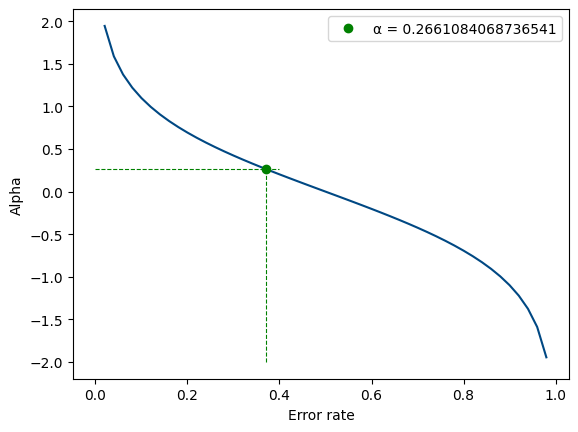

New Sample Weights: [0.0032621912715063003, 0.0032621912715063003, 0.0032621912715063003, 0.0032621912715063003, 0.0019158901118370337, 0.0019158901118370337, 0.0032621912715063003, 0.0032621912715063003, 0.0019158901118370337, 0.0019158901118370337, 0.0032621912715063003, 0.0019158901118370337, 0.0019158901118370337, 0.0019158901118370337, 0.0032621912715063003, 0.0019158901118370337, 0.0019158901118370337, 0.0019158901118370337, 0.0032621912715063003, 0.0032621912715063003, 0.0019158901118370337, 0.0019158901118370337, 0.0019158901118370337, 0.0019158901118370337, 0.0019158901118370337, 0.0032621912715063003, 0.0032621912715063003, 0.0032621912715063003, 0.0019158901118370337, 0.0019158901118370337, 0.0019158901118370337, 0.0019158901118370337, 0.0019158901118370337, 0.0019158901118370337, 0.0019158901118370337, 0.0019158901118370337, 0.0032621912715063003, 0.0032621912715063003, 0.0019158901118370337, 0.0032621912715063003, 0.0019158901118370337, 0.0032621912715063003, 0.00191589011

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.003378  0.003378  
1     0.0   0.0   0.0         0          0.0025            0.003378  0.006757  
2     0.0   0.0   0.0         0          0.0025            0.003378  0.010135  
3     0.0   0.0   0.0         0          0.0025            0.003378  0.013514  
4     0.0   0.0   0.0         0          0.0025            0.001984  0.015498  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.001984  0.990669  
396   0.0   0.0   0.0         0          0.0025            0.003378  0.994048  
397   0.0   0.0   0.0         1          0.0025            0.001984  0.996032  
398   0.0   0.0   0.0         1          0.0025            0.001984  0.998016  
399   0.0   0.0   0.0         1          0.0025            0.001984  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
396  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 0.0002731168264066275 

IG: 0.0031686248161050257 

IG: 0.018954900883326964 

IG: 0.0017685762320712728 

IG: 0.009184361877872194 

IG: 0.020089837197611038 

IG: 8.69430391646775e-05 

IG: 0.0001603650016400726 

IG: 0.009996214577785434 

IG: 0.03513203077728333 

IG: 0.007765101494921267 

IG: 0.015792790794890932 

IG: 0.000934881701677881 

IG: 0.001028766584513785 

IG: 0.0006627666657151865 

IG: 0.0015406014811708557 

IG: 0.015249348053420153 

IG: 0.0027554948858588 

IG: 0.0003214002172639008 

IG: 0.00496263500568761 

IG: 0.007678996689052142 

IG: 0.017843545950314788 

IG: 0.00040475219723024036 

IG: 0.03117278467592577 

IG: 0.0022499035620621166 

IG: 0.02183895269123659 

IG: 0.027086927967732377 

IG: 0.00883966895777033 

IG: 0.0008359156667638867 

IG: 0.033655878470558065 

IG: 0.003060920075200868 

IG: 6.501370077161006e-05 

IG: 0.007093259396270812 

IG: 0.023868739180432308 

IG: 8.053432335675126e-06 

IG: 0.10107821700498165 

IG: 0.01667076221640784

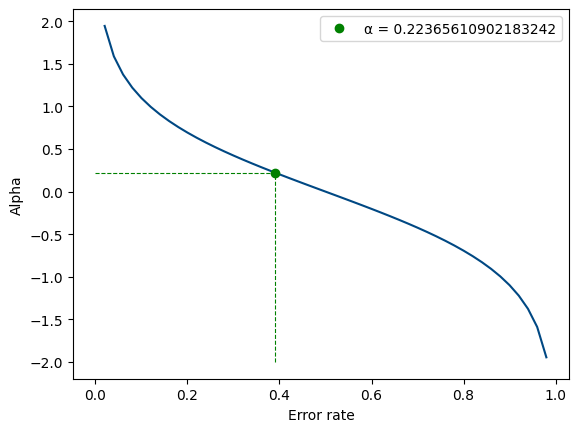

New Sample Weights: [0.0019989751472552788, 0.0019989751472552788, 0.0019989751472552788, 0.0019989751472552788, 0.0031266021533992816, 0.0019989751472552788, 0.0019989751472552788, 0.0031266021533992816, 0.0031266021533992816, 0.0031266021533992816, 0.0019989751472552788, 0.0019989751472552788, 0.0031266021533992816, 0.0019989751472552788, 0.0019989751472552788, 0.0019989751472552788, 0.0019989751472552788, 0.0031266021533992816, 0.0031266021533992816, 0.0031266021533992816, 0.0031266021533992816, 0.0019989751472552788, 0.0019989751472552788, 0.0019989751472552788, 0.0019989751472552788, 0.0019989751472552788, 0.0031266021533992816, 0.0019989751472552788, 0.0019989751472552788, 0.0019989751472552788, 0.0031266021533992816, 0.0031266021533992816, 0.0031266021533992816, 0.0019989751472552788, 0.0031266021533992816, 0.0031266021533992816, 0.0019989751472552788, 0.0031266021533992816, 0.0031266021533992816, 0.0031266021533992816, 0.0031266021533992816, 0.0031266021533992816, 0.00199897514

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
396  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.002049  0.002049  
1     0.0   0.0   0.0         0          0.0025            0.002049  0.004098  
2     0.0   0.0   0.0         0          0.0025            0.002049  0.006148  
3     0.0   0.0   0.0         1          0.0025            0.002049  0.008197  
4     0.0   0.0   0.0         0          0.0025            0.003205  0.011402  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.002049  0.990647  
396   0.0   0.0   0.0         0          0.0025            0.002049  0.992697  
397   0.0   0.0   0.0         0          0.0025            0.002049  0.994746  
398   0.0   0.0   0.0         0          0.0025            0.003205  0.997951  
399   0.0   0.0   0.0         1          0.0025            0.002049  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.0003010785631242241 

IG: 0.004668375755437326 

IG: 0.0073680571948054885 

IG: 0.0004337328378390959 

IG: 0.032147802787067414 

IG: 0.008775171100292911 

IG: 0.0024750636523900305 

IG: 0.0012188457226675053 

IG: 0.004166780663510838 

IG: 0.03983179909926404 

IG: 0.022620155179921664 

IG: 0.0073680571948054885 

IG: 0.013711328461748606 

IG: 0.003619547541825918 

IG: 0.005482212407171727 

IG: 0.007986010484237527 

IG: 0.0009745665700726658 

IG: 0.002921757740695252 

IG: 2.727929825618869e-05 

IG: 0.0002767048432402719 

IG: 0.013141450211552774 

IG: 0.012238778080197577 

IG: 0.00775265311345763 

IG: 0.03302410004792233 

IG: 5.7432772650578556e-05 

IG: 0.06039817784508006 

IG: 0.0046439508685474085 

IG: 0.015540253808206783 

IG: 0.0032702021710162565 

IG: 0.061907847275957106 

IG: 0.02387291124096469 

IG: 1.599001280294665e-05 

IG: 0.005723182421272566 

IG: 0.02340062472470572 

IG: 0.0026420216656983797 

IG: 0.053152323266252854 

IG: 0.0139888663229

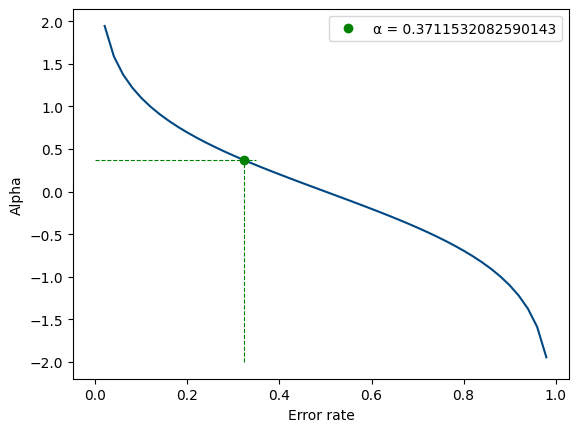

New Sample Weights: [0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.0036235127930283766, 0.0017248455730651685, 0.0017248455730651685, 0.0036235127930283766, 0.0036235127930283766, 0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.0036235127930283766, 0.0036235127930283766, 0.0017248455730651685, 0.0017248455730651685, 0.0036235127930283766, 0.0036235127930283766, 0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.0036235127930283766, 0.0036235127930283766, 0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.0036235127930283766, 0.0036235127930283766, 0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.0017248455730651685, 0.00362351279

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.001845  0.001845  
1     0.0   0.0   0.0         0          0.0025            0.001845  0.003690  
2     0.0   0.0   0.0         0          0.0025            0.001845  0.005535  
3     0.0   0.0   0.0         1          0.0025            0.003876  0.009411  
4     0.0   0.0   0.0         0          0.0025            0.001845  0.011256  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.003876  0.990589  
396   0.0   0.0   0.0         0          0.0025            0.001845  0.992434  
397   0.0   0.0   0.0         0          0.0025            0.001845  0.994279  
398   0.0   0.0   0.0         1          0.0025            0.003876  0.998155  
399   0.0   0.0   0.0         0          0.0025            0.001845  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 0.0007798886485469447 

IG: 1.8687599892763807e-05 

IG: 0.00184509295042945 

IG: 0.015430910963548095 

IG: 0.03405254141598779 

IG: 0.0010734020033084102 

IG: 0.0006916924967445004 

IG: 0.0062960272376944015 

IG: 0.005107043518881915 

IG: 0.019980962519171253 

IG: 0.03593169627827475 

IG: 0.004822076391224117 

IG: 0.041641754729494385 

IG: 0.0005896267410793188 

IG: 7.346323943857591e-05 

IG: 0.0008021934084039284 

IG: 5.805345759424263e-05 

IG: 6.821361015496574e-05 

IG: 0.00038683731311661695 

IG: 0.007740456664597772 

IG: 0.0006116200089077983 

IG: 0.06554359385621789 

IG: 0.0009025424471122978 

IG: 0.05173132662389801 

IG: 0.0028338542265646804 

IG: 0.032896907948416154 

IG: 0.003919004967052109 

IG: 0.010590658891952653 

IG: 0.002422221028283267 

IG: 0.0391815908096762 

IG: 0.01587062691032559 

IG: 0.000703718225082306 

IG: 0.003766675090612792 

IG: 0.013638254543854145 

IG: 0.0006774681713536124 

IG: 0.09962662621564111 

IG: 0.00552741892323

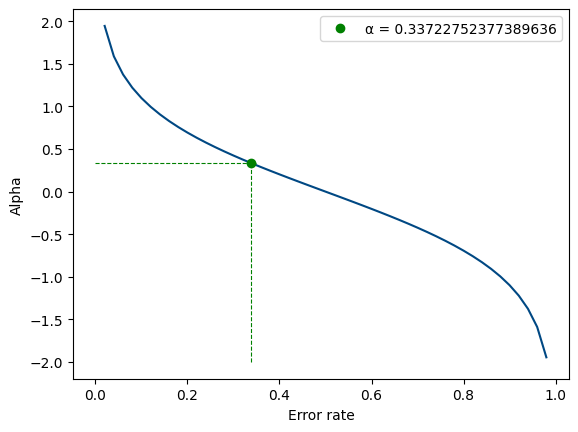

New Sample Weights: [0.0035026445035884696, 0.0017843660678658244, 0.0035026445035884696, 0.0017843660678658244, 0.0035026445035884696, 0.0017843660678658244, 0.0035026445035884696, 0.0017843660678658244, 0.0017843660678658244, 0.0035026445035884696, 0.0017843660678658244, 0.0017843660678658244, 0.0035026445035884696, 0.0017843660678658244, 0.0035026445035884696, 0.0017843660678658244, 0.0017843660678658244, 0.0017843660678658244, 0.0017843660678658244, 0.0017843660678658244, 0.0017843660678658244, 0.0035026445035884696, 0.0035026445035884696, 0.0017843660678658244, 0.0035026445035884696, 0.0017843660678658244, 0.0017843660678658244, 0.0035026445035884696, 0.0035026445035884696, 0.0017843660678658244, 0.0017843660678658244, 0.0017843660678658244, 0.0017843660678658244, 0.0017843660678658244, 0.0017843660678658244, 0.0017843660678658244, 0.0017843660678658244, 0.0035026445035884696, 0.0035026445035884696, 0.0017843660678658244, 0.0017843660678658244, 0.0017843660678658244, 0.00350264450

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.003704  0.003704  
1     0.0   0.0   0.0         1          0.0025            0.001887  0.005590  
2     0.0   0.0   0.0         0          0.0025            0.003704  0.009294  
3     0.0   0.0   0.0         1          0.0025            0.001887  0.011181  
4     0.0   0.0   0.0         0          0.0025            0.003704  0.014885  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.001887  0.992453  
396   0.0   0.0   0.0         1          0.0025            0.001887  0.994340  
397   0.0   0.0   0.0         1          0.0025            0.001887  0.996226  
398   0.0   0.0   0.0         1          0.0025            0.001887  0.998113  
399   0.0   0.0   0.0         1          0.0025            0.001887  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.007494345167393335 

IG: 0.00014339671341945248 

IG: 3.06342116137559e-05 

IG: 0.005996121499738716 

IG: 0.0338953247596504 

IG: 0.0024213132407461258 

IG: 0.00011797978866323611 

IG: 0.007491625651604439 

IG: 0.005163427144992405 

IG: 0.024915315277263317 

IG: 0.0382154340008517 

IG: 3.249356246581847e-05 

IG: 0.0654203029983631 

IG: 1.8779781331468293e-05 

IG: 0.002294252689000076 

IG: 0.0005633819381190008 

IG: 0.008594537909559108 

IG: 0.0005433879245128059 

IG: 0.0013827446737516569 

IG: 0.008750253194910074 

IG: 0.000718574364218405 

IG: 0.05693164749087143 

IG: 0.0025655494650110855 

IG: 0.05033205150878628 

IG: 0.0002471711371363483 

IG: 0.0471334917173829 

IG: 0.0022473250135421896 

IG: 0.018135550630468122 

IG: 0.009134958278055993 

IG: 0.03941072742212026 

IG: 0.021979091531312056 

IG: 0.0034935567473205476 

IG: 0.008783309832574027 

IG: 0.00981815571819078 

IG: 8.345656527752876e-05 

IG: 0.05033205150878628 

IG: 0.0004425873420549342

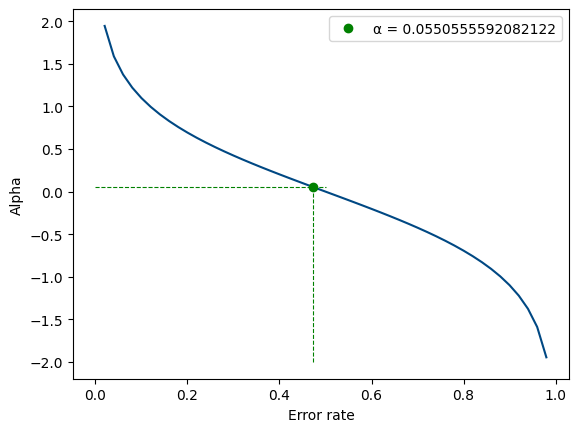

New Sample Weights: [0.002366081408622173, 0.002366081408622173, 0.0026414982921654957, 0.0026414982921654957, 0.002366081408622173, 0.002366081408622173, 0.002366081408622173, 0.0026414982921654957, 0.0026414982921654957, 0.0026414982921654957, 0.002366081408622173, 0.0026414982921654957, 0.0026414982921654957, 0.002366081408622173, 0.0026414982921654957, 0.0026414982921654957, 0.002366081408622173, 0.002366081408622173, 0.0026414982921654957, 0.002366081408622173, 0.002366081408622173, 0.002366081408622173, 0.002366081408622173, 0.0026414982921654957, 0.002366081408622173, 0.0026414982921654957, 0.002366081408622173, 0.0026414982921654957, 0.0026414982921654957, 0.0026414982921654957, 0.002366081408622173, 0.002366081408622173, 0.002366081408622173, 0.0026414982921654957, 0.0026414982921654957, 0.0026414982921654957, 0.0026414982921654957, 0.0026414982921654957, 0.002366081408622173, 0.002366081408622173, 0.0026414982921654957, 0.002366081408622173, 0.002366081408622173, 0.0023660814

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.002370  0.002370  
1     0.0   0.0   0.0         1          0.0025            0.002370  0.004739  
2     0.0   0.0   0.0         0          0.0025            0.002646  0.007385  
3     0.0   0.0   0.0         0          0.0025            0.002646  0.010030  
4     0.0   0.0   0.0         0          0.0025            0.002370  0.012400  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.002646  0.989970  
396   0.0   0.0   0.0         0          0.0025            0.002646  0.992615  
397   0.0   0.0   0.0         1          0.0025            0.002370  0.994985  
398   0.0   0.0   0.0         1          0.0025            0.002370  0.997354  
399   0.0   0.0   0.0         0          0.0025            0.002646  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.001102458695729669 

IG: 0.008764172187766817 

IG: 5.196640141202913e-06 

IG: 0.01123805853854598 

IG: 0.03906029369080599 

IG: 0.010941735149861298 

IG: 0.0044610920492560435 

IG: 0.00931241742747313 

IG: 0.0032163009054385627 

IG: 0.029595516139082845 

IG: 0.01625191092860645 

IG: 1.8141874248422951e-06 

IG: 0.05077529133254444 

IG: 0.0008938578881876325 

IG: 6.878602898385822e-08 

IG: 0.0011294983370687683 

IG: 0.00504191199563786 

IG: 0.0014242751687615351 

IG: 3.446438300469534e-05 

IG: 0.010939104418418721 

IG: 0.00027515254898358155 

IG: 0.06260874809701056 

IG: 5.938611138767147e-05 

IG: 0.06260874809701056 

IG: 0.0001285312535718175 

IG: 0.04866790985374603 

IG: 0.00846940400087659 

IG: 0.013622666091100077 

IG: 0.012550492951823977 

IG: 0.02310281234687228 

IG: 0.00702538781671358 

IG: 0.018549313008795365 

IG: 0.015188506238590915 

IG: 0.0014995656313513406 

IG: 0.000430470254389248 

IG: 0.039114962836456546 

IG: 0.0037808084255235297

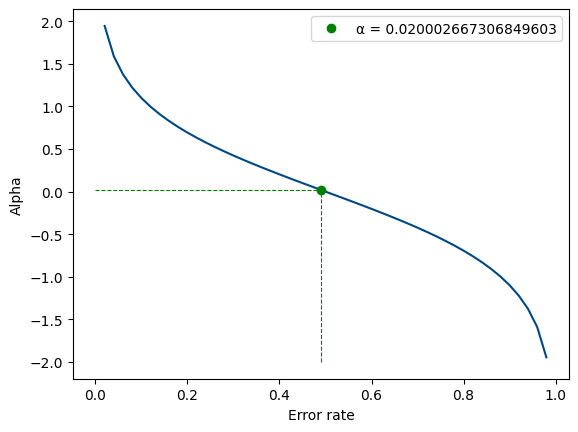

New Sample Weights: [0.002450490147049017, 0.002550510153051018, 0.002550510153051018, 0.002550510153051018, 0.002450490147049017, 0.002450490147049017, 0.002550510153051018, 0.002550510153051018, 0.002450490147049017, 0.002550510153051018, 0.002450490147049017, 0.002450490147049017, 0.002550510153051018, 0.002550510153051018, 0.002550510153051018, 0.002450490147049017, 0.002550510153051018, 0.002550510153051018, 0.002550510153051018, 0.002550510153051018, 0.002550510153051018, 0.002550510153051018, 0.002550510153051018, 0.002550510153051018, 0.002450490147049017, 0.002550510153051018, 0.002550510153051018, 0.002550510153051018, 0.002550510153051018, 0.002550510153051018, 0.002450490147049017, 0.002550510153051018, 0.002450490147049017, 0.002550510153051018, 0.002450490147049017, 0.002550510153051018, 0.002450490147049017, 0.002550510153051018, 0.002450490147049017, 0.002550510153051018, 0.002550510153051018, 0.002550510153051018, 0.002550510153051018, 0.002450490147049017, 0.002550510

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.002451  0.002451  
1     0.0   0.0   0.0         0          0.0025            0.002551  0.005002  
2     0.0   0.0   0.0         0          0.0025            0.002551  0.007553  
3     0.0   0.0   0.0         0          0.0025            0.002551  0.010104  
4     0.0   0.0   0.0         1          0.0025            0.002451  0.012555  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.002451  0.989996  
396   0.0   0.0   0.0         1          0.0025            0.002451  0.992447  
397   0.0   0.0   0.0         0          0.0025            0.002551  0.994998  
398   0.0   0.0   0.0         0          0.0025            0.002551  0.997549  
399   0.0   0.0   0.0         0          0.0025            0.002451  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         1          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.022182200474273106 

IG: 0.016152645610218008 

IG: 0.007396998083870621 

IG: 0.03146624804807219 

IG: 0.05545326698429809 

IG: 0.001676072352937874 

IG: 0.014588143619197247 

IG: 0.023933862568609965 

IG: 0.003276861067781467 

IG: 0.009772971716119905 

IG: 0.010352384158127448 

IG: 0.0010326801043269995 

IG: 0.03810147589899415 

IG: 2.404819739587616e-05 

IG: 0.0005981274640418643 

IG: 0.008776009183142586 

IG: 0.003943395483759549 

IG: 0.003793414234619874 

IG: 0.001215684065834166 

IG: 0.01774644293225336 

IG: 0.0028964928692614134 

IG: 0.06594647722432123 

IG: 0.0020058732361443177 

IG: 0.06594647722432123 

IG: 0.004818644611319645 

IG: 0.009604994242204068 

IG: 0.012872895086431968 

IG: 0.052244221143304514 

IG: 0.018653545588933396 

IG: 0.07526111554353887 

IG: 0.0020632617858604707 

IG: 0.033125404602679764 

IG: 0.00040260304787909096 

IG: 0.012573274037840698 

IG: 0.025543565428270076 

IG: 0.039054530489235795 

IG: 0.0036747662525808966 


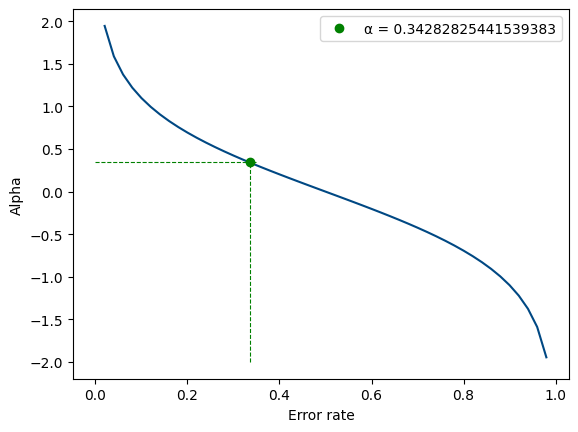

New Sample Weights: [0.001774400248140623, 0.001774400248140623, 0.003522316910488102, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.003522316910488102, 0.001774400248140623, 0.003522316910488102, 0.001774400248140623, 0.001774400248140623, 0.003522316910488102, 0.003522316910488102, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.003522316910488102, 0.001774400248140623, 0.001774400248140623, 0.003522316910488102, 0.003522316910488102, 0.003522316910488102, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.001774400248140623, 0.003522316910488102, 0.001774400248140623, 0.001774400248140623, 0.003522316

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.001880  0.001880  
1     0.0   0.0   0.0         0          0.0025            0.001880  0.003759  
2     0.0   0.0   0.0         1          0.0025            0.003731  0.007491  
3     0.0   0.0   0.0         0          0.0025            0.001880  0.009370  
4     0.0   0.0   0.0         1          0.0025            0.001880  0.011250  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.003731  0.992481  
396   0.0   0.0   0.0         0          0.0025            0.001880  0.994361  
397   0.0   0.0   0.0         0          0.0025            0.001880  0.996241  
398   0.0   0.0   0.0         0          0.0025            0.001880  0.998120  
399   0.0   0.0   0.0         0          0.0025            0.001880  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         1          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 0.018599728529344106 

IG: 0.03733605103250304 

IG: 0.01045499858994825 

IG: 0.021971669475943423 

IG: 0.06128821167055343 

IG: 0.0014568357515312158 

IG: 0.015830770606890088 

IG: 0.032274922254681315 

IG: 0.001303222070454635 

IG: 0.006702078212324936 

IG: 0.0146717634910708 

IG: 0.005449254721316521 

IG: 0.08474843928846687 

IG: 0.010533183249046285 

IG: 0.0033468649206666035 

IG: 0.015111865059353025 

IG: 0.007778368864731489 

IG: 0.003692057166843843 

IG: 0.009213190835077989 

IG: 0.01045499858994825 

IG: 0.00570095636659429 

IG: 0.07977916154045317 

IG: 0.0011602550998577321 

IG: 0.07356355341723941 

IG: 0.044605099163239736 

IG: 0.005888818417785435 

IG: 0.02284558633966305 

IG: 0.056023359963957464 

IG: 0.015596474600945931 

IG: 0.05441968076872361 

IG: 0.007375837855700507 

IG: 0.05825118396751272 

IG: 0.00024380309937954703 

IG: 0.006570716689141776 

IG: 0.02981354412605952 

IG: 0.03733605103250304 

IG: 0.009913769612510226 

IG: 0.00739

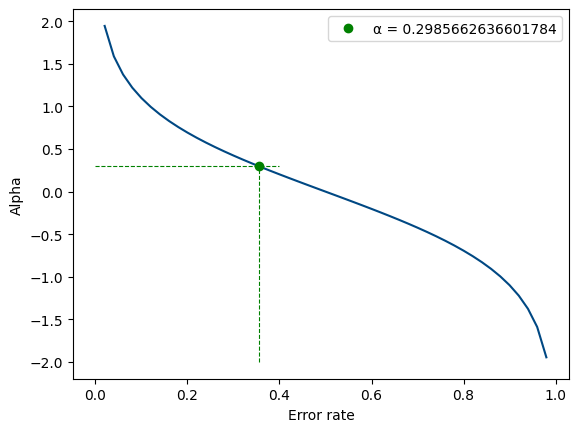

New Sample Weights: [0.0018547028011571434, 0.0033698121316798808, 0.0018547028011571434, 0.0033698121316798808, 0.0033698121316798808, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0033698121316798808, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0033698121316798808, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0018547028011571434, 0.0033698121316798808, 0.0018547028011571434, 0.0033698121316798808, 0.0033698121316798808, 0.0033698121316798808, 0.0033698121316798808, 0.0033698121316798808, 0.0033698121316798808, 0.0018547028011571434, 0.0033698121316798808, 0.0033698121316798808, 0.0018547028011571434, 0.0033698121316798808, 0.0018547028011571434, 0.00185470280

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.001938  0.001938  
1     0.0   0.0   0.0         0          0.0025            0.003521  0.005459  
2     0.0   0.0   0.0         1          0.0025            0.001938  0.007397  
3     0.0   0.0   0.0         0          0.0025            0.003521  0.010918  
4     0.0   0.0   0.0         0          0.0025            0.003521  0.014439  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.003521  0.990665  
396   0.0   0.0   0.0         1          0.0025            0.001938  0.992603  
397   0.0   0.0   0.0         1          0.0025            0.001938  0.994541  
398   0.0   0.0   0.0         0          0.0025            0.003521  0.998062  
399   0.0   0.0   0.0         1          0.0025            0.001938  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
397  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.0010880056957387474 

IG: 0.002476294975099713 

IG: 0.03263517188716758 

IG: 0.0011471803867976194 

IG: 0.001321280254525381 

IG: 0.0017734346120067412 

IG: 0.0015360625173995723 

IG: 0.0029443529200692264 

IG: 5.781264357052063e-05 

IG: 2.4277392925209362e-05 

IG: 0.0012717037967050482 

IG: 0.0036865777751979856 

IG: 0.0003936349332903655 

IG: 0.005858750172594962 

IG: 0.0016506363096491228 

IG: 0.003308396458296392 

IG: 0.001446993829180121 

IG: 0.008068354956475843 

IG: 0.0004395256821523308 

IG: 0.000773654296177706 

IG: 5.781264357052063e-05 

IG: 0.006384787589007401 

IG: 0.00010111379512445229 

IG: 0.002683366360802464 

IG: 0.0007517958963767502 

IG: 0.0012717037967050482 

IG: 0.00045412034543368396 

IG: 0.019952003803641483 

IG: 0.007478758463635882 

IG: 0.003891424645865671 

IG: 0.0017304157829541866 

IG: 0.008754819600334529 

IG: 0.002095514236949758 

IG: 0.0024945379444932803 

IG: 2.6810046135916643e-05 

IG: 0.005858750172594962 

IG: 2

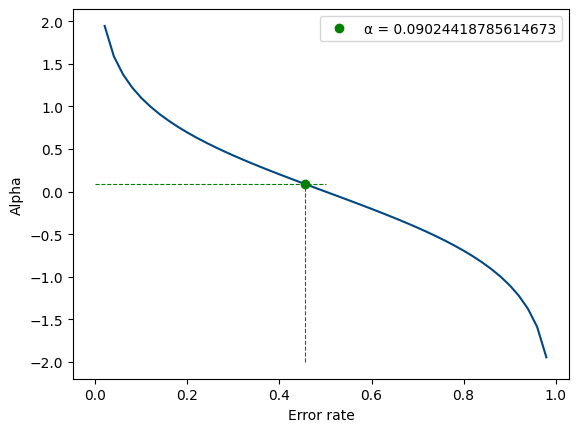

New Sample Weights: [0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002284270104050062, 0.002284270104050062, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002736103751005019, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002284270104050062, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002284270104050062, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002284270104050062, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002284270104050062, 0.002736103751005019, 0.002284270

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
397  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.002294  0.002294  
1     0.0   0.0   0.0         0          0.0025            0.002747  0.005041  
2     0.0   0.0   0.0         0          0.0025            0.002747  0.007788  
3     0.0   0.0   0.0         1          0.0025            0.002294  0.010082  
4     0.0   0.0   0.0         0          0.0025            0.002747  0.012829  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.002747  0.989918  
396   0.0   0.0   0.0         1          0.0025            0.002294  0.992212  
397   0.0   0.0   0.0         1          0.0025            0.002294  0.994505  
398   0.0   0.0   0.0         0          0.0025            0.002747  0.997253  
399   0.0   0.0   0.0         0          0.0025            0.002747  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.00851617719711295 

IG: 0.002572912641912728 

IG: 0.014302533847985743 

IG: 0.0009687464951348979 

IG: 0.0012717926115374256 

IG: 0.015172704931887382 

IG: 0.009022923157750551 

IG: 0.00115468119479889 

IG: 0.0007800205668632154 

IG: 0.006614695359898004 

IG: 1.8045273012523566e-05 

IG: 0.00806013361117297 

IG: 0.005563927201840513 

IG: 0.007795187249969526 

IG: 0.0007924619254101595 

IG: 0.01053642309320113 

IG: 0.002054272087836262 

IG: 0.001743544327629909 

IG: 0.0001705085007303042 

IG: 3.4164155535698626e-06 

IG: 0.0013941585748511454 

IG: 0.004149414091503267 

IG: 0.000734857559527291 

IG: 0.0003088948233994637 

IG: 6.851076704772474e-05 

IG: 0.000513591423255022 

IG: 0.0003340756049239335 

IG: 0.008254847737170112 

IG: 0.001064473054951498 

IG: 0.006556195161000811 

IG: 0.0018202535259070896 

IG: 0.006198712555234631 

IG: 0.0006470775468639944 

IG: 0.012972743361111094 

IG: 0.006727116395454313 

IG: 0.0030648240551391925 

IG: 0.0001705085

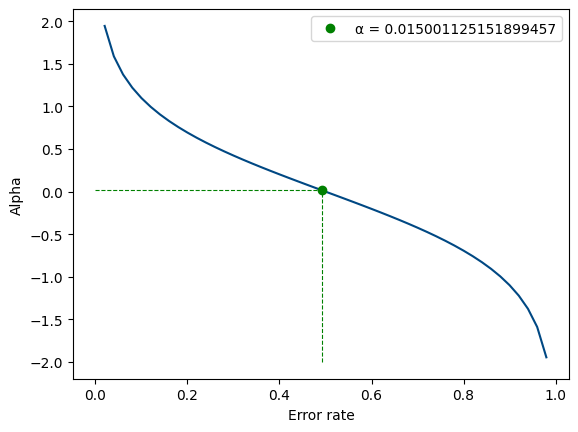

New Sample Weights: [0.0024627770780077905, 0.002537785516931886, 0.002537785516931886, 0.002537785516931886, 0.002537785516931886, 0.002537785516931886, 0.002537785516931886, 0.002537785516931886, 0.002537785516931886, 0.0024627770780077905, 0.002537785516931886, 0.0024627770780077905, 0.002537785516931886, 0.0024627770780077905, 0.0024627770780077905, 0.0024627770780077905, 0.0024627770780077905, 0.0024627770780077905, 0.0024627770780077905, 0.002537785516931886, 0.0024627770780077905, 0.002537785516931886, 0.002537785516931886, 0.002537785516931886, 0.002537785516931886, 0.002537785516931886, 0.0024627770780077905, 0.0024627770780077905, 0.002537785516931886, 0.002537785516931886, 0.002537785516931886, 0.0024627770780077905, 0.0024627770780077905, 0.0024627770780077905, 0.002537785516931886, 0.002537785516931886, 0.0024627770780077905, 0.0024627770780077905, 0.0024627770780077905, 0.0024627770780077905, 0.002537785516931886, 0.002537785516931886, 0.0024627770780077905, 0.00253778551

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.002463  0.002463  
1     0.0   0.0   0.0         0          0.0025            0.002538  0.005001  
2     0.0   0.0   0.0         0          0.0025            0.002538  0.007539  
3     0.0   0.0   0.0         0          0.0025            0.002538  0.010077  
4     0.0   0.0   0.0         0          0.0025            0.002538  0.012615  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.002538  0.989998  
396   0.0   0.0   0.0         0          0.0025            0.002463  0.992461  
397   0.0   0.0   0.0         1          0.0025            0.002463  0.994924  
398   0.0   0.0   0.0         0          0.0025            0.002538  0.997462  
399   0.0   0.0   0.0         0          0.0025            0.002538  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.01647704589348431 

IG: 0.005103256425670555 

IG: 0.02721925321124441 

IG: 0.0003688272174336982 

IG: 0.0006570730796670032 

IG: 0.010896089433944045 

IG: 0.00472834872501382 

IG: 0.002466489575026376 

IG: 0.00929009168265127 

IG: 0.020227703816365072 

IG: 8.066681232477002e-05 

IG: 0.009715253991730788 

IG: 0.004332639757128165 

IG: 0.010080381159742191 

IG: 0.000942616985882383 

IG: 0.02055586063893322 

IG: 0.0015540150638557737 

IG: 0.00029948743161845037 

IG: 0.0012336248853392906 

IG: 0.0017587297324296314 

IG: 0.00013587667581582696 

IG: 0.008928450116597597 

IG: 0.003597650345770087 

IG: 0.0001715266151787187 

IG: 0.0045988260137328485 

IG: 0.0012773727082588948 

IG: 0.000513591423255022 

IG: 0.010080381159742191 

IG: 0.0033854469117065022 

IG: 0.002572912641912728 

IG: 0.003312163211020236 

IG: 0.0011276180481329945 

IG: 0.00021686259211062264 

IG: 0.01566642618795322 

IG: 0.002660348655918021 

IG: 0.002263072092933416 

IG: 0.00057631607

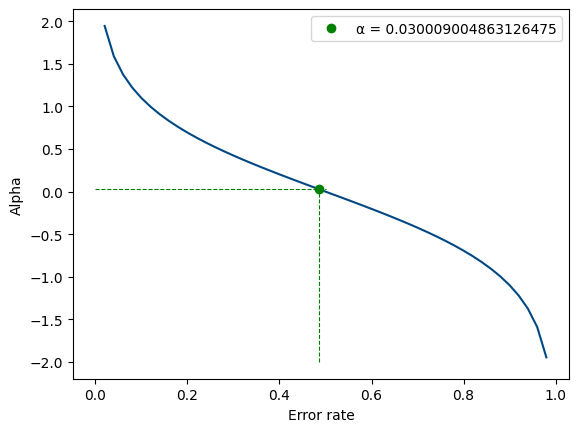

New Sample Weights: [0.0025761595327433297, 0.002426091987146631, 0.0025761595327433297, 0.0025761595327433297, 0.002426091987146631, 0.0025761595327433297, 0.002426091987146631, 0.002426091987146631, 0.002426091987146631, 0.002426091987146631, 0.0025761595327433297, 0.0025761595327433297, 0.002426091987146631, 0.002426091987146631, 0.0025761595327433297, 0.0025761595327433297, 0.002426091987146631, 0.002426091987146631, 0.0025761595327433297, 0.002426091987146631, 0.0025761595327433297, 0.002426091987146631, 0.002426091987146631, 0.002426091987146631, 0.0025761595327433297, 0.002426091987146631, 0.002426091987146631, 0.002426091987146631, 0.002426091987146631, 0.002426091987146631, 0.0025761595327433297, 0.002426091987146631, 0.002426091987146631, 0.0025761595327433297, 0.002426091987146631, 0.0025761595327433297, 0.002426091987146631, 0.002426091987146631, 0.002426091987146631, 0.0025761595327433297, 0.002426091987146631, 0.0025761595327433297, 0.0025761595327433297, 0.00242609198714

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.002577  0.002577  
1     0.0   0.0   0.0         1          0.0025            0.002427  0.005005  
2     0.0   0.0   0.0         0          0.0025            0.002577  0.007582  
3     0.0   0.0   0.0         0          0.0025            0.002577  0.010159  
4     0.0   0.0   0.0         1          0.0025            0.002427  0.012586  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.002427  0.989991  
396   0.0   0.0   0.0         1          0.0025            0.002427  0.992418  
397   0.0   0.0   0.0         0          0.0025            0.002577  0.994995  
398   0.0   0.0   0.0         1          0.0025            0.002427  0.997423  
399   0.0   0.0   0.0         0          0.0025            0.002577  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
396  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.018160694546433542 

IG: 0.00033667423359051707 

IG: 0.031377540829819583 

IG: 0.0008400397811110238 

IG: 0.0011684726854837013 

IG: 0.018684568103703558 

IG: 0.001691895674758248 

IG: 0.0004675316777595917 

IG: 0.011431303764675382 

IG: 0.013202728169965594 

IG: 0.0033919331939221697 

IG: 0.009265352439273733 

IG: 0.0021735030862251037 

IG: 0.01087363416905518 

IG: 0.0015735348168415264 

IG: 0.013688067778643287 

IG: 0.010568435487349093 

IG: 1.8507510448961817e-05 

IG: 0.0012743692880002877 

IG: 0.0004534093402814854 

IG: 0.0007445429690103866 

IG: 0.013971099046571567 

IG: 0.014490843603488068 

IG: 0.001396931814770852 

IG: 0.007306024458646698 

IG: 5.222435101592815e-06 

IG: 0.00010791473424776044 

IG: 0.008439412420545356 

IG: 4.8986345335788606e-05 

IG: 0.0027638052174451255 

IG: 0.0030840133719768348 

IG: 0.005928834231256674 

IG: 0.003643505498382771 

IG: 0.027805240081409055 

IG: 6.002464031884536e-05 

IG: 0.000671891536427105 

IG: 0.00

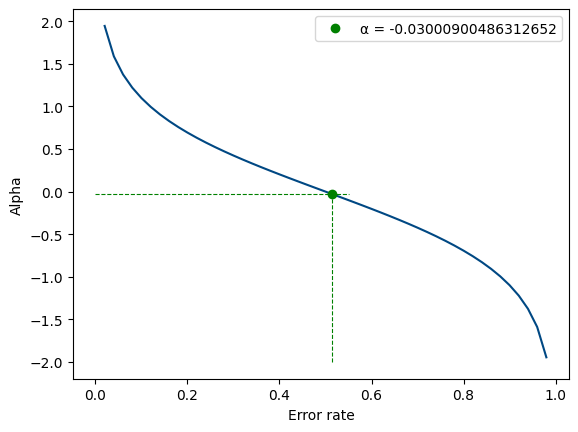

New Sample Weights: [0.0024260919871466305, 0.0025761595327433297, 0.0024260919871466305, 0.0025761595327433297, 0.0025761595327433297, 0.0024260919871466305, 0.0025761595327433297, 0.0024260919871466305, 0.0025761595327433297, 0.0025761595327433297, 0.0025761595327433297, 0.0025761595327433297, 0.0025761595327433297, 0.0024260919871466305, 0.0024260919871466305, 0.0025761595327433297, 0.0024260919871466305, 0.0024260919871466305, 0.0024260919871466305, 0.0025761595327433297, 0.0024260919871466305, 0.0025761595327433297, 0.0025761595327433297, 0.0024260919871466305, 0.0024260919871466305, 0.0025761595327433297, 0.0024260919871466305, 0.0025761595327433297, 0.0025761595327433297, 0.0024260919871466305, 0.0025761595327433297, 0.0024260919871466305, 0.0024260919871466305, 0.0025761595327433297, 0.0024260919871466305, 0.0024260919871466305, 0.0025761595327433297, 0.0025761595327433297, 0.0024260919871466305, 0.0025761595327433297, 0.0025761595327433297, 0.0024260919871466305, 0.00257615953

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
396  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.002427  0.002427  
1     0.0   0.0   0.0         1          0.0025            0.002577  0.005005  
2     0.0   0.0   0.0         0          0.0025            0.002427  0.007432  
3     0.0   0.0   0.0         1          0.0025            0.002577  0.010009  
4     0.0   0.0   0.0         1          0.0025            0.002577  0.012586  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.002427  0.990141  
396   0.0   0.0   0.0         0          0.0025            0.002427  0.992568  
397   0.0   0.0   0.0         1          0.0025            0.002577  0.995146  
398   0.0   0.0   0.0         0          0.0025            0.002427  0.997573  
399   0.0   0.0   0.0         0          0.0025            0.002427  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         1          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.005744995721611579 

IG: 0.004813675482279622 

IG: 0.030327279072137836 

IG: 0.0025715291595991285 

IG: 3.974049972010896e-05 

IG: 0.03937313840761081 

IG: 0.0006064284004139164 

IG: 0.004886875218823916 

IG: 0.01057932961906638 

IG: 0.0035265035978085946 

IG: 0.004607350695581713 

IG: 0.01058482476747713 

IG: 0.008855108563750713 

IG: 0.0157738768476674 

IG: 0.0040808894313292265 

IG: 0.012101648539989962 

IG: 0.006335490645266617 

IG: 0.006646366892134825 

IG: 0.002424144074112511 

IG: 0.00368805972049302 

IG: 0.0034055004813167145 

IG: 0.006961318572145769 

IG: 0.010476701760063656 

IG: 0.0005785960707551663 

IG: 0.003995090804316814 

IG: 0.0002085738630802636 

IG: 8.155707506163345e-05 

IG: 0.010761920122104196 

IG: 0.0014699705909395622 

IG: 0.0034530416235655226 

IG: 0.018820346536654764 

IG: 0.020778358753291704 

IG: 0.0013264524635178132 

IG: 0.020089431711294847 

IG: 0.00030252715327128143 

IG: 0.0001736197480890489 

IG: 0.0001542342431

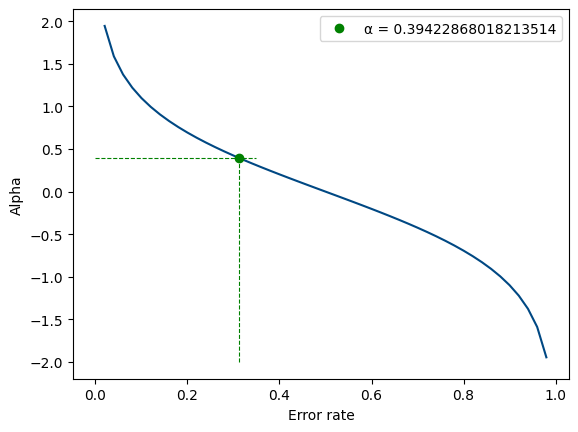

New Sample Weights: [0.001685499656158105, 0.0037080992435478315, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.0037080992435478315, 0.001685499656158105, 0.0037080992435478315, 0.001685499656158105, 0.001685499656158105, 0.0037080992435478315, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.0037080992435478315, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.0037080992435478315, 0.0037080992435478315, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.0037080992435478315, 0.001685499656158105, 0.0037080992435478315, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.001685499656158105, 0.

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.001818  0.001818  
1     0.0   0.0   0.0         1          0.0025            0.004000  0.005818  
2     0.0   0.0   0.0         1          0.0025            0.001818  0.007636  
3     0.0   0.0   0.0         0          0.0025            0.001818  0.009455  
4     0.0   0.0   0.0         0          0.0025            0.001818  0.011273  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.001818  0.990545  
396   0.0   0.0   0.0         1          0.0025            0.004000  0.994545  
397   0.0   0.0   0.0         1          0.0025            0.001818  0.996364  
398   0.0   0.0   0.0         0          0.0025            0.001818  0.998182  
399   0.0   0.0   0.0         0          0.0025            0.001818  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         0          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 0.005063011800354733 

IG: 0.009402045866037767 

IG: 0.04715438120639359 

IG: 0.004740654971458813 

IG: 0.0008951535177497139 

IG: 0.017676003474224378 

IG: 6.186009831599115e-06 

IG: 0.009968607470388746 

IG: 0.006571434720442526 

IG: 0.0018807360762953529 

IG: 0.0009116971690340536 

IG: 0.012844994122327535 

IG: 0.012305403217676036 

IG: 0.017356094099309494 

IG: 0.0010008027955460408 

IG: 0.003455137040526357 

IG: 5.0142411334164194e-08 

IG: 0.002604773877910471 

IG: 8.068203531441664e-05 

IG: 8.09732703298538e-05 

IG: 0.0015524684530764388 

IG: 0.01388390165509501 

IG: 0.013499719018993384 

IG: 0.0031637902125957185 

IG: 0.0015414071795192275 

IG: 0.008977498621010382 

IG: 0.005723904587677131 

IG: 0.0061037833411456965 

IG: 0.00015865470328324527 

IG: 0.008738891049895892 

IG: 0.019802761798198065 

IG: 0.025163795693476487 

IG: 0.00027300492396764575 

IG: 0.020442130372666956 

IG: 0.00215985958586562 

IG: 0.010071336403807307 

IG: 0.007641111

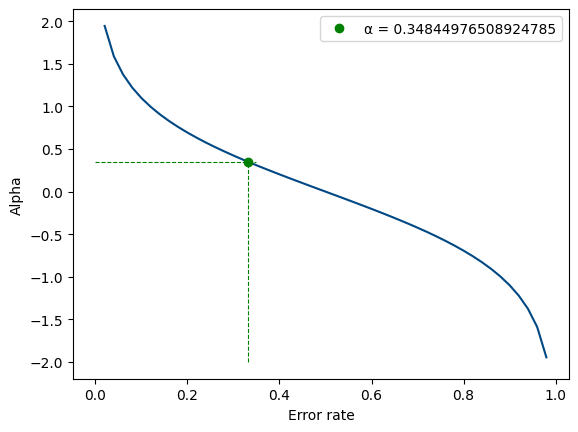

New Sample Weights: [0.003542173412073865, 0.003542173412073865, 0.003542173412073865, 0.003542173412073865, 0.003542173412073865, 0.0017644534224937232, 0.0017644534224937232, 0.003542173412073865, 0.0017644534224937232, 0.0017644534224937232, 0.0017644534224937232, 0.0017644534224937232, 0.003542173412073865, 0.0017644534224937232, 0.0017644534224937232, 0.0017644534224937232, 0.003542173412073865, 0.003542173412073865, 0.003542173412073865, 0.003542173412073865, 0.0017644534224937232, 0.0017644534224937232, 0.0017644534224937232, 0.0017644534224937232, 0.003542173412073865, 0.0017644534224937232, 0.0017644534224937232, 0.003542173412073865, 0.003542173412073865, 0.003542173412073865, 0.003542173412073865, 0.0017644534224937232, 0.003542173412073865, 0.0017644534224937232, 0.0017644534224937232, 0.0017644534224937232, 0.0017644534224937232, 0.0017644534224937232, 0.003542173412073865, 0.0017644534224937232, 0.0017644534224937232, 0.003542173412073865, 0.003542173412073865, 0.00354217

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.003759  0.003759  
1     0.0   0.0   0.0         0          0.0025            0.003759  0.007519  
2     0.0   0.0   0.0         0          0.0025            0.003759  0.011278  
3     0.0   0.0   0.0         0          0.0025            0.003759  0.015038  
4     0.0   0.0   0.0         0          0.0025            0.003759  0.018797  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.003759  0.992509  
396   0.0   0.0   0.0         1          0.0025            0.001873  0.994382  
397   0.0   0.0   0.0         0          0.0025            0.001873  0.996255  
398   0.0   0.0   0.0         1          0.0025            0.001873  0.998127  
399   0.0   0.0   0.0         1          0.0025            0.001873  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
4    1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 1.095133820516736e-06 

IG: 0.02127931006628392 

IG: 0.027203558772947556 

IG: 0.00022703568703175137 

IG: 0.0030567201718205705 

IG: 0.022472849953056095 

IG: 0.0014651719736885616 

IG: 0.0009492113882382247 

IG: 0.0045708432008753075 

IG: 0.0007294694682510316 

IG: 0.0006868289832664409 

IG: 0.007093259396270812 

IG: 0.0016503176557733923 

IG: 0.013153399319381198 

IG: 0.01667076221640784 

IG: 0.0011691217245766161 

IG: 0.000592188766954993 

IG: 0.0057662251267747155 

IG: 0.0022499035620621166 

IG: 7.088374076591464e-07 

IG: 0.000342883169041186 

IG: 0.008326082190442063 

IG: 0.006023119292741574 

IG: 0.010990103550814534 

IG: 0.0013461172437105873 

IG: 0.021065086166862645 

IG: 0.005117088531307767 

IG: 0.000342883169041186 

IG: 8.69430391646775e-05 

IG: 0.004773631797074018 

IG: 0.00655179264696959 

IG: 0.04396952500901441 

IG: 5.707542772859231e-05 

IG: 0.03083445880449187 

IG: 0.0014874489712888295 

IG: 0.006607694405272868 

IG: 0.0200259628

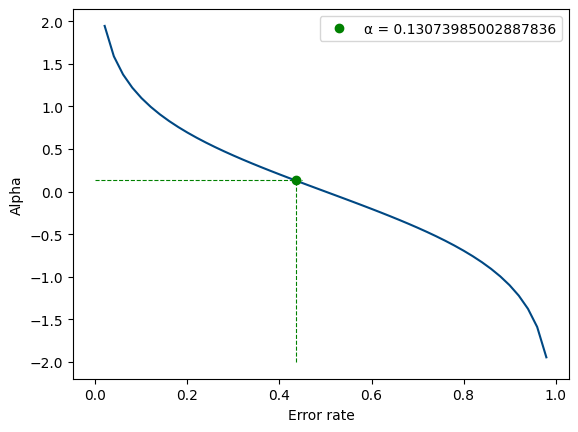

New Sample Weights: [0.0028491781432465786, 0.0021936150306411713, 0.0028491781432465786, 0.0021936150306411713, 0.0021936150306411713, 0.0021936150306411713, 0.0021936150306411713, 0.0021936150306411713, 0.0021936150306411713, 0.0028491781432465786, 0.0021936150306411713, 0.0028491781432465786, 0.0028491781432465786, 0.0021936150306411713, 0.0021936150306411713, 0.0028491781432465786, 0.0028491781432465786, 0.0028491781432465786, 0.0021936150306411713, 0.0021936150306411713, 0.0021936150306411713, 0.0028491781432465786, 0.0028491781432465786, 0.0028491781432465786, 0.0021936150306411713, 0.0028491781432465786, 0.0028491781432465786, 0.0028491781432465786, 0.0028491781432465786, 0.0021936150306411713, 0.0021936150306411713, 0.0021936150306411713, 0.0021936150306411713, 0.0021936150306411713, 0.0028491781432465786, 0.0028491781432465786, 0.0028491781432465786, 0.0021936150306411713, 0.0028491781432465786, 0.0021936150306411713, 0.0021936150306411713, 0.0021936150306411713, 0.00219361503

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
4    1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.002874  0.002874  
1     0.0   0.0   0.0         0          0.0025            0.002212  0.005086  
2     0.0   0.0   0.0         0          0.0025            0.002874  0.007960  
3     0.0   0.0   0.0         1          0.0025            0.002212  0.010172  
4     0.0   0.0   0.0         1          0.0025            0.002212  0.012384  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.002212  0.989828  
396   0.0   0.0   0.0         0          0.0025            0.002874  0.992702  
397   0.0   0.0   0.0         0          0.0025            0.002212  0.994914  
398   0.0   0.0   0.0         1          0.0025            0.002212  0.997126  
399   0.0   0.0   0.0         0          0.0025            0.002874  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.0007824868163538445 

IG: 0.03410648132609395 

IG: 0.05569176914658458 

IG: 0.0004990082987156308 

IG: 0.003020039966525667 

IG: 0.02174664993693931 

IG: 0.014710539068427009 

IG: 0.0002622829518337255 

IG: 0.003923035477525816 

IG: 0.0035758840125700297 

IG: 0.0016085413366412338 

IG: 0.00593977681879132 

IG: 0.0036626570918130152 

IG: 0.01592943923411594 

IG: 0.0048665760985284745 

IG: 0.00294561973928964 

IG: 0.0001943141974328766 

IG: 0.01283186311100648 

IG: 0.0028929981626391044 

IG: 0.00036035441795323475 

IG: 0.001614464946327776 

IG: 0.014873662315910363 

IG: 0.006941247338753231 

IG: 0.013324071872015342 

IG: 0.0017514830702886064 

IG: 0.008160012847605702 

IG: 0.00019362331864358762 

IG: 0.012789044817392514 

IG: 6.771791274640115e-05 

IG: 0.00031605912022836247 

IG: 0.003757522289054016 

IG: 0.04402568785409533 

IG: 0.0020327534351177734 

IG: 0.014755613659797051 

IG: 0.0024682266025061184 

IG: 0.0022968073923114174 

IG: 0.0350280540

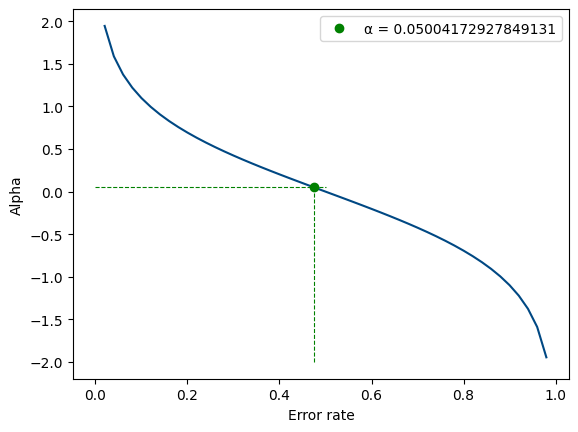

New Sample Weights: [0.0023779743280283546, 0.0023779743280283546, 0.0026282874151892345, 0.0023779743280283546, 0.0023779743280283546, 0.0026282874151892345, 0.0023779743280283546, 0.0023779743280283546, 0.0023779743280283546, 0.0023779743280283546, 0.0026282874151892345, 0.0026282874151892345, 0.0023779743280283546, 0.0026282874151892345, 0.0026282874151892345, 0.0023779743280283546, 0.0026282874151892345, 0.0023779743280283546, 0.0023779743280283546, 0.0023779743280283546, 0.0026282874151892345, 0.0023779743280283546, 0.0023779743280283546, 0.0023779743280283546, 0.0026282874151892345, 0.0026282874151892345, 0.0023779743280283546, 0.0023779743280283546, 0.0026282874151892345, 0.0023779743280283546, 0.0026282874151892345, 0.0023779743280283546, 0.0026282874151892345, 0.0026282874151892345, 0.0023779743280283546, 0.0023779743280283546, 0.0026282874151892345, 0.0026282874151892345, 0.0023779743280283546, 0.0023779743280283546, 0.0023779743280283546, 0.0026282874151892345, 0.00262828741

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.002381  0.002381  
1     0.0   0.0   0.0         0          0.0025            0.002381  0.004762  
2     0.0   0.0   0.0         0          0.0025            0.002632  0.007393  
3     0.0   0.0   0.0         0          0.0025            0.002381  0.009774  
4     0.0   0.0   0.0         1          0.0025            0.002381  0.012155  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.002632  0.989975  
396   0.0   0.0   0.0         0          0.0025            0.002632  0.992607  
397   0.0   0.0   0.0         1          0.0025            0.002381  0.994987  
398   0.0   0.0   0.0         0          0.0025            0.002381  0.997368  
399   0.0   0.0   0.0         0          0.0025            0.002632  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
2    0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         1          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.00943858835228395 

IG: 0.027415094577679322 

IG: 0.06708288555020592 

IG: 0.0005892366548682082 

IG: 0.0001475351473853026 

IG: 0.04967110287655818 

IG: 0.02013717475144927 

IG: 5.210025823310094e-05 

IG: 0.005142656867113682 

IG: 0.007597509335847241 

IG: 0.013823141573321429 

IG: 0.00019000124005574826 

IG: 0.009532831517218843 

IG: 0.014508233395967296 

IG: 0.015133179952810938 

IG: 0.0035211480590453537 

IG: 0.0010960504199455379 

IG: 0.016139879306202864 

IG: 0.0014758601462701026 

IG: 0.0015406239469248906 

IG: 9.919952754344763e-06 

IG: 0.015564227356795302 

IG: 0.003604258376979641 

IG: 0.002769196402572671 

IG: 0.0008653135513333465 

IG: 0.004401656631910167 

IG: 0.002424159707010043 

IG: 0.005147678674306322 

IG: 0.0006698934460220851 

IG: 0.0005718059254569141 

IG: 0.0031731125857952236 

IG: 0.0351717418143257 

IG: 7.032610471957579e-05 

IG: 0.025435425135861056 

IG: 1.2414708061569968e-06 

IG: 0.006401596294633438 

IG: 0.02656299737

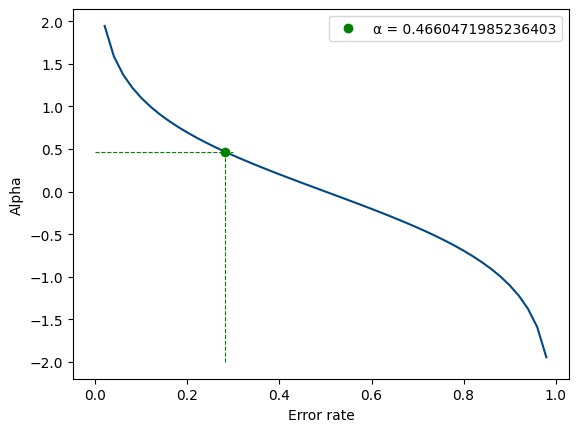

New Sample Weights: [0.0015686941683222461, 0.003984205542552961, 0.003984205542552961, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.003984205542552961, 0.003984205542552961, 0.0015686941683222461, 0.003984205542552961, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.003984205542552961, 0.003984205542552961, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.0015686941683222461, 0.003984205542552961, 0.0015686941683222461

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   
2    0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.001742  0.001742  
1     0.0   0.0   0.0         1          0.0025            0.004425  0.006167  
2     0.0   0.0   0.0         1          0.0025            0.004425  0.010592  
3     0.0   0.0   0.0         0          0.0025            0.001742  0.012334  
4     0.0   0.0   0.0         1          0.0025            0.001742  0.014076  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.004425  0.993031  
396   0.0   0.0   0.0         0          0.0025            0.001742  0.994774  
397   0.0   0.0   0.0         1          0.0025            0.001742  0.996516  
398   0.0   0.0   0.0         0          0.0025            0.001742  0.998258  
399   0.0   0.0   0.0         0          0.0025            0.001742  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         0          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 3.124069835080956e-05 

IG: 0.018644266696685285 

IG: 0.05230283097308397 

IG: 0.0005273572157872275 

IG: 0.002661894363223616 

IG: 0.01736492984483684 

IG: 0.006138336423466506 

IG: 2.7083674903560784e-05 

IG: 0.002062033627259763 

IG: 0.0022262713789964472 

IG: 0.022376188944707165 

IG: 0.005449254721316521 

IG: 0.0005435689708154223 

IG: 0.000652624794182044 

IG: 0.02414587530617396 

IG: 0.0026853020538438743 

IG: 0.0019121186278220348 

IG: 0.0061877661421951835 

IG: 0.0005549177889653256 

IG: 0.009472534904469754 

IG: 4.777513236131625e-07 

IG: 0.023341072188025058 

IG: 0.002354394340466248 

IG: 0.004434018594397737 

IG: 0.01369501580618182 

IG: 0.004049241513993995 

IG: 0.010048587707113033 

IG: 0.008222021494217135 

IG: 0.0019685845089731924 

IG: 0.022430069693825883 

IG: 0.0028060421216581366 

IG: 0.049677264677211896 

IG: 0.00032204691048354217 

IG: 0.0020819491082427755 

IG: 0.00011734714095212873 

IG: 0.00010983895647842523 

IG: 0.035515

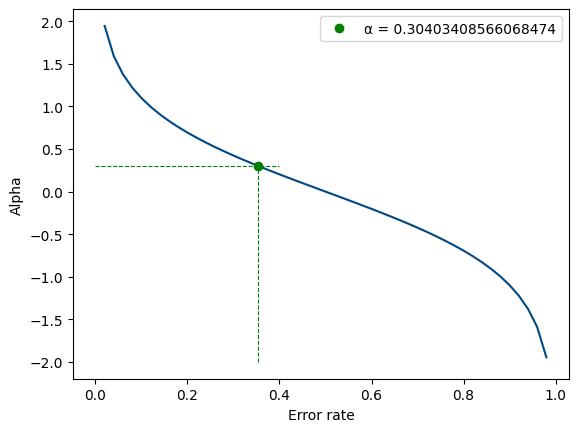

New Sample Weights: [0.001844589291010238, 0.001844589291010238, 0.001844589291010238, 0.001844589291010238, 0.001844589291010238, 0.003388288130295402, 0.001844589291010238, 0.003388288130295402, 0.003388288130295402, 0.001844589291010238, 0.001844589291010238, 0.001844589291010238, 0.001844589291010238, 0.001844589291010238, 0.003388288130295402, 0.001844589291010238, 0.003388288130295402, 0.001844589291010238, 0.001844589291010238, 0.003388288130295402, 0.001844589291010238, 0.003388288130295402, 0.001844589291010238, 0.001844589291010238, 0.001844589291010238, 0.001844589291010238, 0.003388288130295402, 0.003388288130295402, 0.001844589291010238, 0.003388288130295402, 0.003388288130295402, 0.001844589291010238, 0.003388288130295402, 0.003388288130295402, 0.003388288130295402, 0.001844589291010238, 0.003388288130295402, 0.001844589291010238, 0.001844589291010238, 0.003388288130295402, 0.001844589291010238, 0.003388288130295402, 0.003388288130295402, 0.003388288130295402, 0.001844589

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.001931  0.001931  
1     0.0   0.0   0.0         1          0.0025            0.001931  0.003861  
2     0.0   0.0   0.0         0          0.0025            0.001931  0.005792  
3     0.0   0.0   0.0         0          0.0025            0.001931  0.007722  
4     0.0   0.0   0.0         1          0.0025            0.001931  0.009653  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.003546  0.989047  
396   0.0   0.0   0.0         0          0.0025            0.003546  0.992593  
397   0.0   0.0   0.0         1          0.0025            0.001931  0.994523  
398   0.0   0.0   0.0         0          0.0025            0.003546  0.998069  
399   0.0   0.0   0.0         1          0.0025            0.001931  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         1          0.0025  
1     0.0   0.0   0.0   0.0   0.0         1          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         1          0.0025  
396   0.0   0.0   0.0   0.0   0.0         0          0.0025  
397   0.0   0.0   0.0   0.0   0.0         1          0.0025  
398   0.0   0.0   0.0   0.0   0.0         1          0.0025  
399   0.0   0.0   0.0   0.0   0.0         0          0.0025  

[400 rows x 1002 columns]

IG: 0.00012318291862012387 

IG: 0.021804061609259406 

IG: 0.0305671661622523 

IG: 0.00282518769646789 

IG: 1.4785573193565327e-06 

IG: 0.01733753217452505 

IG: 0.004132294162703443 

IG: 0.00849113953908931 

IG: 0.0030281689831977987 

IG: 0.0 

IG: 0.023808993304320625 

IG: 0.0008274897442717144 

IG: 0.0017716560515070867 

IG: 0.0006723729155814206 

IG: 0.031988586449624656 

IG: 0.0003999316551572818 

IG: 0.004344982926469343 

IG: 0.03226056407896072 

IG: 0.002800041299018896 

IG: 0.007484095848995231 

IG: 0.0020328869877322964 

IG: 0.023376118744365737 

IG: 0.0017538850546896523 

IG: 0.0008819734116860545 

IG: 0.00363448522917198 

IG: 0.0015936039297689275 

IG: 0.009895186961954905 

IG: 0.00040968315453460136 

IG: 0.014137116690022489 

IG: 0.0056128823705829944 

IG: 0.0019369341977613086 

IG: 0.08800562231528142 

IG: 0.002455834898480558 

IG: 0.006734853380570782 

IG: 0.0031429950982766464 

IG: 0.0016412324823797952 

IG: 0.032458542833239123 

IG: 0.0

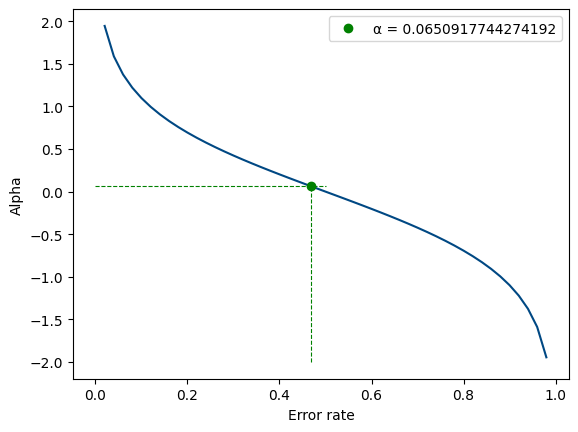

New Sample Weights: [0.002342453671234062, 0.002342453671234062, 0.0026681424169671397, 0.002342453671234062, 0.002342453671234062, 0.0026681424169671397, 0.002342453671234062, 0.002342453671234062, 0.0026681424169671397, 0.0026681424169671397, 0.002342453671234062, 0.002342453671234062, 0.002342453671234062, 0.002342453671234062, 0.0026681424169671397, 0.002342453671234062, 0.0026681424169671397, 0.0026681424169671397, 0.0026681424169671397, 0.0026681424169671397, 0.002342453671234062, 0.002342453671234062, 0.0026681424169671397, 0.0026681424169671397, 0.002342453671234062, 0.0026681424169671397, 0.002342453671234062, 0.002342453671234062, 0.0026681424169671397, 0.002342453671234062, 0.002342453671234062, 0.0026681424169671397, 0.002342453671234062, 0.002342453671234062, 0.0026681424169671397, 0.0026681424169671397, 0.002342453671234062, 0.0026681424169671397, 0.002342453671234062, 0.002342453671234062, 0.0026681424169671397, 0.002342453671234062, 0.0026681424169671397, 0.002668142416

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         1          0.0025            0.002347  0.002347  
1     0.0   0.0   0.0         1          0.0025            0.002347  0.004695  
2     0.0   0.0   0.0         0          0.0025            0.002674  0.007369  
3     0.0   0.0   0.0         1          0.0025            0.002347  0.009716  
4     0.0   0.0   0.0         1          0.0025            0.002347  0.012063  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         1          0.0025            0.002347  0.990284  
396   0.0   0.0   0.0         0          0.0025            0.002674  0.992958  
397   0.0   0.0   0.0         1          0.0025            0.002347  0.995305  
398   0.0   0.0   0.0         1          0.0025            0.002347  0.997653  
399   0.0   0.0   0.0         0          0.0025            0.002347  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------


251  252  253  254  255  256  257  258  259  260  ...  1243  1244  1245  \
0    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1246  1247  1248  1249  1250  Positive  Sample weights  
0     0.0   0.0   0.0   0.0   0.0         0          0.0025  
1     0.0   0.0   0.0   0.0   0.0         0          0.0025  
2     0.0   0.0   0.0   0.0   0.0         0          0.0025  
3     0.0   0.0   0.0   0.0   0.0         1          0.0025  
4     0.0   0.0   0.0   0.0   0.0         1          0.0025  
..    ...   ...   ...   ...   ...       ...             ...  
395   0.0   0.0   0.0   0.0   0.0         0          0.0025  
396   0.0   0.0   0.0   0.0   0.0         1          0.0025  
397   0.0   0.0   0.0   0.0   0.0         0          0.0025  
398   0.0   0.0   0.0   0.0   0.0         0          0.0025  
399   0.0   0.0   0.0   0.0   0.0         1          0.0025  

[400 rows x 1002 columns]

IG: 0.0015827641502498269 

IG: 0.006090834706444115 

IG: 0.038039018214029885 

IG: 0.00023667814148287114 

IG: 0.0007454975350023041 

IG: 0.03962932728342161 

IG: 0.00014404324047778694 

IG: 0.00924782436341931 

IG: 0.000929755380818853 

IG: 0.0 

IG: 0.03432466141181345 

IG: 0.0013713323269363142 

IG: 0.008865655500509995 

IG: 0.008043458906660472 

IG: 0.036108921894451695 

IG: 0.005002279810421673 

IG: 6.931566217860397e-05 

IG: 0.04235810285036046 

IG: 0.009467767429606866 

IG: 0.00454232381950348 

IG: 0.006487239194936878 

IG: 0.015377279451366688 

IG: 0.0021897639257231205 

IG: 0.0009874401902437713 

IG: 0.01304650570165089 

IG: 0.013605347403563117 

IG: 0.030986462365632517 

IG: 8.939397056373366e-06 

IG: 0.007790583332615508 

IG: 0.000284027363747108 

IG: 0.005554474217446481 

IG: 0.10979802934246052 

IG: 0.004658793173791698 

IG: 0.009652379759975793 

IG: 0.0 

IG: 0.000284027363747108 

IG: 0.021668536403936067 

IG: 0.0819764979553298 

IG: 0.

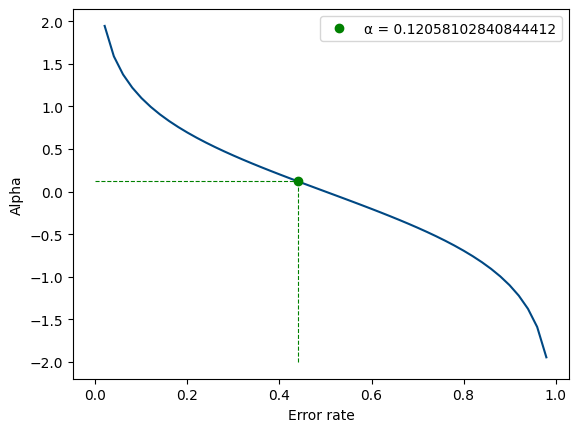

New Sample Weights: [0.002820380374088831, 0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.0022160131510697957, 0.002820380374088831, 0.0022160131510697957, 0.002820380374088831, 0.002820380374088831, 0.0022160131510697957, 0.0022160

251  252  253  254  255  256  257  258  259  260  ...  1245  1246  1247  \
0    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
395  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   0.0   
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
399  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

     1248  1249  1250  Positive  Sample weights  New sample weights   Buckets  
0     0.0   0.0   0.0         0          0.0025            0.002841  0.002841  
1     0.0   0.0   0.0         0          0.0025            0.002841  0.005682  
2     0.0   0.0   0.0         0          0.0025            0.002841  0.008523  
3     0.0   0.0   0.0         1          0.0025            0.002232  0.010755  
4     0.0   0.0   0.0         1          0.0025            0.002232  0.012987  
..    ...   ...   ...       ...             ...                 ...       ...  
395   0.0   0.0   0.0         0          0.0025            0.002841  0.990463  
396   0.0   0.0   0.0         1          0.0025            0.002232  0.992695  
397   0.0   0.0   0.0         0          0.0025            0.002841  0.995536  
398   0.0   0.0   0.0         0          0.0025            0.002232  0.997768  
399   0.0   0.0   0.0         1          0.0025            0.002232  1.000000  

[400 rows x 1004 columns]

----------------------------------------------------------------------------------------------------
Accuracy: [0.5415, 0.5794166666666667, 0.5524583333333334, 0.5179583333333333]
Accuracy Train: [0.49, 0.49, 0.49, 0.49]
Precision: [array([0.49941667, 0.49943738, 0.4969697 , 0.49661509, 0.49659086,
       0.40107829, 0.40100809, 0.40114916, 0.4011962 , 0.40112663,
       0.42169729, 0.42183592, 0.42188868, 0.42174403, 0.42184369,
       0.42125094, 0.42200328, 0.39584062, 0.3958042 , 0.39590623,
       0.3960448 , 0.39625285, 0.38865173, 0.38658493, 0.4312291 ,
       0.43376787, 0.43459027, 0.43477345, 0.43514027, 0.34777037,
       0.29566855, 0.29594722, 0.29604023, 0.29613329, 0.3162015 ,
       0.31595092, 0.31605864, 0.31616644, 0.31690623, 0.31708991,
       0.31750946, 0.31761872, 0.31783747, 0.31771192, 0.3170816 ,
       0.32037815, 0.32014011, 0.32001402, 0.32688865, 0.32747489,
       0.32723358, 0.3271028 , 0.32722042, 0.32269761, 0.32032105,
       0.31969309, 0.32083793,

In [28]:
# initialize list of lists
imdb = IMDB()
real = imdb.getTrainingData(1, 2, 3, 0, 60000, 2000)

x = []
for j in range(4):
    x.append(100*(j+1))
accuracy_scores = []
accuracy_scores_train = []
precision_scores = []
recall_scores = []
f1_scores = []

for i in range(4):
    final = runTest(250, 1000, 100*(j+1), 24000, 12)
    accuracy_scores.append(final[0])
    accuracy_scores_train.append(final[1])
    # we choose to get precision, recall, f1 for the positives
    precision_scores.append(final[2])
    recall_scores.append(final[3])
    f1_scores.append(final[4])
print("Accuracy:", accuracy_scores)
print("Accuracy Train:", accuracy_scores_train)
print("Precision:", precision_scores)
print("Recall:", recall_scores)
print("F1 Score:", f1_scores)

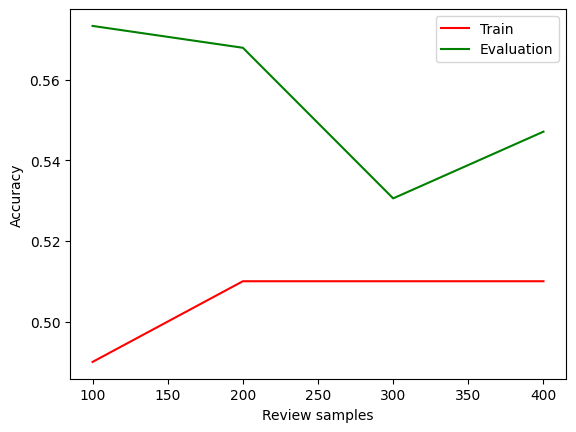

In [13]:
# plot results

# plot the accuracy curve
plt.xlabel("Review samples")
plt.ylabel("Accuracy")

plt.plot(x, accuracy_scores_train, 'red', label="Train")
plt.plot(x, accuracy_scores, 'green', label="Evaluation")

plt.legend()
plt.show()


Predicts: 0 Actual: 0
Proba: 0.34835901226217614


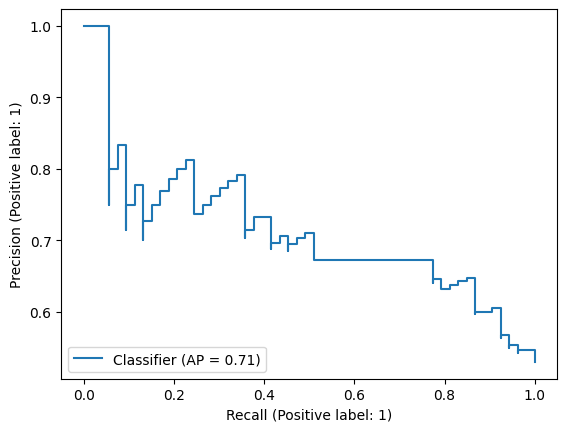

Predicts: 0 Actual: 0
Proba: 0.48851721306514767
Predicts: 1 Actual: 0
Proba: 0.5034750529922669
Predicts: 1 Actual: 0
Proba: 0.5219346468496396
Predicts: 0 Actual: 0
Proba: 0.49070380332582375
Predicts: 0 Actual: 0
Proba: 0.4900151511047114
Predicts: 0 Actual: 0
Proba: 0.4910932453509714
Predicts: 0 Actual: 0
Proba: 0.48121643573714407
Predicts: 0 Actual: 0
Proba: 0.4908284204385387
Predicts: 0 Actual: 0
Proba: 0.4870531912669436


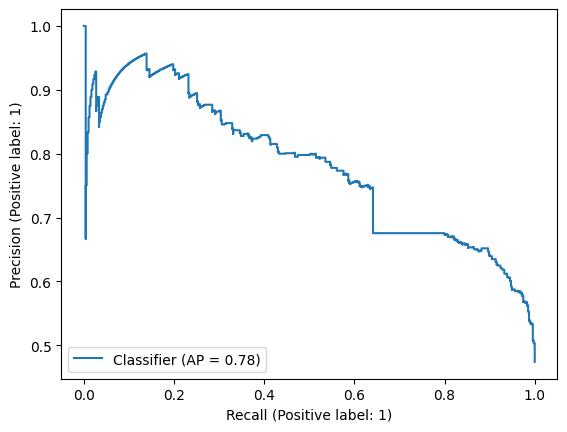

[1.0, 1.0, 0.98, 0.9175, 0.89, 0.8933333333333333, 0.8528571428571429, 0.845, 0.8288888888888889, 0.823]
[0.59, 0.675, 0.6533333333333333, 0.6775, 0.682, 0.695, 0.7157142857142857, 0.72875, 0.7366666666666667, 0.722]
[0.7307692307692307, 0.6262626262626263, 0.6149068322981367, 0.6367521367521367, 0.6965174129353234, 0.6706231454005934, 0.6683168316831684, 0.6889400921658986, 0.7493472584856397, 0.6725352112676056]
[0.3584905660377358, 0.6888888888888889, 0.7021276595744681, 0.772020725388601, 0.5882352941176471, 0.7583892617449665, 0.8059701492537313, 0.7847769028871391, 0.6705607476635514, 0.8059071729957806]
[0.4810126582278481, 0.6560846560846562, 0.6556291390728477, 0.6978922716627634, 0.6378132118451025, 0.7118110236220472, 0.7307171853856562, 0.7337423312883435, 0.7077681874229347, 0.7332053742802302]


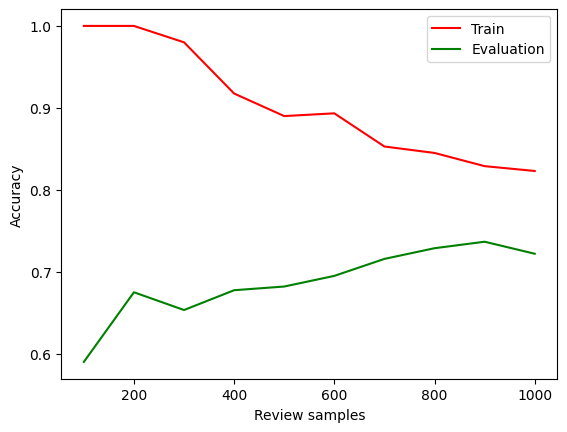

In [17]:
# Sklearn Adaboost
imdb = IMDB()

def runTestSK(N=250, M=1000, REVIEWS=1000, TESTS=1000):
    res = imdb.getTrainingData(1, 2, 3, N, M, 2000)
    train, test = res[0], res[1]
    
    # get feature vector
    features = imdb.getFeatureVector(N, M)

    # get values of each feature for n movie reviews
    n = REVIEWS
    X_train = np.zeros((n, len(features)))
    y_train = list()
    X_test = np.zeros((n, len(features)))
    y_test = list()
    # for the first n reviews
    for i in range(n):
        x_i = imdb.getXtrain(i)
        xt_i = imdb.getXtest(i)
        y_train.append(imdb.getYtrain(i))
        y_test.append(imdb.getYtest(i))
        # for word index in x_train
        for wi in x_i:
            if wi == 2:
                continue
            elif (wi in features):
                j = features.index(wi)
                X_train[i][j] = 1
        for wi in xt_i:
            if wi == 2:
                continue
            elif (wi in features):
                j = features.index(wi)
                X_test[i][j] = 1

    ab = sklearn.ensemble.AdaBoostClassifier()
    ab.fit(X_train, y_train)

    y_train_pred = ab.predict(X_train)
    y_test_pred = ab.predict(X_test)

    pred_proba = ab.predict_proba(X_test)[:, 1]

    return y_train_pred, y_test_pred, y_train, y_test, pred_proba


# run Test SK
xs = []
for i in range(10):
    xs.append(100*(i+1))
trains_accuracy = []
tests_accuracy = []
precisions = []
recalls = []
f1s = []

for i in range(10):
    results = runTestSK(REVIEWS=100*(i+1))
    y_train_pred = results[0]
    y_test_pred = results[1]
    y_train = results[2]
    y_test = results[3]
    predict_proba = results[4]

    print("Predicts:", y_test_pred[0], "Actual:", y_test[0])
    print("Proba:", predict_proba[0])

    ada_train = sklearn.metrics.accuracy_score(y_train, y_train_pred)
    ada_test = sklearn.metrics.accuracy_score(y_test, y_test_pred)
    ada_precision = sklearn.metrics.precision_score(y_true=y_test, y_pred=y_test_pred)
    ada_recall = sklearn.metrics.recall_score(y_true=y_test, y_pred=y_test_pred)
    ada_f1 = sklearn.metrics.f1_score(y_true=y_test, y_pred=y_test_pred)

    trains_accuracy.append(ada_train)
    tests_accuracy.append(ada_test)
    precisions.append(ada_precision)
    recalls.append(ada_recall)
    f1s.append(ada_f1)

    if (i==0 or i==9):
        sklearn.metrics.PrecisionRecallDisplay.from_predictions(y_test, predict_proba)
        plt.show()

print(trains_accuracy)
print(tests_accuracy)
print(precisions)
print(recalls)
print(f1s)

# plot the accuracy curve
plt.xlabel("Review samples")
plt.ylabel("Accuracy")

plt.plot(xs, trains_accuracy, 'red', label="Train")
plt.plot(xs, tests_accuracy, 'green', label="Evaluation")

plt.legend()
plt.show()
